
# Bitcoin Price Direction Prediction - ML Modeling
This notebook implements machine learning models to predict Bitcoin price direction using both technical indicators and sentiment features


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# For ML modeling
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            classification_report, roc_curve)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV

# For feature importance and interpretation
from sklearn.inspection import permutation_importance

# For multicollinearity analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configure visualizations
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.grid'] = True
sns.set_palette('viridis')

In [3]:
print("# Bitcoin Price Direction Prediction - ML Modeling")
print("=" * 80)

# Bitcoin Price Direction Prediction - ML Modeling


In [4]:
file_path = 'btc_prediction_with_sentiment.csv'

In [5]:
try:
    # Try loading from CSV
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    print(f"Dataset loaded successfully from {file_path}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Dataset loaded successfully from btc_prediction_with_sentiment.csv


In [6]:
print("\n## 1.2 Dataset Overview")
print("-" * 50)

print(f"Dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Date range: {df.index.min()} to {df.index.max()}")


## 1.2 Dataset Overview
--------------------------------------------------
Dataset shape: 262 rows, 22 columns
Date range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00


In [7]:
missing_values = df.isna().sum()
if missing_values.sum() > 0:
    print("\nColumns with missing values:")
    print(missing_values[missing_values > 0])
else:
    print("\nNo missing values found in the dataset. ✓")


No missing values found in the dataset. ✓


In [8]:
print("\nFirst few rows of the dataset:")
print(df.head())


First few rows of the dataset:
              ROC_1d  MACD_hist_change  Close_to_SMA10  volume_change_1d  \
date                                                                       
2024-01-01  4.912017         90.927731        1.021775         -0.291271   
2024-01-02  1.790094        107.648532        1.033639          1.134657   
2024-01-03 -4.692812        -72.222570        0.986957          0.178137   
2024-01-04  3.108058         39.009712        1.016905         -0.342974   
2024-01-05 -0.039001         21.060548        1.016123          0.062005   

            high_low_range    ROC_3d  BTC_GLD_corr_5d  BTC_Nasdaq_corr_5d  \
date                                                                        
2024-01-01        0.044387  1.667654         0.033338           -0.061600   
2024-01-02        0.038319  5.466175         0.587095            0.065235   
2024-01-03        0.109449  1.778584         0.876800            0.244288   
2024-01-04        0.047416  0.028505         0.880

In [9]:
print("\nColumns in the dataset:")
print(df.columns.tolist())


Columns in the dataset:
['ROC_1d', 'MACD_hist_change', 'Close_to_SMA10', 'volume_change_1d', 'high_low_range', 'ROC_3d', 'BTC_GLD_corr_5d', 'BTC_Nasdaq_corr_5d', 'Close_to_SMA20', 'BTC_Nasdaq_beta_10d', 'target_nextday', 'sent_q2_flag', 'sent_accel', 'sent_vol', 'sent_delta', 'sent_5d', 'sent_cross_up', 'sent_q5_flag', 'sent_q2_flag_x_Close_to_SMA10', 'sent_q2_flag_x_high_low_range', 'sent_cross_up_x_high_low_range', 'sent_neg_x_high_low_range']


In [10]:
print("\n## 1.3 Features and Target Separation")
print("-" * 50)


## 1.3 Features and Target Separation
--------------------------------------------------


In [11]:
target_col = 'target_nextday'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in the dataset")

In [12]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

In [13]:
# Identify technical and sentiment features based on naming conventions
technical_features = [col for col in X.columns if not col.startswith('sent_')]
sentiment_features = [col for col in X.columns if col.startswith('sent_')]

In [14]:
print(f"Total features: {len(X.columns)}")
print(f"Technical features: {len(technical_features)}")
print(f"Sentiment features: {len(sentiment_features)}")

Total features: 21
Technical features: 10
Sentiment features: 11


In [15]:
print("\nTechnical features:")
for i, feature in enumerate(technical_features):
    print(f"{i+1}. {feature}")

print("\nSentiment features:")
for i, feature in enumerate(sentiment_features):
    print(f"{i+1}. {feature}")


Technical features:
1. ROC_1d
2. MACD_hist_change
3. Close_to_SMA10
4. volume_change_1d
5. high_low_range
6. ROC_3d
7. BTC_GLD_corr_5d
8. BTC_Nasdaq_corr_5d
9. Close_to_SMA20
10. BTC_Nasdaq_beta_10d

Sentiment features:
1. sent_q2_flag
2. sent_accel
3. sent_vol
4. sent_delta
5. sent_5d
6. sent_cross_up
7. sent_q5_flag
8. sent_q2_flag_x_Close_to_SMA10
9. sent_q2_flag_x_high_low_range
10. sent_cross_up_x_high_low_range
11. sent_neg_x_high_low_range



## 1.4 Target Variable Analysis
--------------------------------------------------
Target distribution:
Class 1 (Up): 131 samples (50.00%)
Class 0 (Down): 131 samples (50.00%)


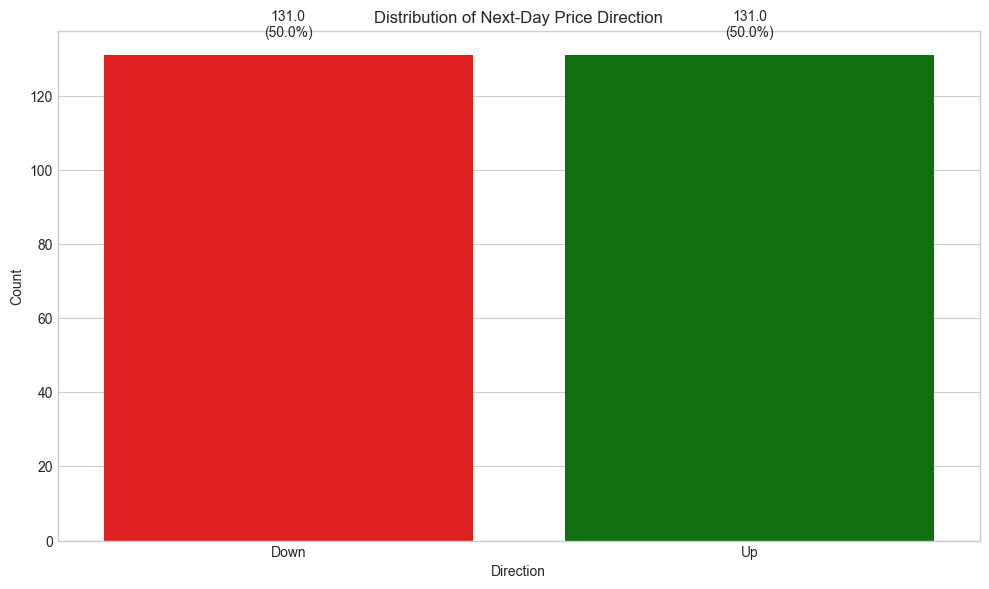

In [16]:
# 1.4 Target variable analysis
print("\n## 1.4 Target Variable Analysis")
print("-" * 50)

# Distribution of the target variable
target_counts = y.value_counts()
target_percentages = y.value_counts(normalize=True) * 100

print("Target distribution:")
for value, count in target_counts.items():
    percentage = target_percentages[value]
    print(f"Class {value} ({'Up' if value == 1 else 'Down'}): {count} samples ({percentage:.2f}%)")

# Plot target distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=y, palette=['red', 'green'])
ax.set_xticklabels(['Down', 'Up'])
ax.set_title('Distribution of Next-Day Price Direction')
ax.set_ylabel('Count')
ax.set_xlabel('Direction')

# Add count and percentage labels on bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5,
            f'{height}\n({target_percentages.iloc[i]:.1f}%)',
            ha='center')

plt.tight_layout()
plt.show()


## 1.5 Time Series Considerations
--------------------------------------------------
Dataset is properly sorted chronologically. ✓


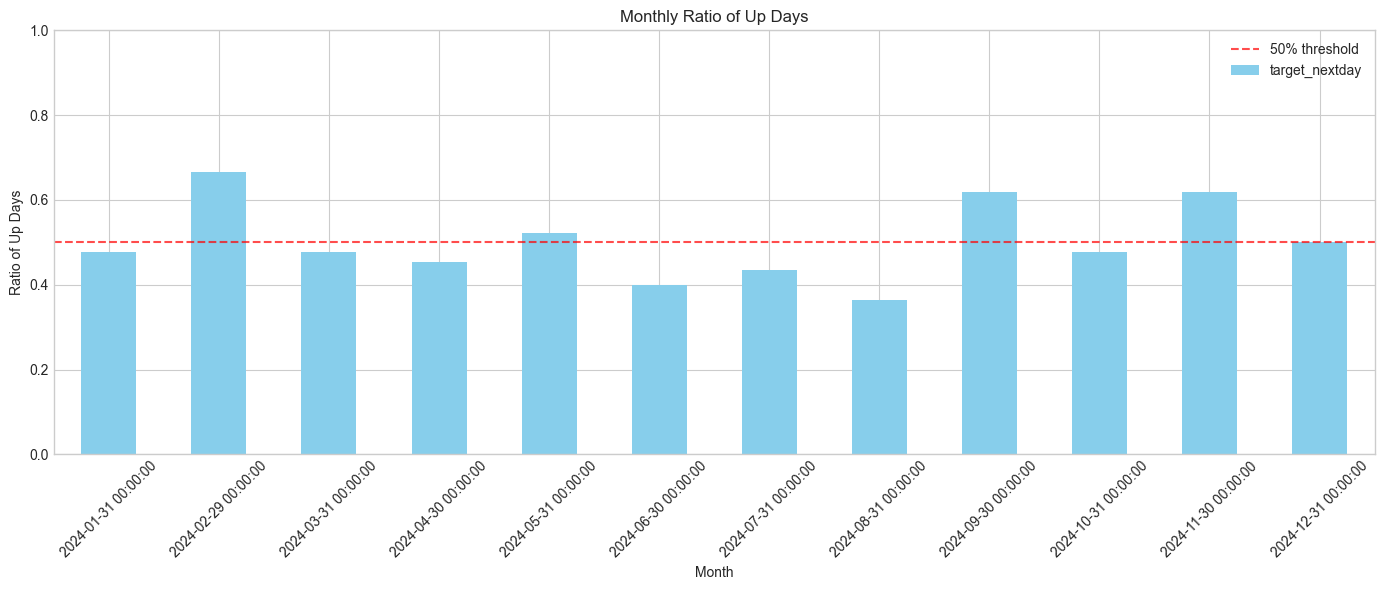


Monthly up-day ratios:
2024-01: 0.48 (47.8%)
2024-02: 0.67 (66.7%)
2024-03: 0.48 (47.6%)
2024-04: 0.45 (45.5%)
2024-05: 0.52 (52.2%)
2024-06: 0.40 (40.0%)
2024-07: 0.43 (43.5%)
2024-08: 0.36 (36.4%)
2024-09: 0.62 (61.9%)
2024-10: 0.48 (47.8%)
2024-11: 0.62 (61.9%)
2024-12: 0.50 (50.0%)

No regime features found in the dataset.


In [17]:
# 1.5 Time Series Considerations
print("\n## 1.5 Time Series Considerations")
print("-" * 50)

# Check if dataset is properly sorted by date
if not df.index.is_monotonic_increasing:
    print("WARNING: Dataset is not sorted chronologically. Sorting now...")
    df = df.sort_index()
    # Re-do the separation
    X = df.drop(columns=[target_col])
    y = df[target_col]
else:
    print("Dataset is properly sorted chronologically. ✓")

# Look at target variable distribution over time (monthly)
monthly_up_ratio = df.resample('M')[target_col].mean()

plt.figure(figsize=(14, 6))
monthly_up_ratio.plot(kind='bar', color='skyblue')
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, 
           label='50% threshold')
plt.title('Monthly Ratio of Up Days')
plt.ylabel('Ratio of Up Days')
plt.xlabel('Month')
plt.ylim(0, 1)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nMonthly up-day ratios:")
for date, ratio in monthly_up_ratio.items():
    print(f"{date.strftime('%Y-%m')}: {ratio:.2f} ({ratio*100:.1f}%)")

# Check if there are any regime features in the dataset
regime_features = [col for col in X.columns if 'regime' in col.lower()]
if regime_features:
    print("\nRegime features found in dataset:", regime_features)
    
    # Analyze target by regime
    regime_col = regime_features[0]
    regime_up_ratio = df.groupby(regime_col)[target_col].mean()
    
    print("\nTarget distribution by regime:")
    for regime, ratio in regime_up_ratio.items():
        count = df[df[regime_col] == regime].shape[0]
        print(f"Regime '{regime}': {ratio:.4f} up ratio ({count} samples)")
        
    # Plot target by regime
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=df[regime_col], hue=df[target_col], 
                      palette=['red', 'green'])
    plt.title('Price Direction by Market Regime')
    plt.xlabel('Market Regime')
    plt.ylabel('Count')
    plt.legend(['Down', 'Up'])
    plt.tight_layout()
    plt.show()
else:
    print("\nNo regime features found in the dataset.")


## 1.6 Feature Correlation with Target
--------------------------------------------------

Top 10 features by correlation magnitude:
                                correlation  abs_correlation
sent_q2_flag_x_Close_to_SMA10      0.153685         0.153685
sent_q2_flag                       0.153112         0.153112
sent_q2_flag_x_high_low_range      0.138135         0.138135
MACD_hist_change                  -0.109564         0.109564
ROC_1d                            -0.101278         0.101278
ROC_3d                            -0.094189         0.094189
volume_change_1d                   0.079191         0.079191
sent_cross_up_x_high_low_range     0.076358         0.076358
sent_q5_flag                       0.066510         0.066510
BTC_Nasdaq_beta_10d               -0.063243         0.063243


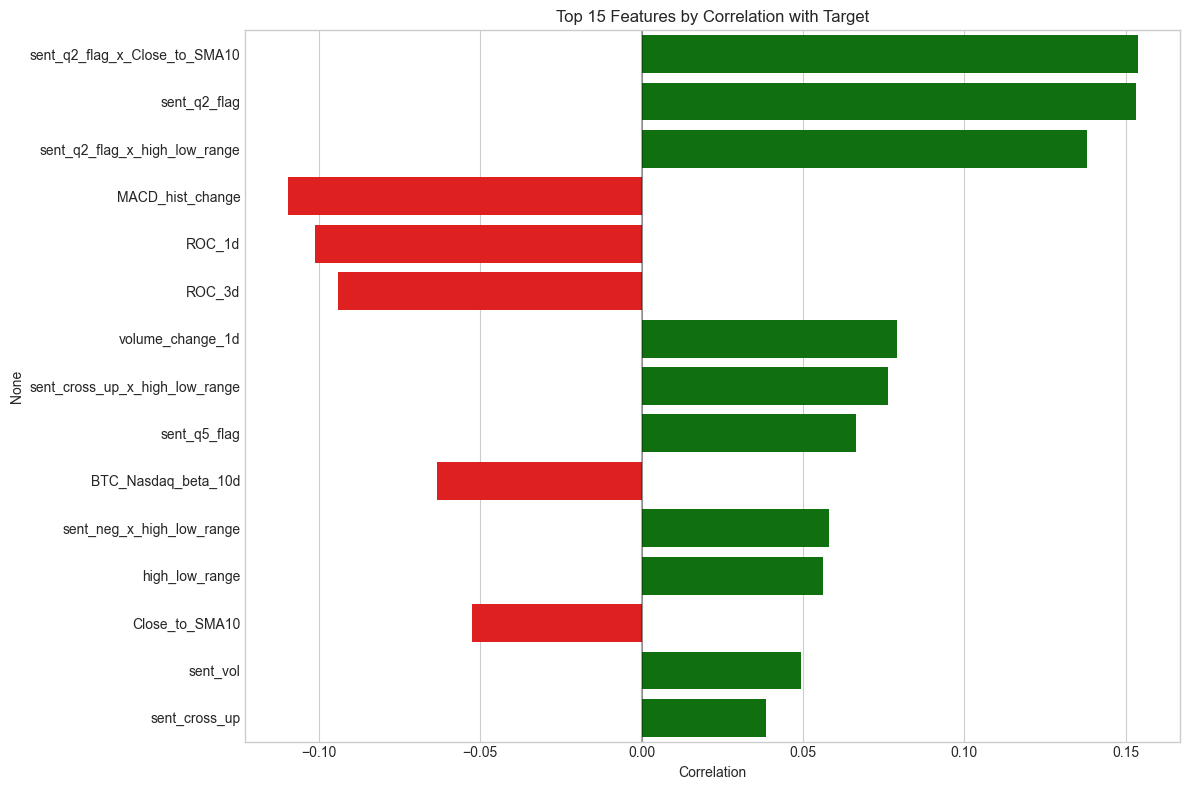


Of the top 15 correlated features:
- Technical features: 7
- Sentiment features: 8


In [18]:
# 1.6 Check feature correlations with target
print("\n## 1.6 Feature Correlation with Target")
print("-" * 50)

# Calculate correlations with target
correlations = pd.DataFrame(index=X.columns)
correlations['correlation'] = X.corrwith(y)
correlations['abs_correlation'] = correlations['correlation'].abs()
correlations = correlations.sort_values('abs_correlation', ascending=False)

# Display top correlations
print("\nTop 10 features by correlation magnitude:")
print(correlations.head(10))

# Plot top correlations
plt.figure(figsize=(12, 8))
top_n = 15  # Show top 15 features
top_features = correlations.head(top_n).index
top_corrs = correlations.loc[top_features, 'correlation']

# Create bar colors based on correlation sign
colors = ['green' if c > 0 else 'red' for c in top_corrs]

# Plot
sns.barplot(x=top_corrs.values, y=top_features, palette=colors)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title(f'Top {top_n} Features by Correlation with Target')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

# Count technical vs. sentiment features in top correlations
top_features_list = top_features.tolist()
n_technical = sum(1 for f in top_features_list if not f.startswith('sent_'))
n_sentiment = sum(1 for f in top_features_list if f.startswith('sent_'))

print(f"\nOf the top {top_n} correlated features:")
print(f"- Technical features: {n_technical}")
print(f"- Sentiment features: {n_sentiment}")


## 1.7 Feature Distributions
--------------------------------------------------


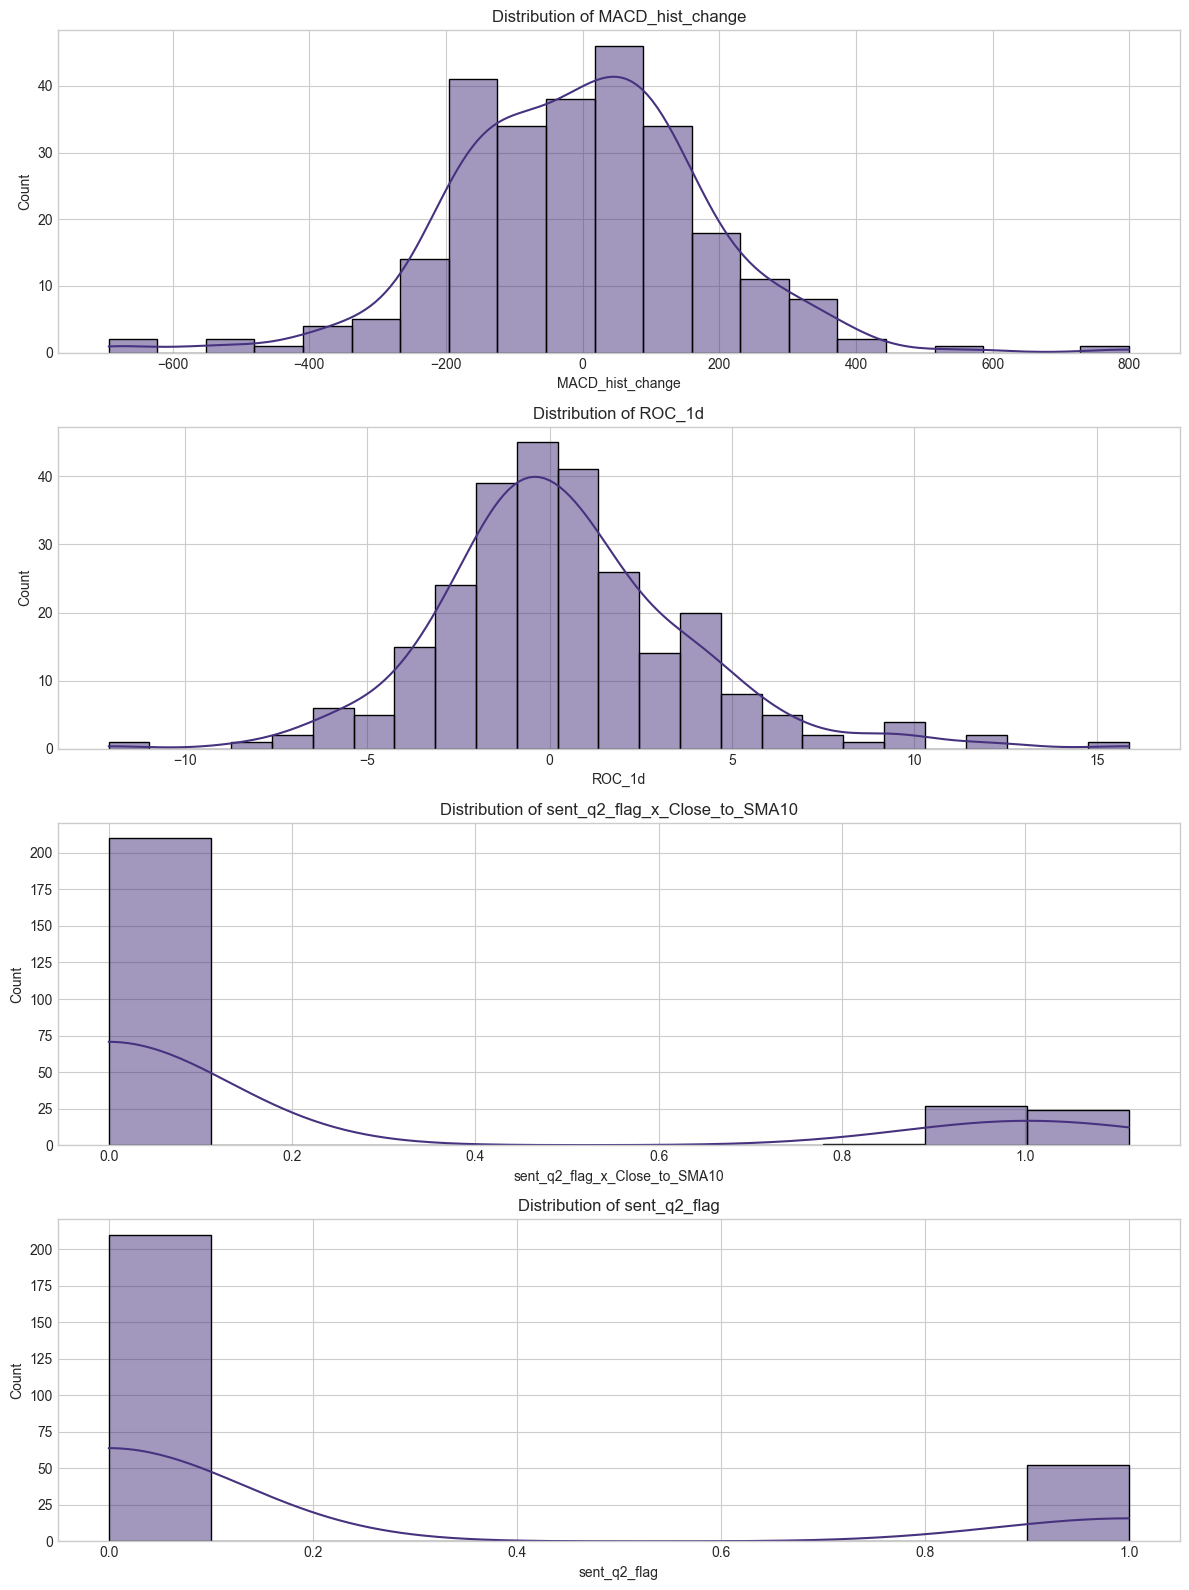

In [19]:
# 1.7 Feature distributions
print("\n## 1.7 Feature Distributions")
print("-" * 50)

# Select a few important features for visualization
if n_sentiment > 0:
    # Include some sentiment features
    top_sentiment = [f for f in top_features_list if f.startswith('sent_')][:2]
else:
    top_sentiment = []

if n_technical > 0:
    # Include some technical features
    top_technical = [f for f in top_features_list if not f.startswith('sent_')][:2]
else:
    top_technical = []

# Combine and ensure we have features to plot
features_to_plot = top_technical + top_sentiment
if not features_to_plot and len(X.columns) > 0:
    # If no top features, just take the first few
    features_to_plot = X.columns[:4].tolist()

# Plot histograms
if features_to_plot:
    fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(12, 4*len(features_to_plot)))
    if len(features_to_plot) == 1:
        axes = [axes]  # Make it iterable if only one subplot
        
    for i, feature in enumerate(features_to_plot):
        ax = axes[i]
        sns.histplot(X[feature], kde=True, ax=ax)
        ax.set_title(f'Distribution of {feature}')
        ax.set_xlabel(feature)
        
    plt.tight_layout()
    plt.show()

In [20]:
# 2.2 Time-based train-test split
print("\n## 2.2 Time-Based Train-Test Split")
print("-" * 50)

# Define train-test split ratio (80% train, 20% test)
train_size = 0.8
split_date = df.index[int(len(df) * train_size)]

print(f"Training data: from {df.index.min()} to {split_date}")
print(f"Testing data: from {split_date} to {df.index.max()}")


## 2.2 Time-Based Train-Test Split
--------------------------------------------------
Training data: from 2024-01-01 00:00:00 to 2024-10-18 00:00:00
Testing data: from 2024-10-18 00:00:00 to 2024-12-31 00:00:00


In [21]:
# Create train and test sets
X_train = X.loc[:split_date]
X_test = X.loc[split_date:]
y_train = y.loc[:split_date]
y_test = y.loc[split_date:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 210 samples
Testing set: 53 samples


In [22]:
# Check class distribution in train and test sets
train_class_dist = y_train.value_counts(normalize=True) * 100
test_class_dist = y_test.value_counts(normalize=True) * 100

print("\nClass distribution in training set:")
for value in sorted(train_class_dist.index):
    print(f"Class {value} ({'Up' if value == 1 else 'Down'}): {train_class_dist[value]:.2f}%")

print("\nClass distribution in testing set:")
for value in sorted(test_class_dist.index):
    print(f"Class {value} ({'Up' if value == 1 else 'Down'}): {test_class_dist[value]:.2f}%")


Class distribution in training set:
Class 0 (Down): 50.48%
Class 1 (Up): 49.52%

Class distribution in testing set:
Class 0 (Down): 49.06%
Class 1 (Up): 50.94%


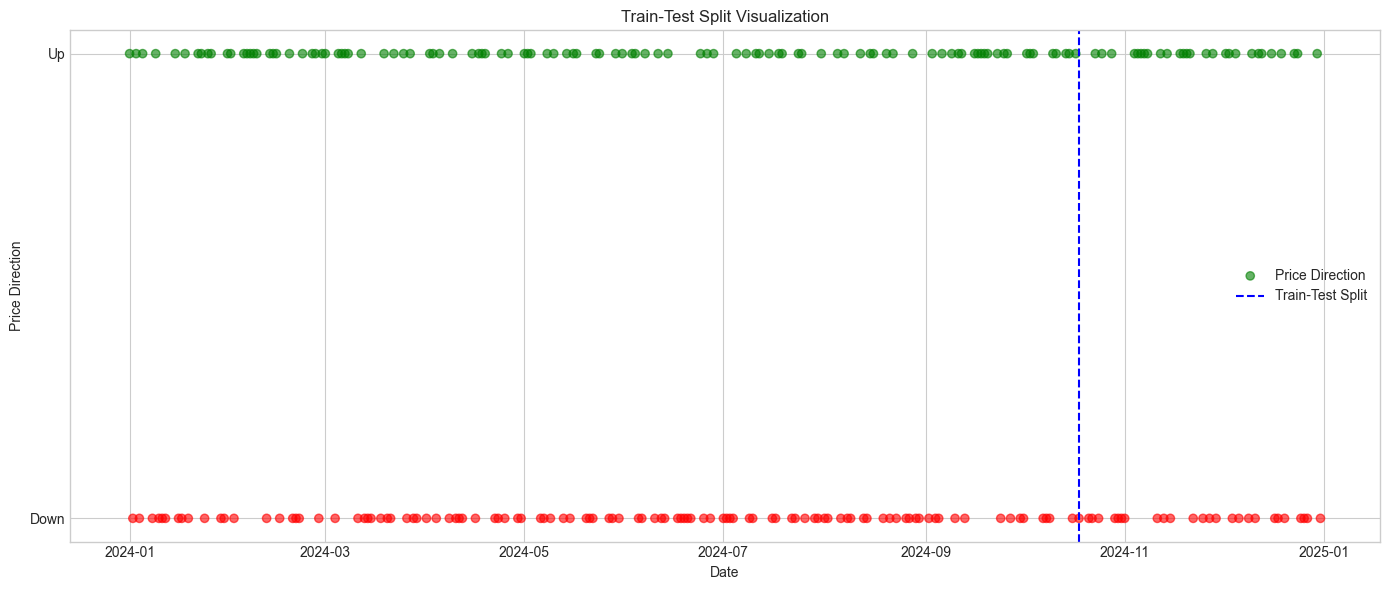

In [23]:
# Visualize train-test split on price direction
plt.figure(figsize=(14, 6))
plt.scatter(df.index, y, c=['red' if val == 0 else 'green' for val in y], 
           alpha=0.6, label='Price Direction')
plt.axvline(x=split_date, color='blue', linestyle='--', label='Train-Test Split')
plt.title('Train-Test Split Visualization')
plt.xlabel('Date')
plt.ylabel('Price Direction')
plt.yticks([0, 1], ['Down', 'Up'])
plt.legend()
plt.tight_layout()
plt.show()


## 2.3 Multicollinearity Analysis
--------------------------------------------------

Analyzing feature correlations...


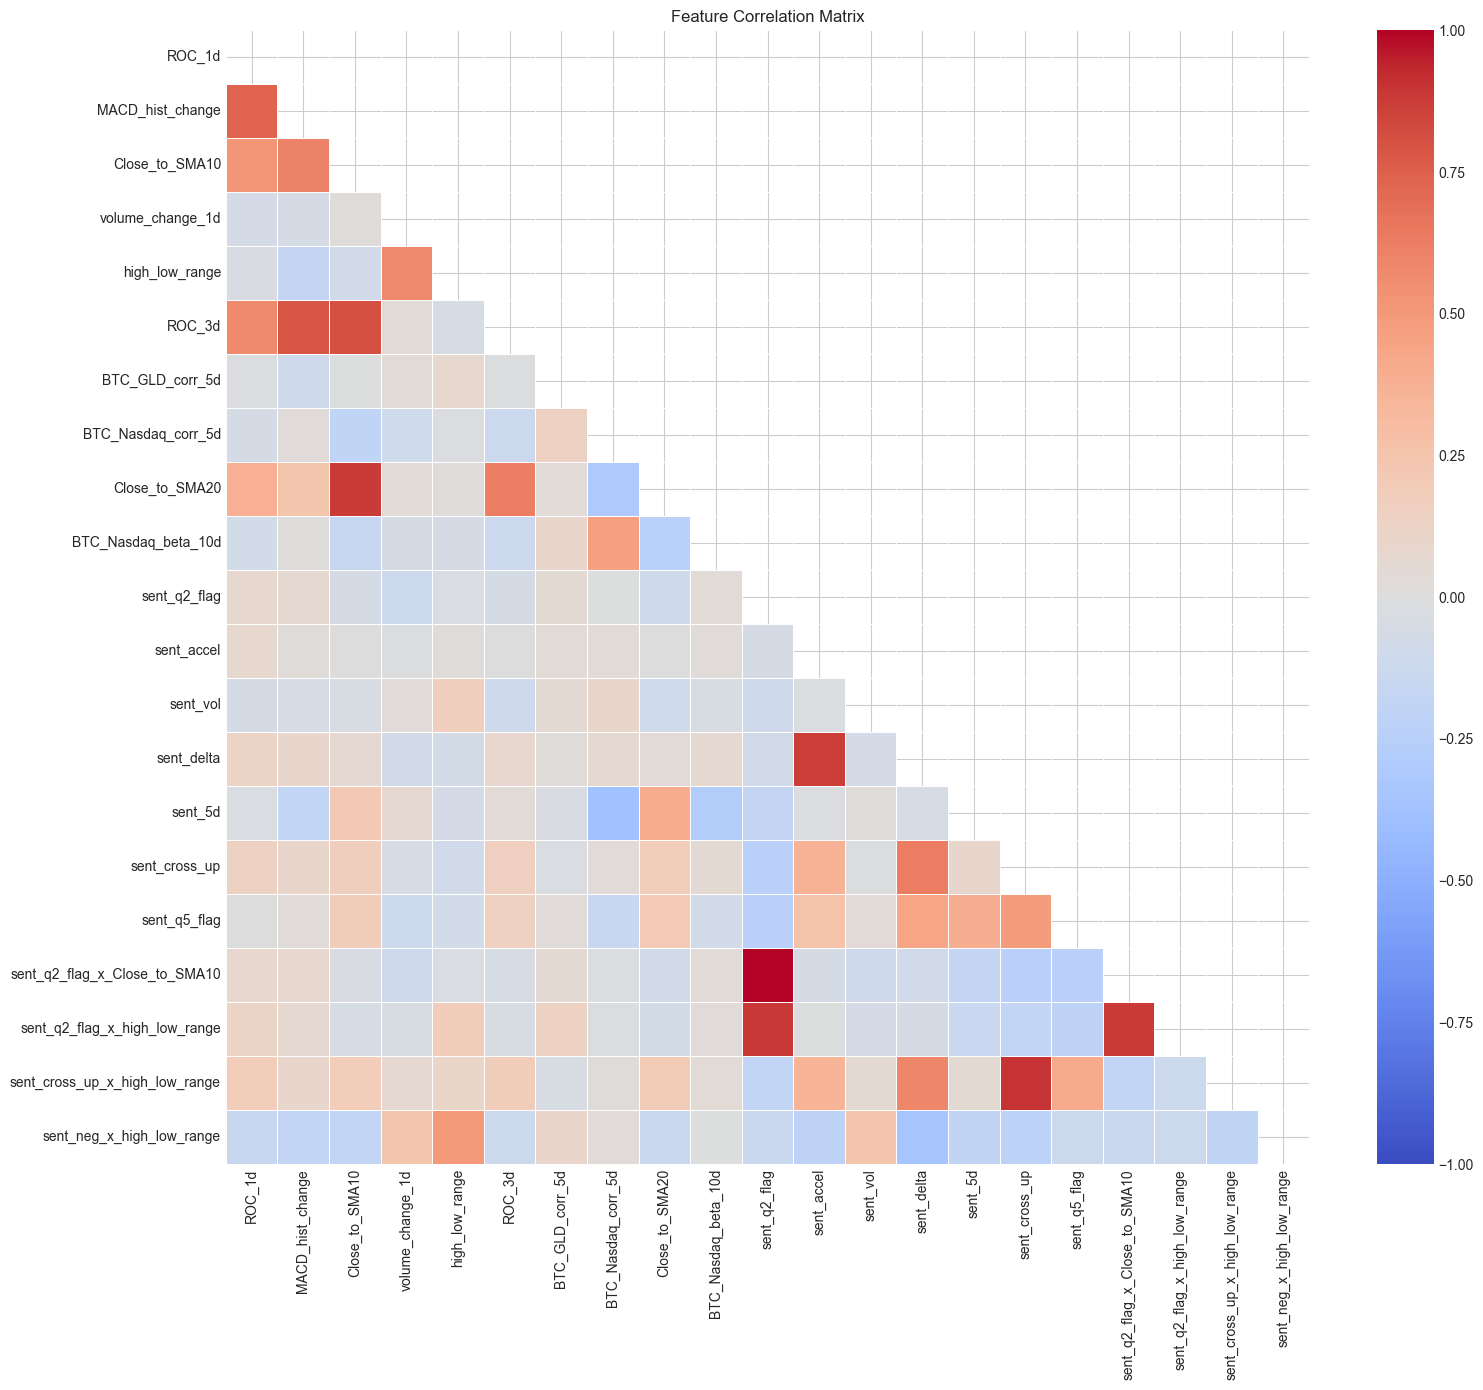

Highly correlated feature pairs (|r| > 0.7):
sent_q2_flag ~ sent_q2_flag_x_Close_to_SMA10: r = 0.9987
sent_cross_up ~ sent_cross_up_x_high_low_range: r = 0.9043
sent_q2_flag ~ sent_q2_flag_x_high_low_range: r = 0.8833
sent_q2_flag_x_Close_to_SMA10 ~ sent_q2_flag_x_high_low_range: r = 0.8822
Close_to_SMA10 ~ Close_to_SMA20: r = 0.8803
sent_accel ~ sent_delta: r = 0.8724
Close_to_SMA10 ~ ROC_3d: r = 0.8058
MACD_hist_change ~ ROC_3d: r = 0.7888
ROC_1d ~ MACD_hist_change: r = 0.7414

Computing Variance Inflation Factor (VIF) scores...

VIF Scores (values > 5 indicate potential multicollinearity):
                           Feature         VIF
10                    sent_q2_flag  502.947294
17   sent_q2_flag_x_Close_to_SMA10  496.655920
2                   Close_to_SMA10   28.872218
8                   Close_to_SMA20   26.539522
1                 MACD_hist_change   20.633029
13                      sent_delta   12.096515
15                   sent_cross_up    9.880506
19  sent_cross_up_x_high

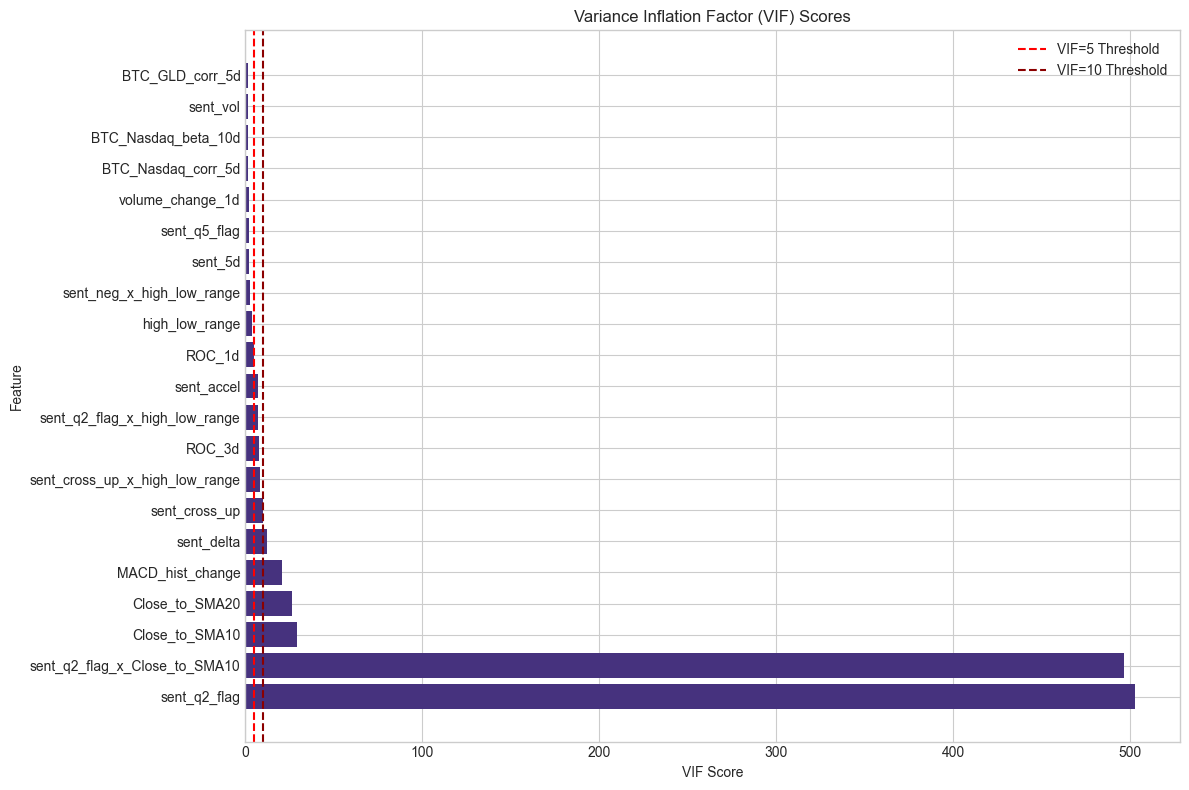

In [24]:
# 2.3 Multicollinearity Analysis
print("\n## 2.3 Multicollinearity Analysis")
print("-" * 50)

# Function to compute the correlation matrix and visualize it
def analyze_correlation_matrix(X, threshold=0.7):
    # Compute correlation matrix
    corr_matrix = X.corr()
    
    # Visualize correlation matrix
    plt.figure(figsize=(16, 14))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    heatmap = sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', 
                         vmin=-1, vmax=1, linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated feature pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                                       corr_matrix.iloc[i, j]))
    
    # Sort by absolute correlation value
    high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    print(f"Highly correlated feature pairs (|r| > {threshold}):")
    if high_corr_pairs:
        for feat1, feat2, corr in high_corr_pairs:
            print(f"{feat1} ~ {feat2}: r = {corr:.4f}")
    else:
        print("No feature pairs exceed the correlation threshold.")
    
    return high_corr_pairs, corr_matrix

# Function to compute VIF scores
def compute_vif(X):
    # Create DataFrame for results
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    
    # Calculate VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Sort by VIF value
    vif_data = vif_data.sort_values("VIF", ascending=False)
    
    return vif_data

# Analyze correlation matrix for training data
print("\nAnalyzing feature correlations...")
high_corr_pairs, corr_matrix = analyze_correlation_matrix(X_train, threshold=0.7)

# Compute VIF scores for training data
print("\nComputing Variance Inflation Factor (VIF) scores...")
try:
    # Scale the data first for better VIF interpretation
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                                 columns=X_train.columns, index=X_train.index)
    
    vif_results = compute_vif(X_train_scaled)
    
    print("\nVIF Scores (values > 5 indicate potential multicollinearity):")
    print(vif_results)
    
    # Visualize VIF scores
    plt.figure(figsize=(12, 8))
    plt.barh(vif_results["Feature"], vif_results["VIF"])
    plt.axvline(x=5, color='red', linestyle='--', label='VIF=5 Threshold')
    plt.axvline(x=10, color='darkred', linestyle='--', label='VIF=10 Threshold')
    plt.title('Variance Inflation Factor (VIF) Scores')
    plt.xlabel('VIF Score')
    plt.ylabel('Feature')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error computing VIF scores: {e}")
    print("This can happen if there's perfect multicollinearity or other numerical issues.")

In [25]:
# 2.4 Addressing Multicollinearity
print("\n## 2.4 Addressing Multicollinearity")
print("-" * 50)

# Identify problematic features based on VIF and correlation analysis
if 'vif_results' in locals():
    problematic_vif = vif_results[vif_results["VIF"] > 10]["Feature"].tolist()
    print(f"Features with VIF > 10: {problematic_vif}")
else:
    problematic_vif = []
    print("VIF analysis not available.")

# Get unique problematic features from correlation analysis
problematic_corr = set()
for feat1, feat2, _ in high_corr_pairs:
    problematic_corr.add(feat1)
    problematic_corr.add(feat2)

print(f"Features in highly correlated pairs: {list(problematic_corr)}")

# Identify features that appear in both VIF and correlation lists
common_problematic = set(problematic_vif).intersection(problematic_corr)
print(f"Features problematic in both analyses: {list(common_problematic)}")

# Analyze which features are most important to keep
print("\nAnalyzing which features to keep based on correlation with target:")

# For each highly correlated pair, check correlation with target
if high_corr_pairs:
    target_corr = X_train.corrwith(y_train).abs()
    
    print("\nFor each highly correlated pair, comparing correlation with target:")
    for feat1, feat2, _ in high_corr_pairs:
        corr1 = target_corr[feat1]
        corr2 = target_corr[feat2]
        print(f"{feat1} (r={corr1:.4f}) vs {feat2} (r={corr2:.4f})")
        if corr1 > corr2:
            print(f"  Recommendation: Keep {feat1}, consider dropping {feat2}")
        else:
            print(f"  Recommendation: Keep {feat2}, consider dropping {feat1}")

# Create sets of features to keep and drop
print("\nRecommendations for feature selection:")

# Create a set to track features we'll keep
features_to_keep = set(X_train.columns)

# For each highly correlated pair, keep the one with higher correlation to target
if high_corr_pairs:
    features_to_drop = set()
    for feat1, feat2, _ in high_corr_pairs:
        # If both features are still in consideration
        if feat1 in features_to_keep and feat2 in features_to_keep:
            corr1 = abs(target_corr[feat1])
            corr2 = abs(target_corr[feat2])
            
            # Keep the feature with higher correlation to target
            if corr1 <= corr2:
                features_to_drop.add(feat1)
            else:
                features_to_drop.add(feat2)
    
    # Remove features to drop from features to keep
    features_to_keep = features_to_keep - features_to_drop
    
    print(f"Recommended features to drop: {list(features_to_drop)}")
    print(f"Number of features to keep: {len(features_to_keep)} (out of {X_train.shape[1]} total)")
    
    # Check how many technical vs sentiment features we're keeping
    kept_technical = [f for f in features_to_keep if not f.startswith('sent_')]
    kept_sentiment = [f for f in features_to_keep if f.startswith('sent_')]
    
    print(f"Technical features kept: {len(kept_technical)} out of {len(technical_features)}")
    print(f"Sentiment features kept: {len(kept_sentiment)} out of {len(sentiment_features)}")
else:
    print("No features need to be dropped based on correlation analysis.")

# Create reduced feature sets
X_train_reduced = X_train[list(features_to_keep)]
X_test_reduced = X_test[list(features_to_keep)]

print(f"\nReduced feature set size: {X_train_reduced.shape[1]} features")
print("Reduced feature set:")
for i, feature in enumerate(X_train_reduced.columns):
    print(f"{i+1}. {feature}")


## 2.4 Addressing Multicollinearity
--------------------------------------------------
Features with VIF > 10: ['sent_q2_flag', 'sent_q2_flag_x_Close_to_SMA10', 'Close_to_SMA10', 'Close_to_SMA20', 'MACD_hist_change', 'sent_delta']
Features in highly correlated pairs: ['sent_q2_flag_x_Close_to_SMA10', 'Close_to_SMA20', 'sent_q2_flag', 'sent_cross_up_x_high_low_range', 'ROC_1d', 'Close_to_SMA10', 'ROC_3d', 'sent_delta', 'MACD_hist_change', 'sent_accel', 'sent_q2_flag_x_high_low_range', 'sent_cross_up']
Features problematic in both analyses: ['sent_q2_flag_x_Close_to_SMA10', 'Close_to_SMA20', 'sent_q2_flag', 'Close_to_SMA10', 'sent_delta', 'MACD_hist_change']

Analyzing which features to keep based on correlation with target:

For each highly correlated pair, comparing correlation with target:
sent_q2_flag (r=0.1326) vs sent_q2_flag_x_Close_to_SMA10 (r=0.1343)
  Recommendation: Keep sent_q2_flag_x_Close_to_SMA10, consider dropping sent_q2_flag
sent_cross_up (r=0.0015) vs sent_cross_up_x_


## 2.5 Feature Scaling
--------------------------------------------------
Standardizing features...
Feature scaling complete.
Scaled training set shape: (210, 14)
Scaled testing set shape: (53, 14)


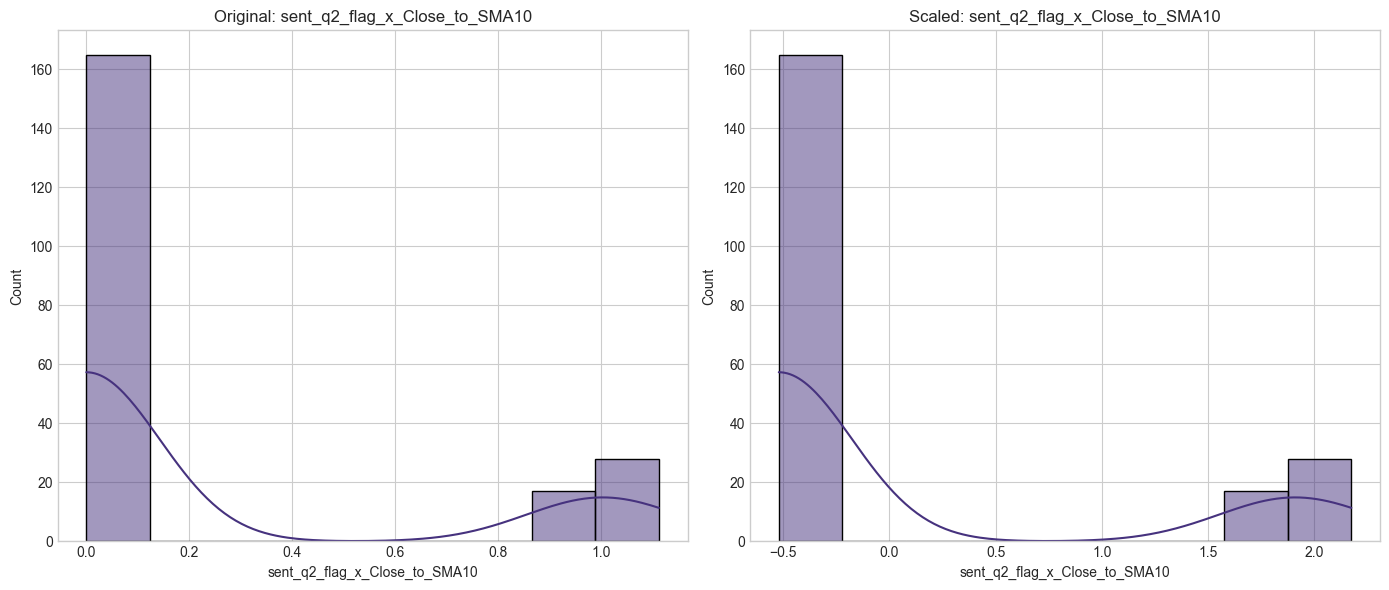

In [26]:
# 2.5 Feature Scaling
print("\n## 2.5 Feature Scaling")
print("-" * 50)

# Standardize features
print("Standardizing features...")
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_reduced), 
                             columns=X_train_reduced.columns, index=X_train_reduced.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_reduced), 
                            columns=X_test_reduced.columns, index=X_test_reduced.index)

print("Feature scaling complete.")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled testing set shape: {X_test_scaled.shape}")

# Check the distribution of scaled features
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(X_train_reduced.iloc[:, 0], kde=True)
plt.title(f'Original: {X_train_reduced.columns[0]}')

plt.subplot(1, 2, 2)
sns.histplot(X_train_scaled.iloc[:, 0], kde=True)
plt.title(f'Scaled: {X_train_scaled.columns[0]}')

plt.tight_layout()
plt.show()

In [27]:
# 2.6 Prepare for Modeling
print("\n## 2.6 Prepare for Modeling")
print("-" * 50)

print("""
Data preparation is complete. We have:

1. **Created time-based train-test splits** that respect the temporal nature of the data
2. **Analyzed multicollinearity** among features using:
   - Correlation matrix analysis
   - Variance Inflation Factor (VIF) calculations
3. **Selected a reduced feature set** by addressing multicollinearity issues
4. **Scaled features** to ensure all variables are on the same scale

The data is now ready for modeling. In the next step, we will:
1. Train baseline models on the prepared data
2. Evaluate their performance using proper time series cross-validation
3. Analyze the results to establish performance benchmarks
""")

# Save prepared datasets for the next modeling step
try:
    # Save reduced and scaled datasets
    X_train_scaled.to_csv('X_train_scaled.csv')
    X_test_scaled.to_csv('X_test_scaled.csv')
    y_train.to_csv('y_train.csv')
    y_test.to_csv('y_test.csv')
    
    # Also save column names for reference
    pd.Series(X_train_scaled.columns).to_csv('feature_names.csv', index=False)
    
    print("\nPrepared datasets saved to CSV files for use in the next modeling step.")
except Exception as e:
    print(f"Error saving datasets: {e}")
    print("Will continue without saving files.")


## 2.6 Prepare for Modeling
--------------------------------------------------

Data preparation is complete. We have:

1. **Created time-based train-test splits** that respect the temporal nature of the data
2. **Analyzed multicollinearity** among features using:
   - Correlation matrix analysis
   - Variance Inflation Factor (VIF) calculations
3. **Selected a reduced feature set** by addressing multicollinearity issues
4. **Scaled features** to ensure all variables are on the same scale

The data is now ready for modeling. In the next step, we will:
1. Train baseline models on the prepared data
2. Evaluate their performance using proper time series cross-validation
3. Analyze the results to establish performance benchmarks


Prepared datasets saved to CSV files for use in the next modeling step.


# Final Multicollinearity Check for Bitcoin Price Direction Prediction
Loaded scaled datasets from CSV files

## 1. Correlation Matrix for Reduced Feature Set
--------------------------------------------------


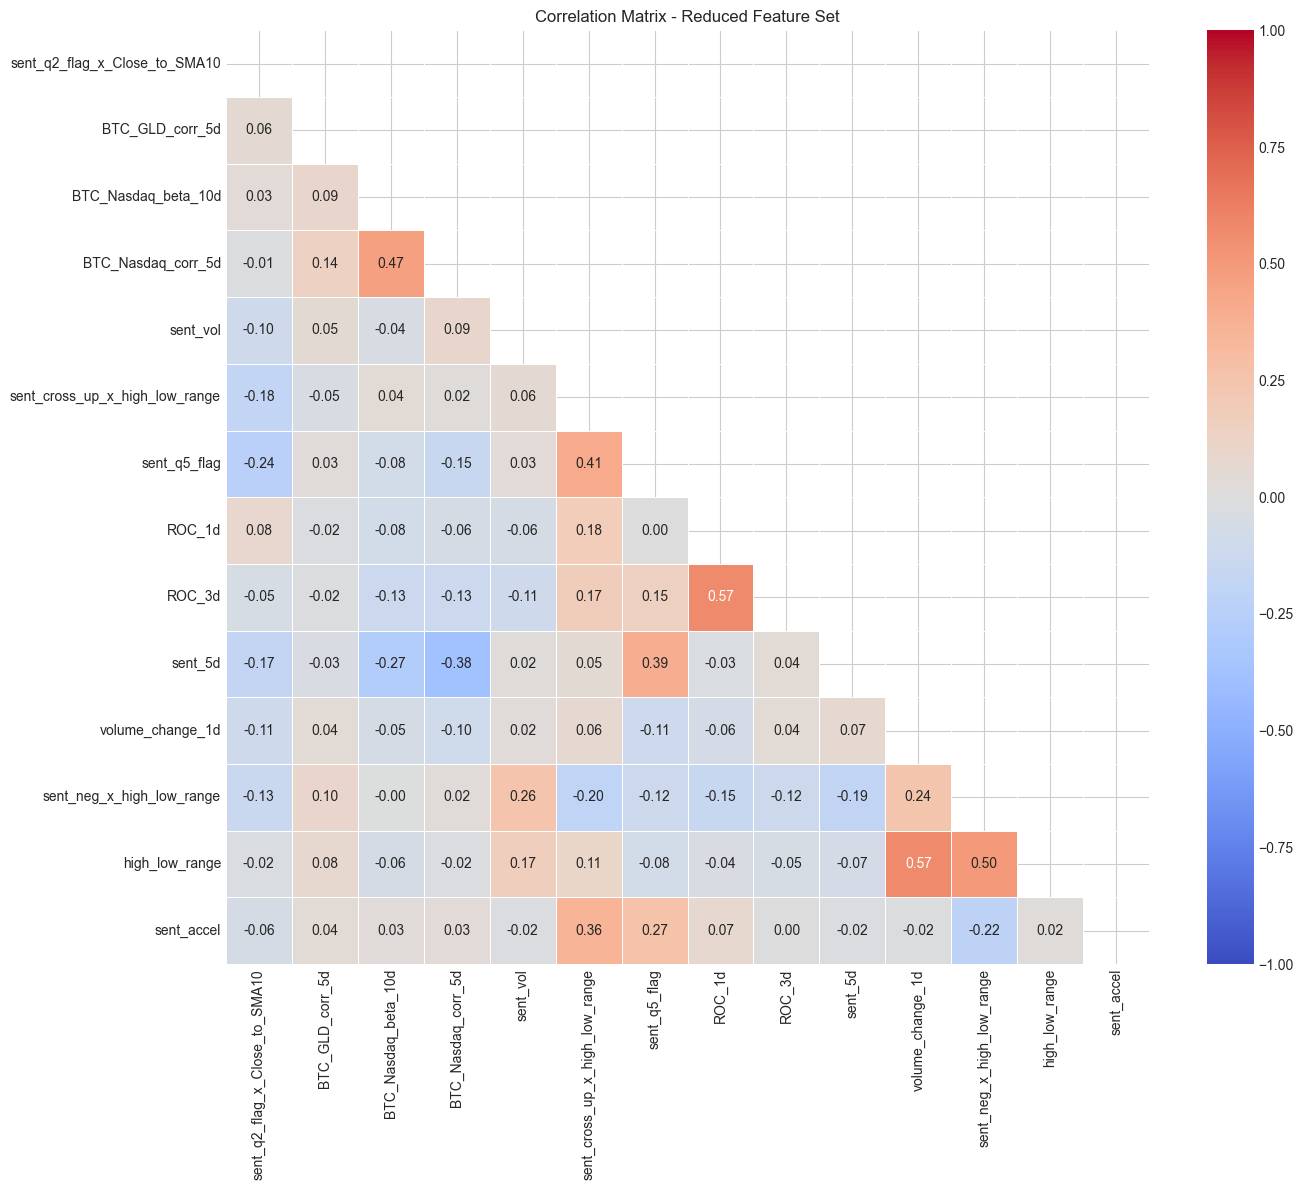

Remaining high correlations (|r| > 0.7):
No feature pairs exceed the correlation threshold. ✓

## 2. VIF Analysis for Reduced Feature Set
--------------------------------------------------
VIF Scores for Reduced Feature Set:
                           Feature       VIF
12                  high_low_range  2.062644
11       sent_neg_x_high_low_range  1.781977
6                     sent_q5_flag  1.664588
10                volume_change_1d  1.646108
8                           ROC_3d  1.643707
7                           ROC_1d  1.611963
9                          sent_5d  1.564210
5   sent_cross_up_x_high_low_range  1.557222
3               BTC_Nasdaq_corr_5d  1.480617
2              BTC_Nasdaq_beta_10d  1.338314
13                      sent_accel  1.260512
0    sent_q2_flag_x_Close_to_SMA10  1.197725
4                         sent_vol  1.133898
1                  BTC_GLD_corr_5d  1.054632

No features exceed the VIF threshold of 10. ✓


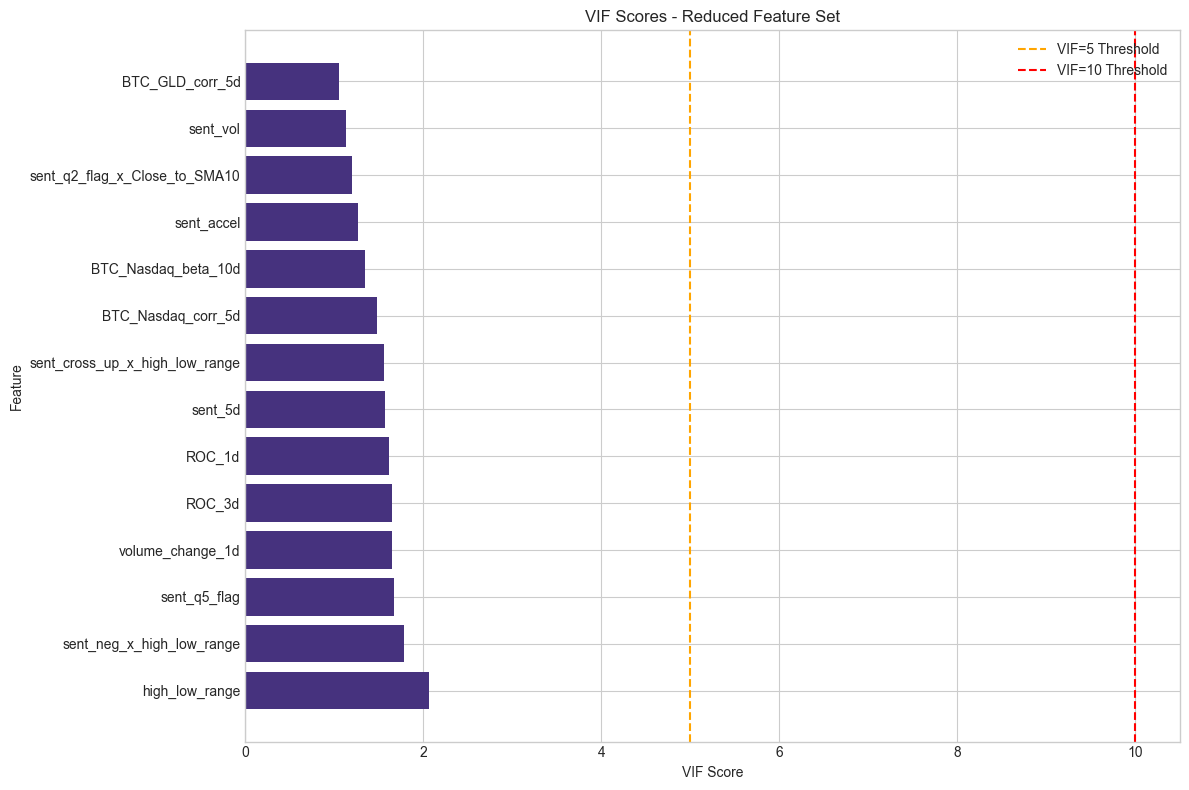


## 3. Final Assessment
--------------------------------------------------

✅ MULTICOLLINEARITY SUCCESSFULLY ADDRESSED

The reduced feature set shows no concerning levels of multicollinearity:
- No feature pairs with correlation above 0.7
- No features with VIF scores above 10

The dataset is now ready for modeling!
    

Ready to proceed with baseline modeling. ✓


In [28]:
print("# Final Multicollinearity Check for Bitcoin Price Direction Prediction")
print("=" * 80)

# Load the reduced and scaled datasets
try:
    # Try to load from CSV files
    X_train_scaled = pd.read_csv('X_train_scaled.csv', index_col=0)
    feature_names = pd.read_csv('feature_names.csv', header=None).iloc[:, 0].tolist()
    
    print("Loaded scaled datasets from CSV files")
except Exception as e:
    # If loading fails, try to use variables from memory
    if 'X_train_scaled' in locals() and 'X_train_reduced' in locals():
        print("Using datasets from current session")
    else:
        print(f"Error loading datasets: {e}")
        print("Please run the previous step first to create the required datasets")
        raise

# 1. Correlation Matrix for Reduced Feature Set
print("\n## 1. Correlation Matrix for Reduced Feature Set")
print("-" * 50)

# Compute and visualize correlation matrix
corr_matrix = X_train_scaled.corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
           vmin=-1, vmax=1, linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix - Reduced Feature Set')
plt.tight_layout()
plt.show()

# Check for remaining high correlations
high_corr_threshold = 0.7
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                                   corr_matrix.iloc[i, j]))

# Sort by absolute correlation value
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print(f"Remaining high correlations (|r| > {high_corr_threshold}):")
if high_corr_pairs:
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1} ~ {feat2}: r = {corr:.4f}")
else:
    print("No feature pairs exceed the correlation threshold. ✓")

# 2. VIF Analysis for Reduced Feature Set
print("\n## 2. VIF Analysis for Reduced Feature Set")
print("-" * 50)

# Calculate VIF for each feature
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values("VIF", ascending=False)

try:
    # Calculate VIF scores
    vif_results = calculate_vif(X_train_scaled)
    
    print("VIF Scores for Reduced Feature Set:")
    print(vif_results)
    
    # Check for high VIF values
    high_vif_threshold = 10
    high_vif_features = vif_results[vif_results["VIF"] > high_vif_threshold]
    
    if len(high_vif_features) > 0:
        print(f"\nFeatures still showing high multicollinearity (VIF > {high_vif_threshold}):")
        print(high_vif_features)
    else:
        print(f"\nNo features exceed the VIF threshold of {high_vif_threshold}. ✓")
    
    # Visualize VIF scores
    plt.figure(figsize=(12, 8))
    plt.barh(vif_results["Feature"], vif_results["VIF"])
    plt.axvline(x=5, color='orange', linestyle='--', label='VIF=5 Threshold')
    plt.axvline(x=10, color='red', linestyle='--', label='VIF=10 Threshold')
    plt.title('VIF Scores - Reduced Feature Set')
    plt.xlabel('VIF Score')
    plt.ylabel('Feature')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error computing VIF scores: {e}")

# 3. Final Assessment
print("\n## 3. Final Assessment")
print("-" * 50)

# Decision based on both correlation and VIF analysis
if not high_corr_pairs and ('high_vif_features' in locals() and len(high_vif_features) == 0):
    print("""
✅ MULTICOLLINEARITY SUCCESSFULLY ADDRESSED

The reduced feature set shows no concerning levels of multicollinearity:
- No feature pairs with correlation above 0.7
- No features with VIF scores above 10

The dataset is now ready for modeling!
    """)
elif not high_corr_pairs:
    print("""
⚠️ PARTIAL IMPROVEMENT IN MULTICOLLINEARITY

While there are no highly correlated feature pairs, some features still show elevated VIF scores.
This mild multicollinearity should be manageable with regularization techniques in modeling.

Recommendation: Proceed with modeling using regularization (L1/L2) to handle remaining multicollinearity.
    """)
elif 'high_vif_features' in locals() and len(high_vif_features) == 0:
    print("""
⚠️ PARTIAL IMPROVEMENT IN MULTICOLLINEARITY

While VIF scores are under control, some feature pairs still show high correlations.
This may indicate remaining redundancy that could affect model interpretation but likely won't harm performance.

Recommendation: Proceed with modeling, but be cautious when interpreting feature importance.
    """)
else:
    print("""
⚠️ MULTICOLLINEARITY STILL PRESENT

Despite feature reduction, some multicollinearity issues remain in both correlation and VIF metrics.

Recommendation: Consider additional feature selection or use models that handle multicollinearity well 
(e.g., Lasso regression, elastic net, tree-based methods).
    """)

print("\nReady to proceed with baseline modeling. ✓")

ML modeling starts here!

In [29]:
print("\n## 3.1 Loading the Prepared Datasets")
print("-" * 50)

try:
    # Load from saved CSV files
    X_train_scaled = pd.read_csv('X_train_scaled.csv', index_col=0, parse_dates=True)
    X_test_scaled = pd.read_csv('X_test_scaled.csv', index_col=0, parse_dates=True)
    y_train = pd.read_csv('y_train.csv', index_col=0)
    y_test = pd.read_csv('y_test.csv', index_col=0)
    
    print("Datasets loaded successfully from CSV files")
    print(f"Training set: {X_train_scaled.shape[0]} samples, {X_train_scaled.shape[1]} features")
    print(f"Testing set: {X_test_scaled.shape[0]} samples")
except Exception as e:
    print(f"Error loading datasets: {e}")
    
# Show features being used
print("\nFeatures in the model:")
for i, col in enumerate(X_train_scaled.columns):
    print(f"{i+1}. {col}")

# Verify class distribution
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True) * 100)


## 3.1 Loading the Prepared Datasets
--------------------------------------------------
Datasets loaded successfully from CSV files
Training set: 210 samples, 14 features
Testing set: 53 samples

Features in the model:
1. sent_q2_flag_x_Close_to_SMA10
2. BTC_GLD_corr_5d
3. BTC_Nasdaq_beta_10d
4. BTC_Nasdaq_corr_5d
5. sent_vol
6. sent_cross_up_x_high_low_range
7. sent_q5_flag
8. ROC_1d
9. ROC_3d
10. sent_5d
11. volume_change_1d
12. sent_neg_x_high_low_range
13. high_low_range
14. sent_accel

Class distribution in training set:
target_nextday
0                 50.47619
1                 49.52381
Name: proportion, dtype: float64

Class distribution in test set:
target_nextday
1                 50.943396
0                 49.056604
Name: proportion, dtype: float64


In [30]:
# 3.2 Define evaluation metrics and utilities
print("\n## 3.2 Evaluation Framework")
print("-" * 50)

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Trains a model and evaluates it on the test set with multiple metrics.
    
    Parameters:
    -----------
    model : scikit-learn model
        The model to train and evaluate
    X_train, X_test : pandas DataFrame
        Training and testing features
    y_train, y_test : pandas Series
        Training and testing target variable
    model_name : str
        Name of the model for display purposes
        
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics and the trained model
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Probability predictions (for ROC AUC)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        y_prob = y_pred  # Use predicted classes if probabilities not available
        roc_auc = roc_auc_score(y_test, y_prob)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Classification report
    report = classification_report(y_test, y_pred)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    print("\nConfusion Matrix:")
    conf_matrix = pd.DataFrame(cm, 
                              index=['Actual Down', 'Actual Up'],
                              columns=['Predicted Down', 'Predicted Up'])
    print(conf_matrix)
    
    print("\nClassification Report:")
    print(report)
    
    # Return results dictionary
    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

def plot_confusion_matrix(confusion_matrix, model_name):
    """Plot a pretty confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Predicted Down', 'Predicted Up'],
               yticklabels=['Actual Down', 'Actual Up'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_test, y_prob, model_name):
    """Plot ROC curve."""
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def time_series_cv_scores(model, X, y, cv=5):
    """
    Perform time series cross-validation and return scores.
    
    Parameters:
    -----------
    model : scikit-learn model
        The model to evaluate
    X : pandas DataFrame
        Features
    y : pandas Series
        Target variable
    cv : int
        Number of cross-validation folds
        
    Returns:
    --------
    dict
        Dictionary containing cross-validation scores
    """
    tscv = TimeSeriesSplit(n_splits=cv)
    
    # Store scores
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    roc_aucs = []
    
    print(f"\nPerforming {cv}-fold time series cross-validation:")
    
    # For each fold
    fold = 1
    for train_idx, test_idx in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train model
        model.fit(X_train_cv, y_train_cv)
        
        # Predict
        y_pred = model.predict(X_test_cv)
        
        # For ROC AUC
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test_cv)[:, 1]
        else:
            y_prob = y_pred
        
        # Calculate metrics
        accuracies.append(accuracy_score(y_test_cv, y_pred))
        precisions.append(precision_score(y_test_cv, y_pred))
        recalls.append(recall_score(y_test_cv, y_pred))
        f1s.append(f1_score(y_test_cv, y_pred))
        roc_aucs.append(roc_auc_score(y_test_cv, y_prob))
        
        print(f"Fold {fold}: Accuracy = {accuracies[-1]:.4f}, ROC AUC = {roc_aucs[-1]:.4f}")
        fold += 1
    
    # Calculate mean and std
    results = {
        'accuracy': (np.mean(accuracies), np.std(accuracies)),
        'precision': (np.mean(precisions), np.std(precisions)),
        'recall': (np.mean(recalls), np.std(recalls)),
        'f1': (np.mean(f1s), np.std(f1s)),
        'roc_auc': (np.mean(roc_aucs), np.std(roc_aucs))
    }
    
    print("\nCross-validation results:")
    for metric, (mean, std) in results.items():
        print(f"{metric.capitalize()}: {mean:.4f} (±{std:.4f})")
    
    return results

def plot_feature_importance(model, feature_names, title):
    """Plot feature importance for a trained model."""
    if hasattr(model, 'feature_importances_'):  # For tree-based models
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.bar(range(len(importances)), importances[indices])
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
        plt.title(title)
        plt.tight_layout()
        plt.show()
        
        return {feature_names[i]: importances[i] for i in indices}
    else:
        return None

def analyze_feature_importance(model, X, y, feature_names, model_name):
    """
    Analyze feature importance using both model-based and permutation importance.
    Also categorizes features as technical or sentiment for comparison.
    """
    # Get model-based feature importance if available
    if hasattr(model, 'feature_importances_'):
        model_importances = model.feature_importances_
        model_indices = np.argsort(model_importances)[::-1]
        
        # Create DataFrame for easy manipulation
        model_importance_df = pd.DataFrame({
            'Feature': [feature_names[i] for i in model_indices],
            'Importance': model_importances[model_indices],
            'Type': ['Sentiment' if feature_names[i].startswith('sent_') else 'Technical' 
                    for i in model_indices]
        })
        
        # Plot model-based importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', hue='Type', 
                   data=model_importance_df, dodge=False)
        plt.title(f'{model_name} - Feature Importance')
        plt.tight_layout()
        plt.show()
        
        # Summarize by feature type
        type_summary = model_importance_df.groupby('Type')['Importance'].sum()
        
        # Plot pie chart of importance by type
        plt.figure(figsize=(8, 8))
        plt.pie(type_summary, labels=type_summary.index, autopct='%1.1f%%',
               shadow=True, startangle=90)
        plt.title(f'{model_name} - Importance by Feature Type')
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
        
        print(f"\nFeature importance by type:")
        for type_name, importance in type_summary.items():
            print(f"{type_name} features: {importance:.4f} ({importance*100:.1f}%)")
        
        # Return top features
        return model_importance_df
    else:
        # Permutation importance as fallback
        result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
        perm_importance = result.importances_mean
        perm_indices = np.argsort(perm_importance)[::-1]
        
        # Create DataFrame
        perm_importance_df = pd.DataFrame({
            'Feature': [feature_names[i] for i in perm_indices],
            'Importance': perm_importance[perm_indices],
            'Type': ['Sentiment' if feature_names[i].startswith('sent_') else 'Technical' 
                    for i in perm_indices]
        })
        
        # Plot permutation importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', hue='Type', 
                   data=perm_importance_df, dodge=False)
        plt.title(f'{model_name} - Permutation Feature Importance')
        plt.tight_layout()
        plt.show()
        
        # Return top features
        return perm_importance_df


## 3.2 Evaluation Framework
--------------------------------------------------



## 3.3 Logistic Regression Baseline
--------------------------------------------------

Logistic Regression Results:
Accuracy: 0.5660
Precision: 0.5833
Recall: 0.5185
F1 Score: 0.5490
ROC AUC: 0.6125

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down              16            10
Actual Up                13            14

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.62      0.58        26
           1       0.58      0.52      0.55        27

    accuracy                           0.57        53
   macro avg       0.57      0.57      0.57        53
weighted avg       0.57      0.57      0.57        53



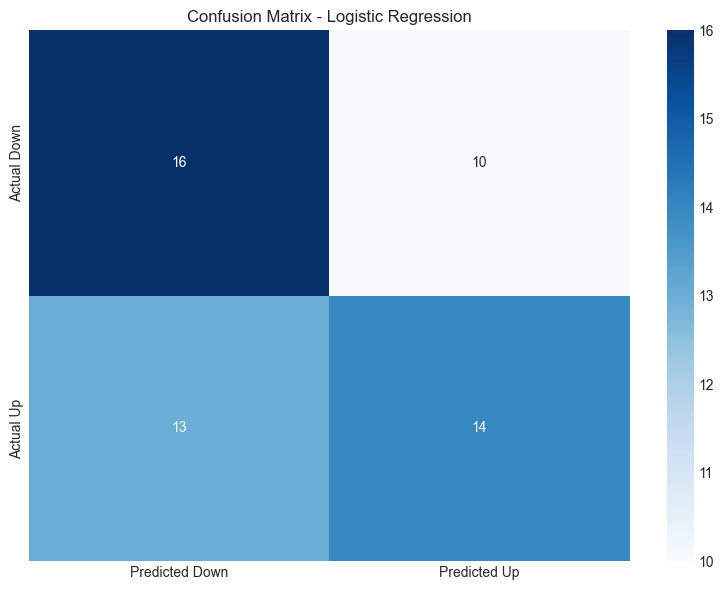

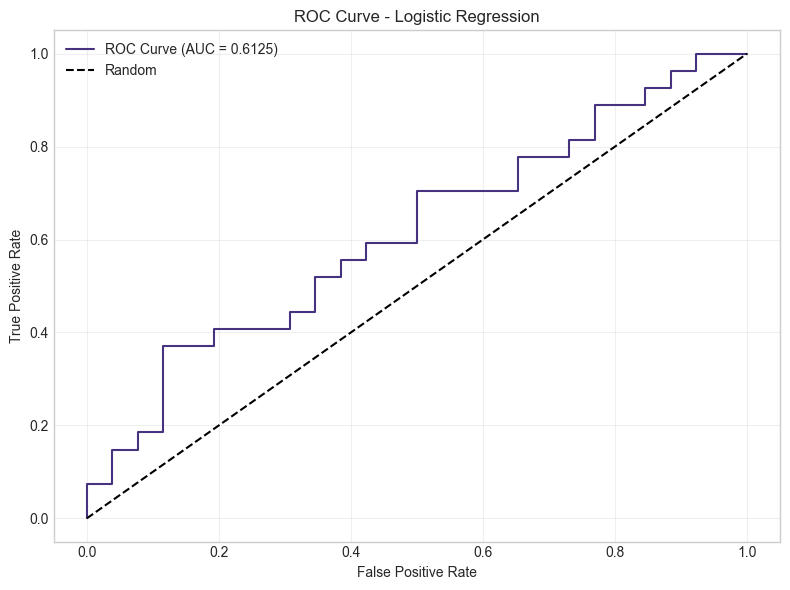


Performing 5-fold time series cross-validation:
Fold 1: Accuracy = 0.4857, ROC AUC = 0.4281
Fold 2: Accuracy = 0.5714, ROC AUC = 0.5752
Fold 3: Accuracy = 0.5143, ROC AUC = 0.5136
Fold 4: Accuracy = 0.5714, ROC AUC = 0.5884
Fold 5: Accuracy = 0.5143, ROC AUC = 0.5816

Cross-validation results:
Accuracy: 0.5314 (±0.0343)
Precision: 0.5268 (±0.0822)
Recall: 0.5868 (±0.1195)
F1: 0.5375 (±0.0337)
Roc_auc: 0.5374 (±0.0608)


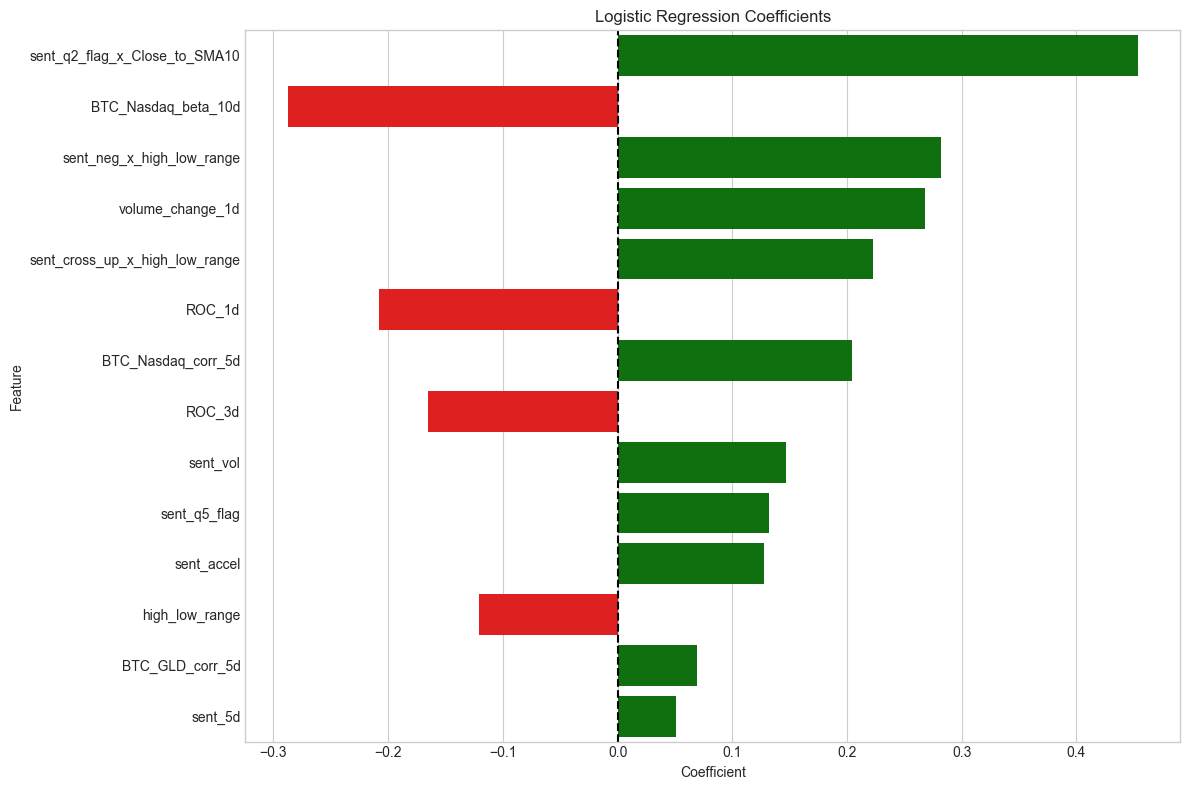


Feature importance by type:
Sentiment features: 1.4153 (51.7%)
Technical features: 1.3237 (48.3%)


In [31]:
# 3.3 Logistic Regression (Baseline Model)
print("\n## 3.3 Logistic Regression Baseline")
print("-" * 50)

# Define logistic regression model with regularization
lr_model = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', random_state=42)

# Train and evaluate
lr_results = evaluate_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test, 
                          "Logistic Regression")

# Plot confusion matrix
plot_confusion_matrix(lr_results['confusion_matrix'], "Logistic Regression")

# Plot ROC curve
plot_roc_curve(y_test, lr_results['y_prob'], "Logistic Regression")

# Perform time series cross-validation
lr_cv_results = time_series_cv_scores(LogisticRegression(C=1.0, penalty='l2', 
                                                      solver='liblinear', random_state=42),
                                   X_train_scaled, y_train, cv=5)

# Model interpretation
if hasattr(lr_model, 'coef_'):
    # Extract coefficients
    coefficients = lr_model.coef_[0]
    feature_importance = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients),
        'Type': ['Sentiment' if col.startswith('sent_') else 'Technical' 
                for col in X_train_scaled.columns]
    }).sort_values('Abs_Coefficient', ascending=False)
    
    # Plot coefficients
    plt.figure(figsize=(12, 8))
    colors = ['green' if c > 0 else 'red' for c in feature_importance['Coefficient']]
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette=colors)
    plt.title('Logistic Regression Coefficients')
    plt.axvline(x=0, color='k', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # Feature importance by type
    type_importance = feature_importance.groupby('Type')['Abs_Coefficient'].sum()
    total_importance = type_importance.sum()
    
    print("\nFeature importance by type:")
    for type_name, importance in type_importance.items():
        print(f"{type_name} features: {importance:.4f} ({importance/total_importance*100:.1f}%)")


## 3.4 Decision Tree
--------------------------------------------------

Decision Tree Results:
Accuracy: 0.4151
Precision: 0.4412
Recall: 0.5556
F1 Score: 0.4918
ROC AUC: 0.3932

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down               7            19
Actual Up                12            15

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.27      0.31        26
           1       0.44      0.56      0.49        27

    accuracy                           0.42        53
   macro avg       0.40      0.41      0.40        53
weighted avg       0.41      0.42      0.40        53



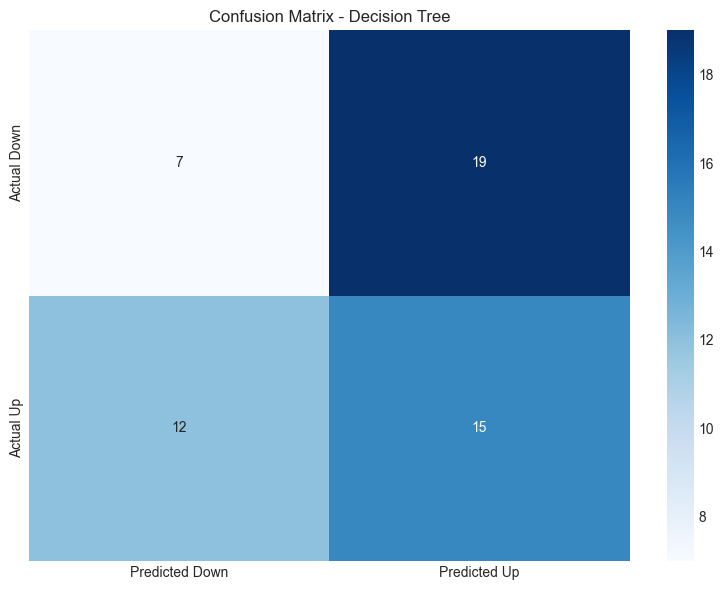

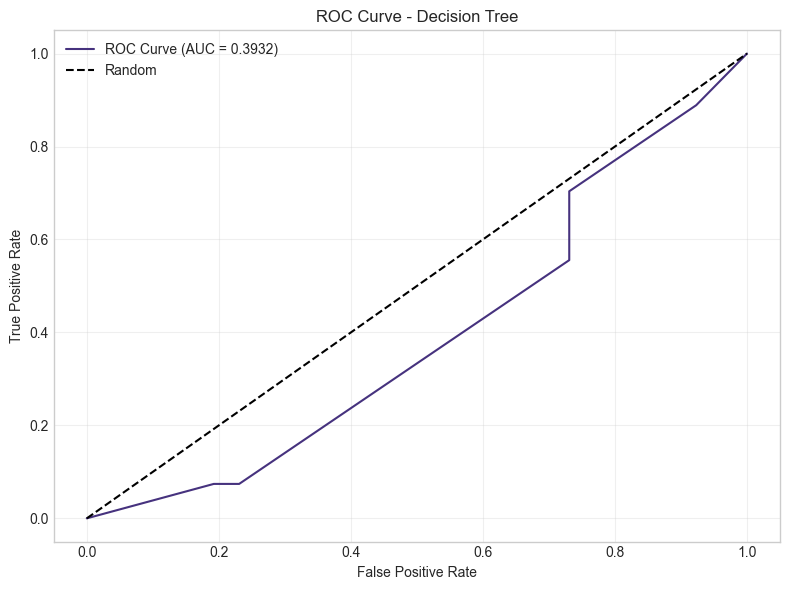


Performing 5-fold time series cross-validation:
Fold 1: Accuracy = 0.4857, ROC AUC = 0.4869
Fold 2: Accuracy = 0.3714, ROC AUC = 0.3660
Fold 3: Accuracy = 0.4000, ROC AUC = 0.3299
Fold 4: Accuracy = 0.6000, ROC AUC = 0.5918
Fold 5: Accuracy = 0.6286, ROC AUC = 0.7092

Cross-validation results:
Accuracy: 0.4971 (±0.1032)
Precision: 0.4570 (±0.1877)
Recall: 0.4309 (±0.1754)
F1: 0.4389 (±0.1706)
Roc_auc: 0.4968 (±0.1408)


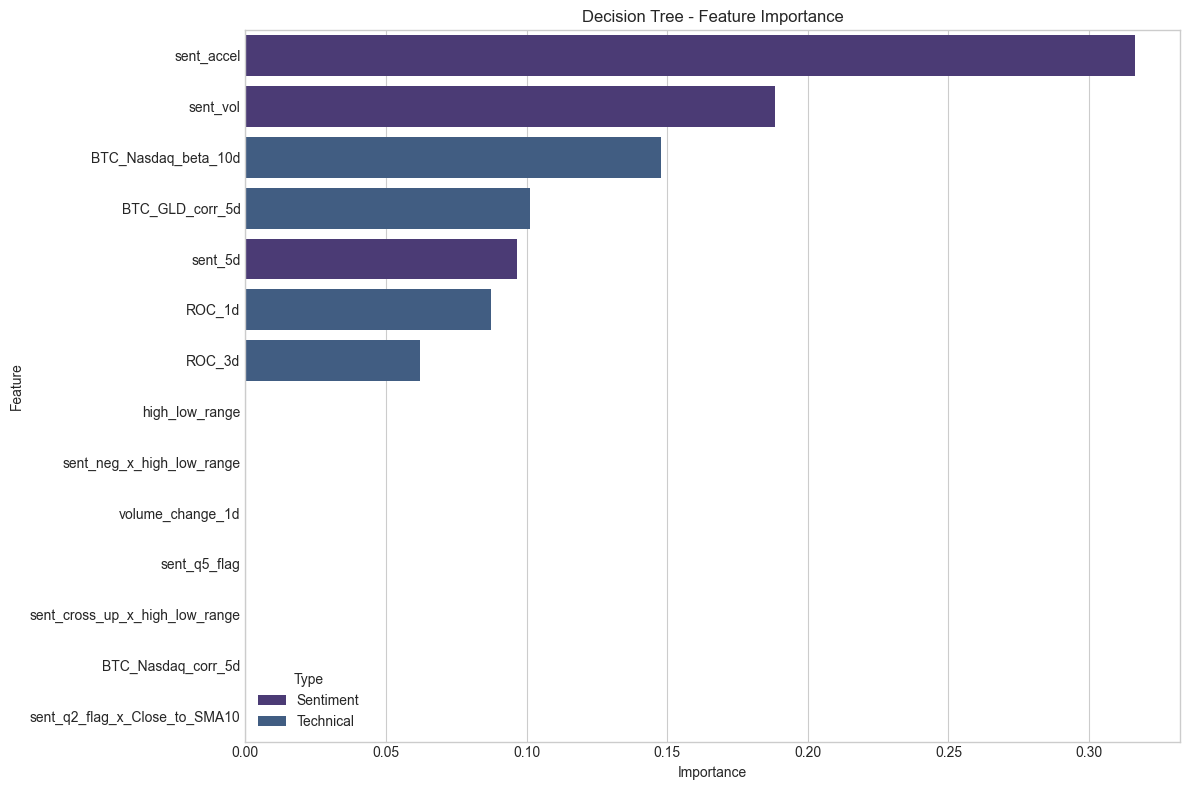

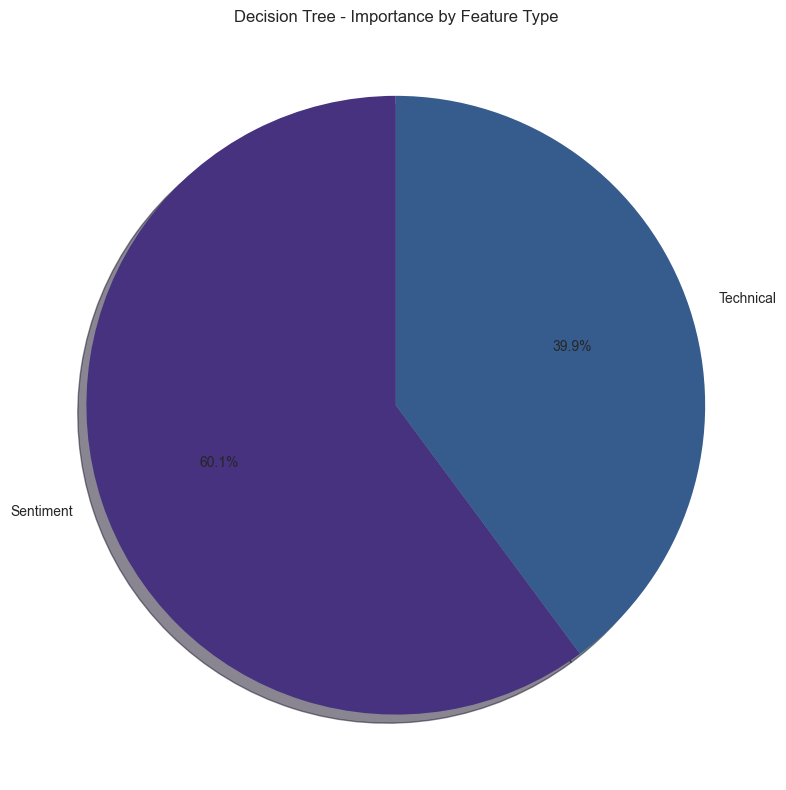


Feature importance by type:
Sentiment features: 0.6015 (60.1%)
Technical features: 0.3985 (39.9%)


In [32]:
# 3.4 Decision Tree
print("\n## 3.4 Decision Tree")
print("-" * 50)

# Define decision tree model
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)

# Train and evaluate
dt_results = evaluate_model(dt_model, X_train_scaled, X_test_scaled, y_train, y_test, 
                          "Decision Tree")

# Plot confusion matrix
plot_confusion_matrix(dt_results['confusion_matrix'], "Decision Tree")

# Plot ROC curve
plot_roc_curve(y_test, dt_results['y_prob'], "Decision Tree")

# Time series cross-validation
dt_cv_results = time_series_cv_scores(DecisionTreeClassifier(max_depth=4, random_state=42),
                                    X_train_scaled, y_train, cv=5)

# Feature importance
feature_importance_dt = analyze_feature_importance(dt_model, X_train_scaled, y_train, 
                                             X_train_scaled.columns, "Decision Tree")


## 3.5 Random Forest
--------------------------------------------------

Random Forest Results:
Accuracy: 0.4717
Precision: 0.4762
Recall: 0.3704
F1 Score: 0.4167
ROC AUC: 0.4672

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down              15            11
Actual Up                17            10

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.58      0.52        26
           1       0.48      0.37      0.42        27

    accuracy                           0.47        53
   macro avg       0.47      0.47      0.47        53
weighted avg       0.47      0.47      0.47        53



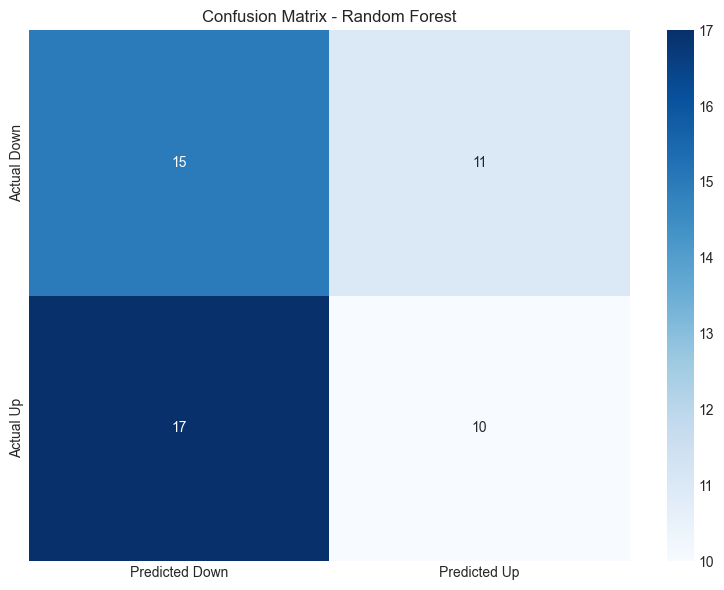

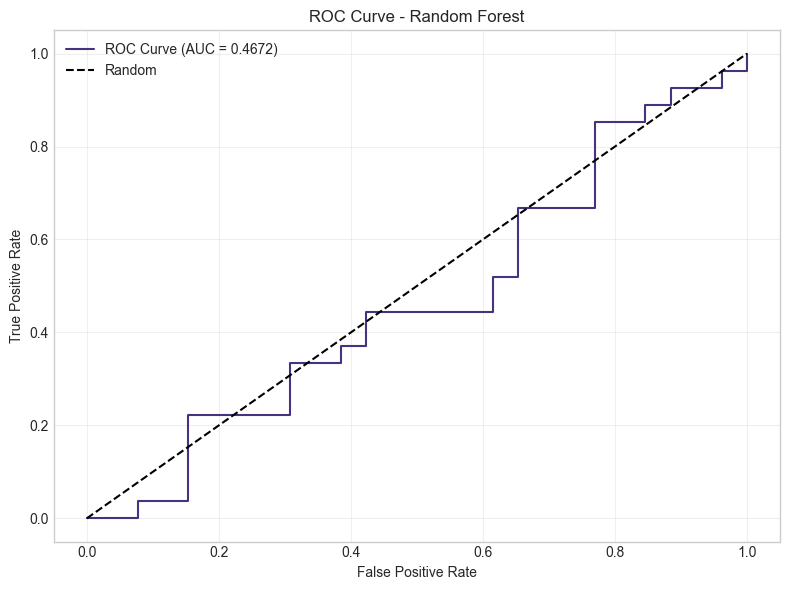


Performing 5-fold time series cross-validation:
Fold 1: Accuracy = 0.3143, ROC AUC = 0.3725
Fold 2: Accuracy = 0.4857, ROC AUC = 0.5948
Fold 3: Accuracy = 0.5143, ROC AUC = 0.6769
Fold 4: Accuracy = 0.7143, ROC AUC = 0.7551
Fold 5: Accuracy = 0.5143, ROC AUC = 0.5986

Cross-validation results:
Accuracy: 0.5086 (±0.1270)
Precision: 0.5167 (±0.1026)
Recall: 0.7209 (±0.2148)
F1: 0.5750 (±0.0929)
Roc_auc: 0.5996 (±0.1278)


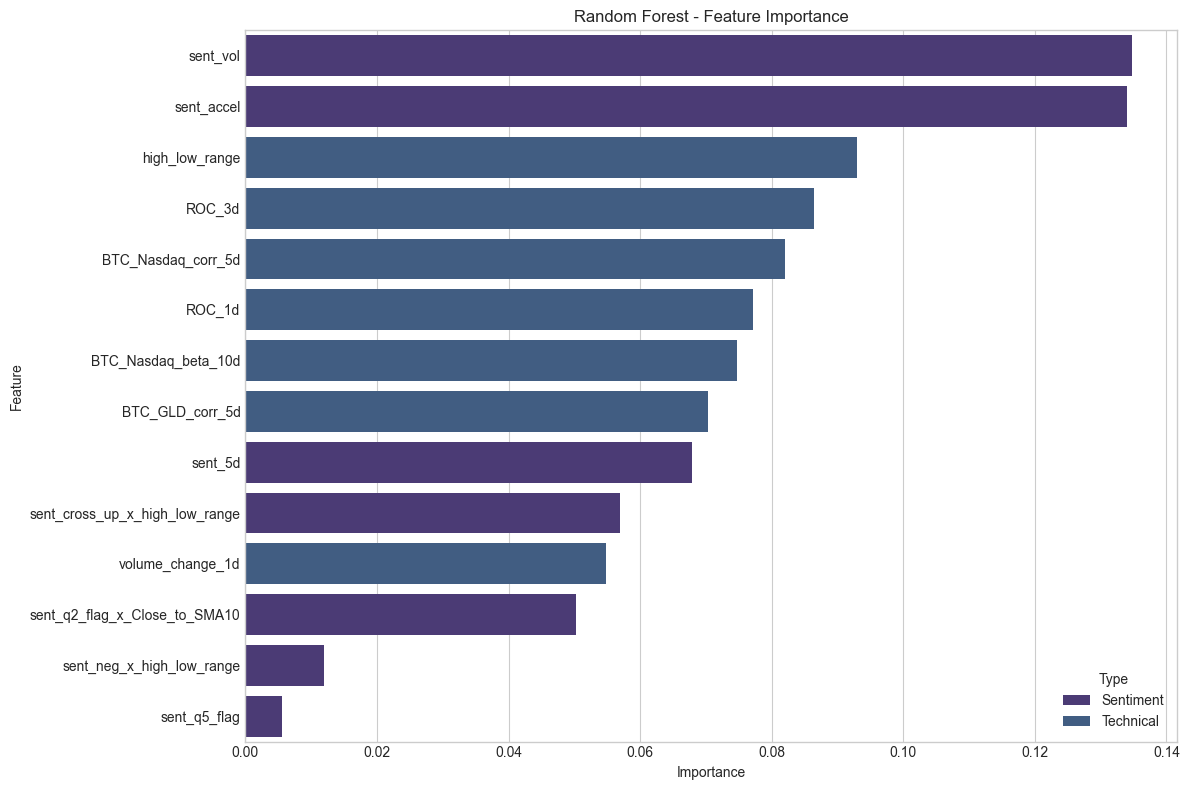

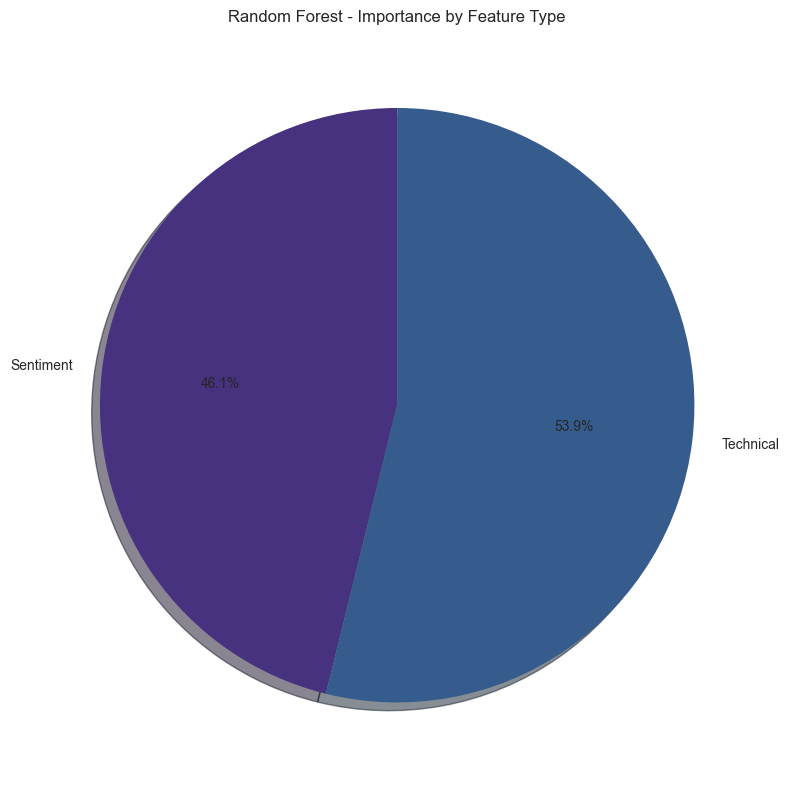


Feature importance by type:
Sentiment features: 0.4614 (46.1%)
Technical features: 0.5386 (53.9%)


In [33]:
# 3.5 Random Forest
print("\n## 3.5 Random Forest")
print("-" * 50)

# Define random forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Train and evaluate
rf_results = evaluate_model(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, 
                          "Random Forest")

# Plot confusion matrix
plot_confusion_matrix(rf_results['confusion_matrix'], "Random Forest")

# Plot ROC curve
plot_roc_curve(y_test, rf_results['y_prob'], "Random Forest")

# Time series cross-validation
rf_cv_results = time_series_cv_scores(RandomForestClassifier(n_estimators=100, max_depth=5, 
                                                         random_state=42),
                                   X_train_scaled, y_train, cv=5)

# Feature importance
feature_importance_rf = analyze_feature_importance(rf_model, X_train_scaled, y_train, 
                                             X_train_scaled.columns, "Random Forest")

In [34]:
# 3.6 Model Comparison
print("\n## 3.6 Model Comparison")
print("-" * 50)

# Collect results
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
model_results = [lr_results, dt_results, rf_results]
cv_results = [lr_cv_results, dt_cv_results, rf_cv_results]

# Create comparison dataframe
comparison = pd.DataFrame(index=models)

# Add test metrics
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    comparison[f'Test {metric.capitalize()}'] = [results[metric] for results in model_results]

# Add CV metrics
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    comparison[f'CV {metric.capitalize()}'] = [results[metric][0] for results in cv_results]
    comparison[f'CV {metric.capitalize()} Std'] = [results[metric][1] for results in cv_results]

# Display comparison
print("\nModel Comparison:")
print(comparison)


## 3.6 Model Comparison
--------------------------------------------------

Model Comparison:
                     Test Accuracy  Test Precision  Test Recall   Test F1  \
Logistic Regression       0.566038        0.583333     0.518519  0.549020   
Decision Tree             0.415094        0.441176     0.555556  0.491803   
Random Forest             0.471698        0.476190     0.370370  0.416667   

                     Test Roc_auc  CV Accuracy  CV Accuracy Std  CV Precision  \
Logistic Regression      0.612536     0.531429         0.034286      0.526786   
Decision Tree            0.393162     0.497143         0.103174      0.456952   
Random Forest            0.467236     0.508571         0.127006      0.516686   

                     CV Precision Std  CV Recall  CV Recall Std     CV F1  \
Logistic Regression          0.082177   0.586835       0.119533  0.537489   
Decision Tree                0.187670   0.430906       0.175444  0.438936   
Random Forest                0.102601   

As it's been the best model overall, let's optimize Logistic Regression

In [35]:
# Define parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear'],  # liblinear supports both l1 and l2
    'max_iter': [1000]
}

In [36]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search
lr = LogisticRegression(random_state=42)
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [37]:
# Fit grid search
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'], 'max_iter': [1000],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='roc_auc', verbose=1)

In [38]:
# Get best model
best_lr = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

Best parameters: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.5507


In [39]:
# Evaluate on test set
y_pred = best_lr.predict(X_test_scaled)
y_prob = best_lr.predict_proba(X_test_scaled)[:, 1]
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

Test accuracy: 0.4906
Test ROC AUC: 0.5570


Implementing Gradient Boosting Models

In [40]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

In [41]:
# XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train XGBoost
xgb_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
print("XGBoost Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")

XGBoost Results:
Accuracy: 0.5660
ROC AUC: 0.5541


In [42]:
# Feature importance
importance = xgb_model.feature_importances_
for i, feature in enumerate(X_train_scaled.columns):
    print(f"{feature}: {importance[i]:.4f}")

sent_q2_flag_x_Close_to_SMA10: 0.0908
BTC_GLD_corr_5d: 0.0587
BTC_Nasdaq_beta_10d: 0.0765
BTC_Nasdaq_corr_5d: 0.0690
sent_vol: 0.0908
sent_cross_up_x_high_low_range: 0.0880
sent_q5_flag: 0.0665
ROC_1d: 0.0724
ROC_3d: 0.0683
sent_5d: 0.0803
volume_change_1d: 0.0681
sent_neg_x_high_low_range: 0.0331
high_low_range: 0.0598
sent_accel: 0.0777


In [43]:
# Initialize Gradient Boosting Classifier with default parameters
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model
gb_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred_gb = gb_model.predict(X_test_scaled)
y_prob_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance
print("Gradient Boosting Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_gb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_gb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_gb):.4f}")

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred_gb)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, 
                 index=['Actual Down', 'Actual Up'],
                 columns=['Predicted Down', 'Predicted Up']))

Gradient Boosting Classifier Results:
Accuracy: 0.4528
Precision: 0.4643
Recall: 0.4815
F1 Score: 0.4727
ROC AUC: 0.4872

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down              11            15
Actual Up                14            13


In [44]:
import lightgbm as lgb

In [45]:
# Initialize LightGBM Classifier with default parameters
lgb_model = lgb.LGBMClassifier(random_state=42)

# Train the model
lgb_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred_lgb = lgb_model.predict(X_test_scaled)
y_prob_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance
print("LightGBM Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lgb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lgb):.4f}")

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred_lgb)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, 
                 index=['Actual Down', 'Actual Up'],
                 columns=['Predicted Down', 'Predicted Up']))

[LightGBM] [Info] Number of positive: 104, number of negative: 106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 768
[LightGBM] [Info] Number of data points in the train set: 210, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495238 -> initscore=-0.019048
[LightGBM] [Info] Start training from score -0.019048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LSTM (Long Short-Term Memory) Model

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [47]:
# Prepare data for LSTM
def create_sequences(X, y, seq_length=5):
    """Create sequences for LSTM input with lookback window"""
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X.iloc[i:i+seq_length].values)
        y_seq.append(y.iloc[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

In [48]:
# Set sequence length (lookback window)
seq_length = 5

# Create sequences for training and testing
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, seq_length)

In [49]:
# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

Epoch 1/100
6/6 [==============================] - 7s 270ms/step - loss: 0.6971 - accuracy: 0.4573 - val_loss: 0.6958 - val_accuracy: 0.4390
Epoch 2/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6920 - accuracy: 0.5427 - val_loss: 0.6965 - val_accuracy: 0.3902
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6897 - accuracy: 0.5305 - val_loss: 0.6965 - val_accuracy: 0.4146
Epoch 4/100
6/6 [==============================] - 0s 17ms/step - loss: 0.6908 - accuracy: 0.5427 - val_loss: 0.6975 - val_accuracy: 0.4146
Epoch 5/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6885 - accuracy: 0.5305 - val_loss: 0.6987 - val_accuracy: 0.4634
Epoch 6/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6809 - accuracy: 0.6280 - val_loss: 0.7001 - val_accuracy: 0.4146
Epoch 7/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6810 - accuracy: 0.5732 - val_loss: 0.7009 - val_accuracy: 0.4390
Epoch 8/100
6/6 [==

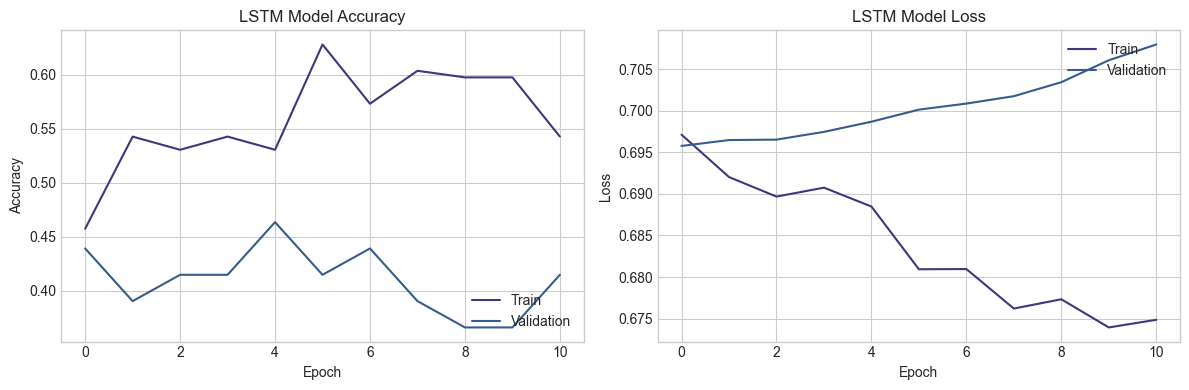

In [50]:
# Initialize LSTM model
lstm_model = build_lstm_model((seq_length, X_train_scaled.shape[1]))

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on test set
y_pred_proba_lstm = lstm_model.predict(X_test_seq).flatten()
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype(int)

# Calculate metrics
lstm_accuracy = accuracy_score(y_test_seq, y_pred_lstm)
lstm_auc = roc_auc_score(y_test_seq, y_pred_proba_lstm)

print(f"LSTM Model Results:")
print(f"Accuracy: {lstm_accuracy:.4f}")
print(f"ROC AUC: {lstm_auc:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

GRU (Gated Recurrent Unit) Model

In [51]:
from tensorflow.keras.layers import GRU

In [52]:
# Build GRU model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(32))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

Epoch 1/100
6/6 [==============================] - 7s 256ms/step - loss: 0.7055 - accuracy: 0.4512 - val_loss: 0.6961 - val_accuracy: 0.5122
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.5549 - val_loss: 0.6986 - val_accuracy: 0.5122
Epoch 3/100
6/6 [==============================] - 0s 13ms/step - loss: 0.6854 - accuracy: 0.5732 - val_loss: 0.6944 - val_accuracy: 0.4878
Epoch 4/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6790 - accuracy: 0.6037 - val_loss: 0.6937 - val_accuracy: 0.4878
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6751 - accuracy: 0.6037 - val_loss: 0.6926 - val_accuracy: 0.5122
Epoch 6/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6820 - accuracy: 0.5671 - val_loss: 0.6917 - val_accuracy: 0.5610
Epoch 7/100
6/6 [==============================] - 0s 18ms/step - loss: 0.6764 - accuracy: 0.5976 - val_loss: 0.6905 - val_accuracy: 0.5122
Epoch 8/100
6/6 [==

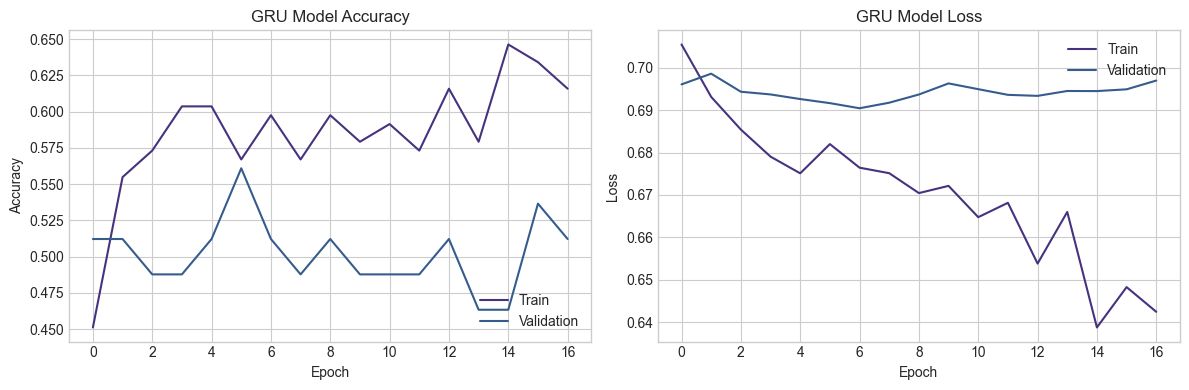

In [53]:
# Initialize GRU model
gru_model = build_gru_model((seq_length, X_train_scaled.shape[1]))

# Train the model
history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on test set
y_pred_proba_gru = gru_model.predict(X_test_seq).flatten()
y_pred_gru = (y_pred_proba_gru > 0.5).astype(int)

# Calculate metrics
gru_accuracy = accuracy_score(y_test_seq, y_pred_gru)
gru_auc = roc_auc_score(y_test_seq, y_pred_proba_gru)

print(f"GRU Model Results:")
print(f"Accuracy: {gru_accuracy:.4f}")
print(f"ROC AUC: {gru_auc:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('GRU Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('GRU Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

Prophet Model

In [54]:
from prophet import Prophet

In [55]:
# Prepare data for Prophet
# Prophet requires a specific format with 'ds' (date) and 'y' columns
def prepare_prophet_data(X, y):
    """Prepare data for Prophet"""
    # Get dates from index
    prophet_df = pd.DataFrame()
    prophet_df['ds'] = X.index
    prophet_df['y'] = y.values
    return prophet_df

# Prepare training data
prophet_train = prepare_prophet_data(X_train_scaled, y_train)

# Train Prophet model for each feature
def train_prophet_models(X, y):
    """Train separate Prophet models for each feature"""
    prophet_models = {}
    forecast_dfs = {}
    
    # First model for target variable
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(prepare_prophet_data(X, y))
    prophet_models['target'] = model
    
    # Make future dataframe for prediction period (length of test set)
    future = model.make_future_dataframe(periods=len(X_test_scaled))
    forecast = model.predict(future)
    forecast_dfs['target'] = forecast
    
    # Train models for each feature
    for col in X.columns:
        model = Prophet(daily_seasonality=True, yearly_seasonality=True)
        feature_df = prepare_prophet_data(X, pd.Series(X[col].values, index=X.index))
        model.fit(feature_df)
        prophet_models[col] = model
        
        future = model.make_future_dataframe(periods=len(X_test_scaled))
        forecast = model.predict(future)
        forecast_dfs[col] = forecast
    
    return prophet_models, forecast_dfs

# Train Prophet models
prophet_models, forecast_dfs = train_prophet_models(X_train_scaled, y_train)

# Create features from Prophet forecasts
def create_prophet_features(forecast_dfs, test_dates):
    """Create features from Prophet forecasts"""
    # Extract only the forecast rows that match test dates
    test_forecasts = {}
    for col, forecast in forecast_dfs.items():
        # Convert forecast dates to the same format as test_dates
        forecast['ds'] = pd.to_datetime(forecast['ds'])
        # Filter forecast to match test dates
        matched_forecast = forecast[forecast['ds'].isin(test_dates)]
        test_forecasts[col] = matched_forecast
    
    # Create feature dataframe
    prophet_features = pd.DataFrame(index=test_dates)
    
    # Add features from each forecast
    for col, forecast in test_forecasts.items():
        # Set index to match the prophet_features index
        forecast = forecast.set_index('ds')
        
        # Add relevant columns as features
        prophet_features[f'{col}_trend'] = forecast['trend']
        prophet_features[f'{col}_yhat'] = forecast['yhat']
        
        # Add seasonality components if available
        if 'yearly' in forecast.columns:
            prophet_features[f'{col}_yearly'] = forecast['yearly']
        if 'weekly' in forecast.columns:
            prophet_features[f'{col}_weekly'] = forecast['weekly']
        if 'daily' in forecast.columns:
            prophet_features[f'{col}_daily'] = forecast['daily']
    
    return prophet_features

# Get test dates
test_dates = X_test_scaled.index

# Create Prophet-based features
prophet_features = create_prophet_features(forecast_dfs, test_dates)


22:55:42 - cmdstanpy - INFO - Chain [1] start processing
22:55:43 - cmdstanpy - INFO - Chain [1] done processing
22:55:43 - cmdstanpy - INFO - Chain [1] start processing
22:55:43 - cmdstanpy - INFO - Chain [1] done processing
22:55:44 - cmdstanpy - INFO - Chain [1] start processing
22:55:44 - cmdstanpy - INFO - Chain [1] done processing
22:55:44 - cmdstanpy - INFO - Chain [1] start processing
22:55:44 - cmdstanpy - INFO - Chain [1] done processing
22:55:44 - cmdstanpy - INFO - Chain [1] start processing
22:55:44 - cmdstanpy - INFO - Chain [1] done processing
22:55:44 - cmdstanpy - INFO - Chain [1] start processing
22:55:44 - cmdstanpy - INFO - Chain [1] done processing
22:55:45 - cmdstanpy - INFO - Chain [1] start processing
22:55:45 - cmdstanpy - INFO - Chain [1] done processing
22:55:45 - cmdstanpy - INFO - Chain [1] start processing
22:55:45 - cmdstanpy - INFO - Chain [1] done processing
22:55:45 - cmdstanpy - INFO - Chain [1] start processing
22:55:45 - cmdstanpy - INFO - Chain [1]

In [56]:
# Train a classifier using Prophet features
from sklearn.ensemble import RandomForestClassifier

Prophet Model Results:
Accuracy: 0.4906
ROC AUC: 0.4779


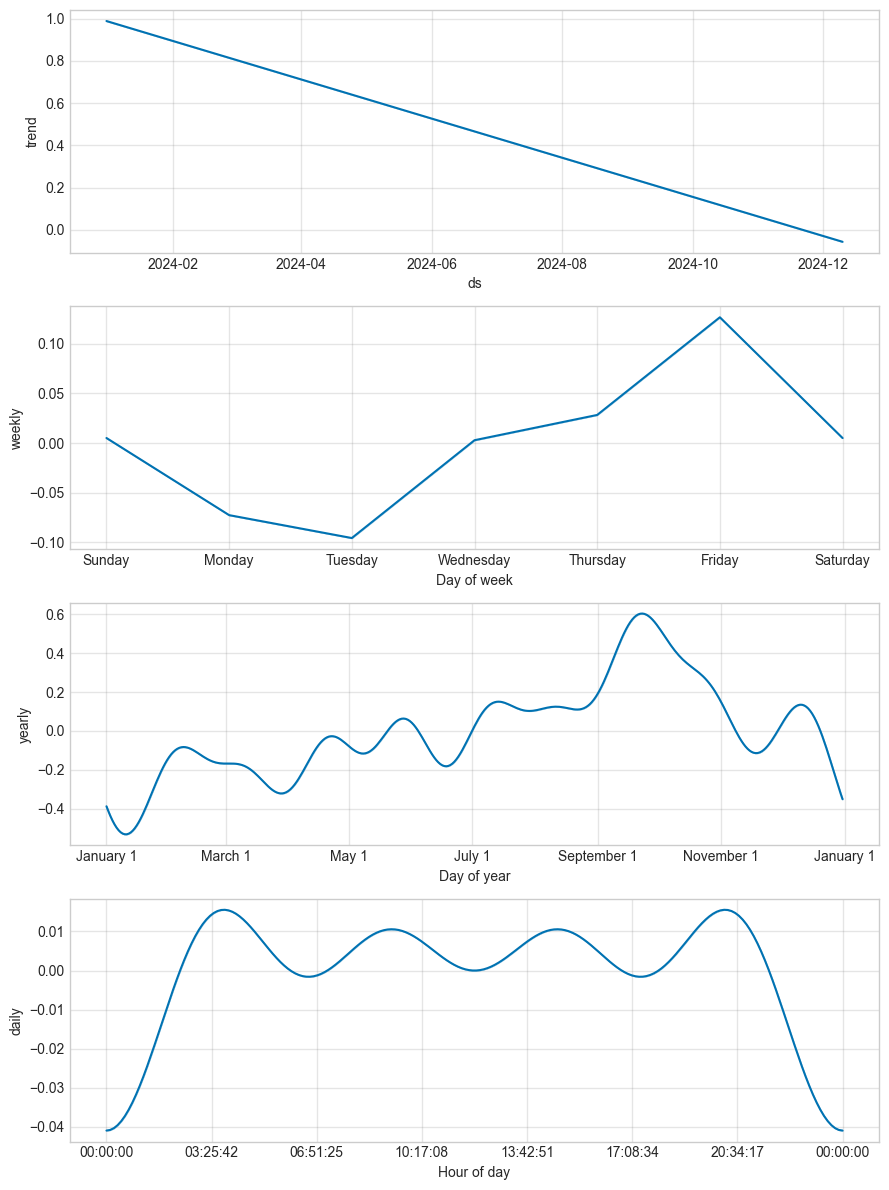

In [57]:
# Create training features from Prophet forecasts for training dates
train_prophet_features = create_prophet_features(forecast_dfs, X_train_scaled.index)

# Train a classifier
prophet_clf = RandomForestClassifier(n_estimators=100, random_state=42)
prophet_clf.fit(train_prophet_features, y_train)

# Make predictions
y_pred_proba_prophet = prophet_clf.predict_proba(prophet_features)[:, 1]
y_pred_prophet = prophet_clf.predict(prophet_features)

# Calculate metrics
prophet_accuracy = accuracy_score(y_test, y_pred_prophet)
prophet_auc = roc_auc_score(y_test, y_pred_proba_prophet)

print(f"Prophet Model Results:")
print(f"Accuracy: {prophet_accuracy:.4f}")
print(f"ROC AUC: {prophet_auc:.4f}")

# Plot Prophet components for the target variable
fig = prophet_models['target'].plot_components(forecast_dfs['target'])
plt.show()

Training sequences shape: (205, 5, 14)
Testing sequences shape: (48, 5, 14)
Total hyperparameter combinations: 108
Created 3 time series validation splits

Combination 1/108: {'units1': 64, 'units2': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
  Split 1/3
2/2 [==============================] - 1s 17ms/step
    Validation AUC: 0.5401
  Split 2/3
2/2 [==============================] - 1s 0s/step
    Validation AUC: 0.5047
  Split 3/3
2/2 [==============================] - 1s 0s/step
    Validation AUC: 0.5540
  Mean validation AUC: 0.5329 (±0.0208)
  Elapsed time: 0.4 minutes
  Estimated remaining time: 47.2 minutes

Combination 2/108: {'units1': 64, 'units2': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64}
  Split 1/3
2/2 [==============================] - 1s 9ms/step
    Validation AUC: 0.4306
  Split 2/3
2/2 [==============================] - 1s 0s/step
    Validation AUC: 0.4028
  Split 3/3
2/2 [==============================] - 1s 8ms/step
 

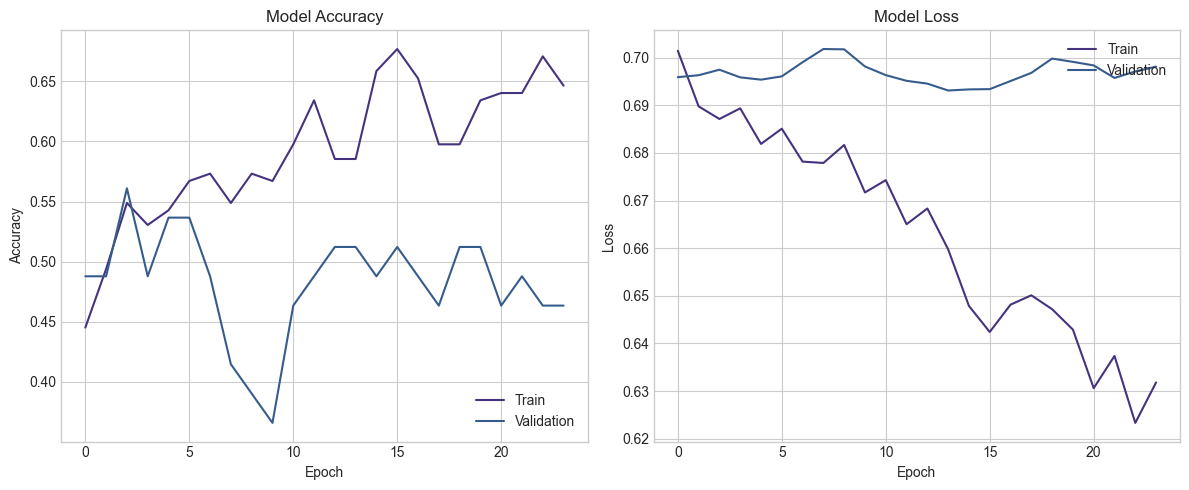

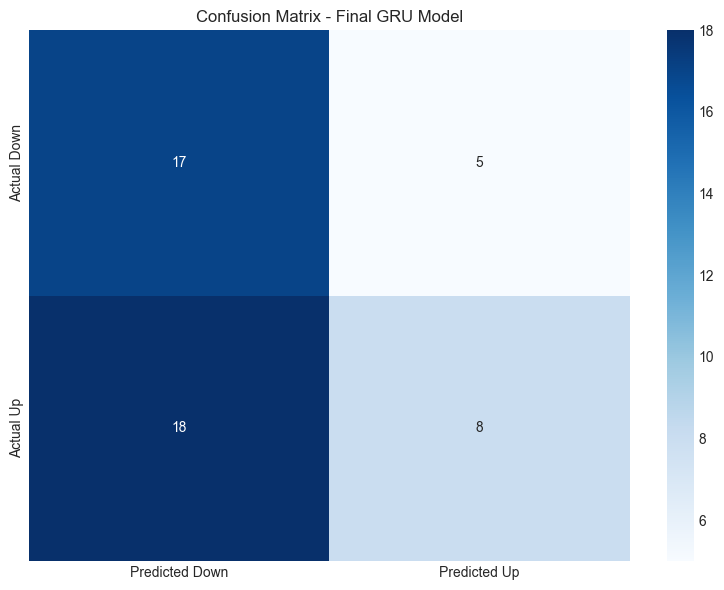


Final GRU model saved as 'final_gru_model.h5'


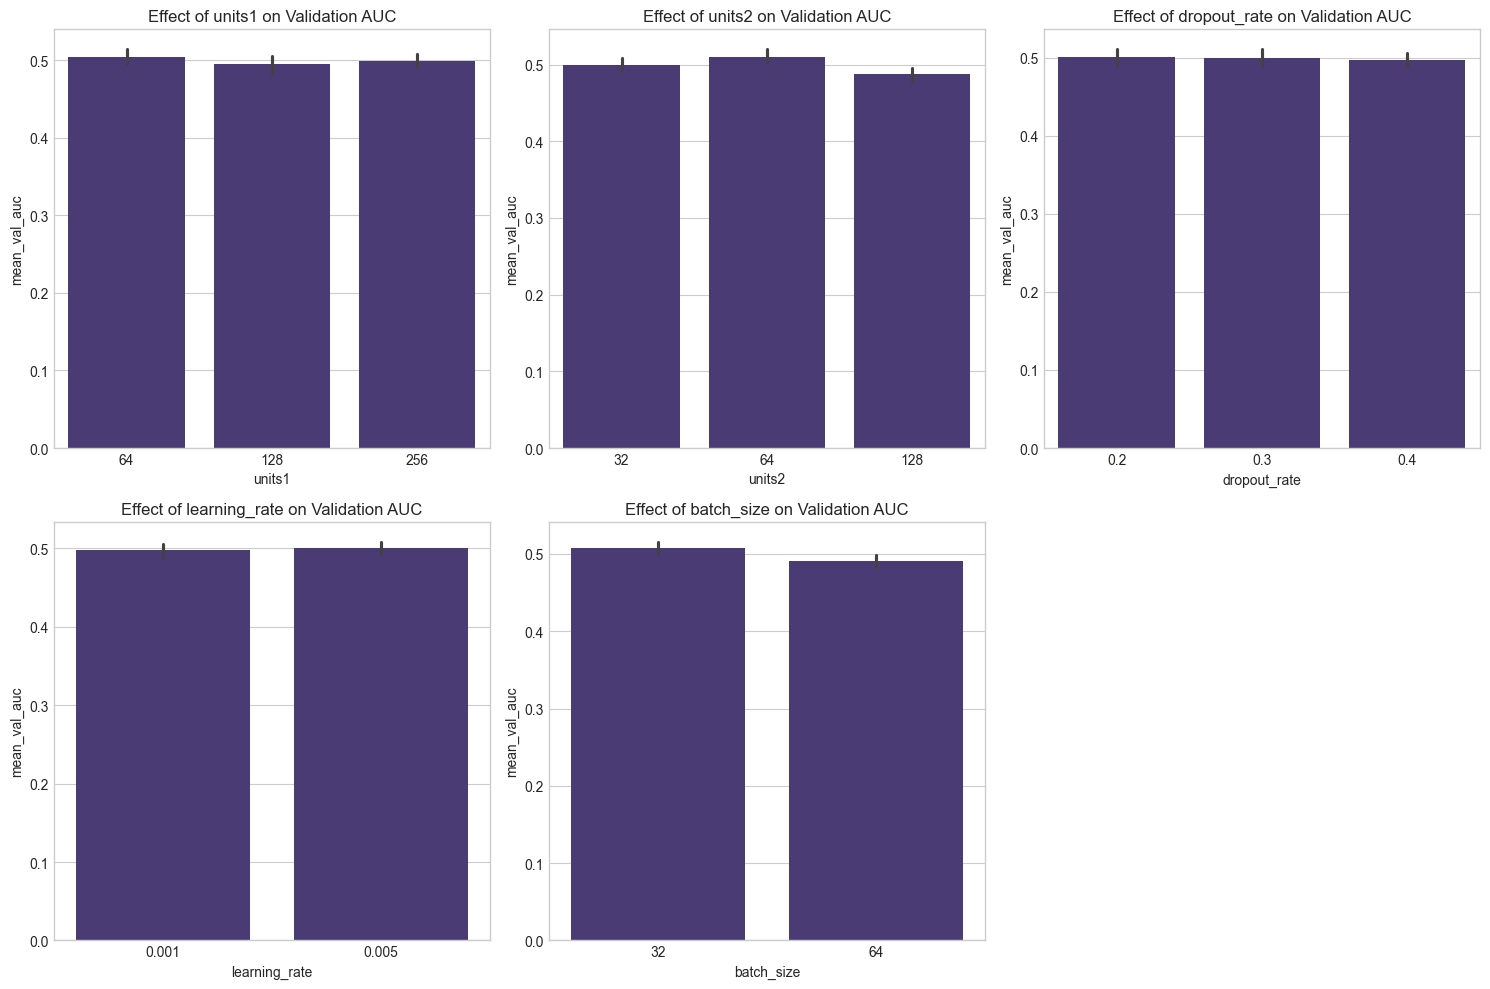

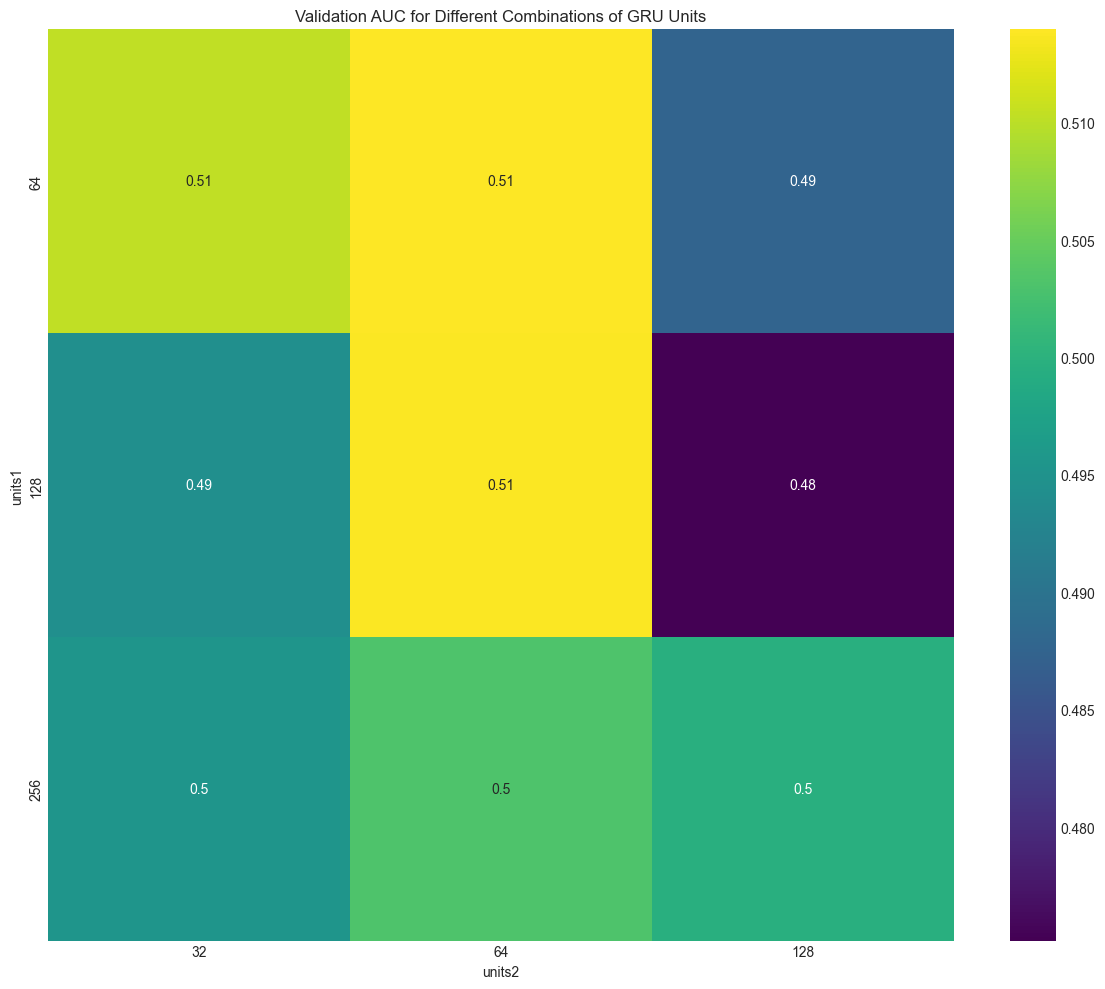

In [58]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Assuming you have already prepared X_train_seq, y_train_seq, X_test_seq, y_test_seq
# If not, here's the function to create sequences:

def create_sequences(X, y, seq_length=5):
    """Create sequences for GRU input with lookback window"""
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X.iloc[i:i+seq_length].values)
        y_seq.append(y.iloc[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

# Set sequence length (lookback window)
seq_length = 5

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, seq_length)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Testing sequences shape: {X_test_seq.shape}")

# Define function to build and train GRU model
def build_and_train_gru(units1, units2, dropout_rate, learning_rate, batch_size, 
                       epochs, input_shape, X_train, y_train, X_val=None, y_val=None):
    """Build and train a GRU model with specified hyperparameters"""
    
    # Clear TensorFlow session to avoid memory issues
    tf.keras.backend.clear_session()
    
    # Define the model
    model = Sequential()
    model.add(GRU(units1, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    ]
    
    # Use validation set if provided, otherwise use validation_split
    if X_val is not None and y_val is not None:
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=0
        )
    else:
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=0
        )
    
    return model, history

# Define function to evaluate GRU model
def evaluate_gru(model, X_test, y_test):
    """Evaluate GRU model performance"""
    
    # Predict on test set
    y_pred_proba = model.predict(X_test).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return {
        'accuracy': accuracy,
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# Define hyperparameter grid for GRU
param_grid = {
    'units1': [64, 128, 256],           # First GRU layer units
    'units2': [32, 64, 128],            # Second GRU layer units
    'dropout_rate': [0.2, 0.3, 0.4],    # Dropout rate
    'learning_rate': [0.001, 0.005],    # Learning rate
    'batch_size': [32, 64]              # Batch size
}

# Calculate total number of combinations
total_combinations = 1
for param in param_grid.values():
    total_combinations *= len(param)

print(f"Total hyperparameter combinations: {total_combinations}")

# Create time series validation splits
def create_time_series_splits(X, y, n_splits=3):
    """Create time series validation splits"""
    splits = []
    split_size = len(X) // (n_splits + 1)
    
    for i in range(n_splits):
        # End of training set
        train_end = (i + 1) * split_size
        # Validation set
        val_start = train_end
        val_end = val_start + split_size
        
        # Create split
        X_train_split = X[:train_end]
        y_train_split = y[:train_end]
        X_val_split = X[val_start:val_end]
        y_val_split = y[val_start:val_end]
        
        splits.append((X_train_split, y_train_split, X_val_split, y_val_split))
    
    return splits

# Create time series validation splits
ts_splits = create_time_series_splits(X_train_seq, y_train_seq, n_splits=3)
print(f"Created {len(ts_splits)} time series validation splits")

# Perform grid search with time series validation
def grid_search_gru(param_grid, ts_splits, input_shape, epochs=100):
    """Perform grid search for GRU model with time series validation"""
    
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_combinations = list(itertools.product(*param_values))
    
    # Initialize results
    results = []
    start_time = time.time()
    
    # Iterate through parameter combinations
    for i, combination in enumerate(param_combinations):
        params = dict(zip(param_names, combination))
        print(f"\nCombination {i+1}/{len(param_combinations)}: {params}")
        
        # Track validation scores across splits
        val_scores = []
        
        # Iterate through time series splits
        for j, (X_train_split, y_train_split, X_val_split, y_val_split) in enumerate(ts_splits):
            print(f"  Split {j+1}/{len(ts_splits)}")
            
            # Build and train model
            model, history = build_and_train_gru(
                units1=params['units1'],
                units2=params['units2'],
                dropout_rate=params['dropout_rate'],
                learning_rate=params['learning_rate'],
                batch_size=params['batch_size'],
                epochs=epochs,
                input_shape=input_shape,
                X_train=X_train_split,
                y_train=y_train_split,
                X_val=X_val_split,
                y_val=y_val_split
            )
            
            # Evaluate on validation set
            val_metrics = evaluate_gru(model, X_val_split, y_val_split)
            val_scores.append(val_metrics['auc'])
            
            print(f"    Validation AUC: {val_metrics['auc']:.4f}")
        
        # Calculate mean validation score
        mean_val_score = np.mean(val_scores)
        std_val_score = np.std(val_scores)
        
        # Store results
        results.append({
            **params,
            'mean_val_auc': mean_val_score,
            'std_val_auc': std_val_score,
            'val_scores': val_scores
        })
        
        print(f"  Mean validation AUC: {mean_val_score:.4f} (±{std_val_score:.4f})")
        
        # Estimate remaining time
        elapsed_time = time.time() - start_time
        avg_time_per_combo = elapsed_time / (i + 1)
        remaining_combos = len(param_combinations) - (i + 1)
        estimated_remaining_time = avg_time_per_combo * remaining_combos
        
        print(f"  Elapsed time: {elapsed_time/60:.1f} minutes")
        print(f"  Estimated remaining time: {estimated_remaining_time/60:.1f} minutes")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Run grid search
input_shape = (seq_length, X_train_scaled.shape[1])
grid_search_results = grid_search_gru(param_grid, ts_splits, input_shape, epochs=100)

# Find best hyperparameters
best_idx = grid_search_results['mean_val_auc'].idxmax()
best_params = grid_search_results.loc[best_idx]

print("\n" + "="*50)
print("BEST GRU HYPERPARAMETERS:")
print("="*50)
for param, value in best_params.items():
    if param not in ['mean_val_auc', 'std_val_auc', 'val_scores']:
        print(f"{param}: {value}")

print(f"\nBest validation AUC: {best_params['mean_val_auc']:.4f} (±{best_params['std_val_auc']:.4f})")

# Train final model with best hyperparameters
print("\nTraining final model with best hyperparameters...")
final_model, final_history = build_and_train_gru(
    units1=best_params['units1'],
    units2=best_params['units2'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate'],
    batch_size=best_params['batch_size'],
    epochs=100,
    input_shape=input_shape,
    X_train=X_train_seq,
    y_train=y_train_seq
)

# Evaluate final model on test set
final_metrics = evaluate_gru(final_model, X_test_seq, y_test_seq)

print("\nFinal Model Test Performance:")
print(f"Accuracy: {final_metrics['accuracy']:.4f}")
print(f"AUC: {final_metrics['auc']:.4f}")
print(f"Precision: {final_metrics['precision']:.4f}")
print(f"Recall: {final_metrics['recall']:.4f}")
print(f"F1 Score: {final_metrics['f1']:.4f}")

# Plot learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'])
plt.plot(final_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'])
plt.plot(final_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_seq, final_metrics['y_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Predicted Down', 'Predicted Up'],
           yticklabels=['Actual Down', 'Actual Up'])
plt.title('Confusion Matrix - Final GRU Model')
plt.tight_layout()
plt.show()

# Save final model
final_model.save('final_gru_model.h5')
print("\nFinal GRU model saved as 'final_gru_model.h5'")

# Visualize grid search results
plt.figure(figsize=(15, 10))

# Plot mean validation AUC for each parameter
for i, param in enumerate(param_grid.keys()):
    plt.subplot(2, 3, i+1)
    sns.barplot(x=param, y='mean_val_auc', data=grid_search_results)
    plt.title(f'Effect of {param} on Validation AUC')
    plt.tight_layout()

plt.show()

# Explore parameter interactions
if len(param_grid) >= 2:
    plt.figure(figsize=(12, 10))
    sns.heatmap(grid_search_results.pivot_table(
        values='mean_val_auc', 
        index='units1', 
        columns='units2'
    ), annot=True, cmap='viridis')
    plt.title('Validation AUC for Different Combinations of GRU Units')
    plt.tight_layout()
    plt.show()


Optimal Threshold Results:
Best threshold: 0.30
Accuracy at best threshold: 0.5417
F1 Score at best threshold: 0.7027


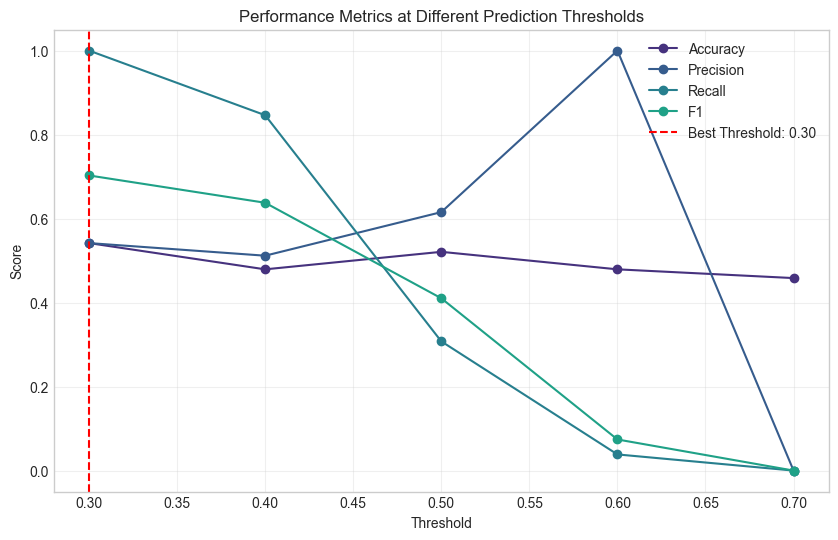

In [59]:
# Optimize prediction threshold
y_pred_proba = final_metrics['y_pred_proba']
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_seq, y_pred_threshold)
    precision = precision_score(y_test_seq, y_pred_threshold)
    recall = recall_score(y_test_seq, y_pred_threshold)
    f1 = f1_score(y_test_seq, y_pred_threshold)
    
    # Store results
    threshold_results.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

# Convert to DataFrame
threshold_df = pd.DataFrame(threshold_results)

# Find optimal threshold based on F1 score
best_threshold_idx = threshold_df['f1'].idxmax()
best_threshold = threshold_df.loc[best_threshold_idx, 'threshold']

print("\nOptimal Threshold Results:")
print(f"Best threshold: {best_threshold:.2f}")
print(f"Accuracy at best threshold: {threshold_df.loc[best_threshold_idx, 'accuracy']:.4f}")
print(f"F1 Score at best threshold: {threshold_df.loc[best_threshold_idx, 'f1']:.4f}")

# Plot threshold impact
plt.figure(figsize=(10, 6))
metrics = ['accuracy', 'precision', 'recall', 'f1']
for metric in metrics:
    plt.plot(threshold_df['threshold'], threshold_df[metric], 'o-', label=metric.capitalize())

plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.grid(True, alpha=0.3)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics at Different Prediction Thresholds')
plt.legend()
plt.show()

In [60]:
# Test different sequence lengths
seq_lengths = [3, 7, 10, 15]
seq_results = []

for seq_len in seq_lengths:
    print(f"Testing sequence length: {seq_len}")
    
    # Create sequences with this length
    X_train_seq_custom, y_train_seq_custom = create_sequences(X_train_scaled, y_train, seq_len)
    X_test_seq_custom, y_test_seq_custom = create_sequences(X_test_scaled, y_test, seq_len)
    
    # Build model with best parameters
    model = Sequential()
    model.add(GRU(64, return_sequences=True, input_shape=(seq_len, X_train_scaled.shape[1])))
    model.add(Dropout(0.3))
    model.add(GRU(64))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=0.005), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    # Train
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train_seq_custom, y_train_seq_custom,
              epochs=100,
              batch_size=32,
              validation_split=0.2,
              callbacks=[early_stopping],
              verbose=0)
    
    # Evaluate with optimal threshold
    y_pred_proba = model.predict(X_test_seq_custom).flatten()
    y_pred = (y_pred_proba >= 0.3).astype(int)
    
    accuracy = accuracy_score(y_test_seq_custom, y_pred)
    f1 = f1_score(y_test_seq_custom, y_pred)
    
    seq_results.append({
        'sequence_length': seq_len,
        'accuracy': accuracy,
        'f1': f1,
        'samples': len(X_test_seq_custom)
    })
    
    print(f"F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# Find best sequence length
seq_results_df = pd.DataFrame(seq_results)
print("\nPerformance by sequence length:")
print(seq_results_df)

Testing sequence length: 3
2/2 [==============================] - 1s 4ms/step
F1 Score: 0.7013, Accuracy: 0.5400
Testing sequence length: 7
2/2 [==============================] - 1s 6ms/step
F1 Score: 0.6857, Accuracy: 0.5217
Testing sequence length: 10
2/2 [==============================] - 1s 5ms/step
F1 Score: 0.6667, Accuracy: 0.5116
Testing sequence length: 15
2/2 [==============================] - 1s 4ms/step
F1 Score: 0.7018, Accuracy: 0.5526

Performance by sequence length:
   sequence_length  accuracy        f1  samples
0                3  0.540000  0.701299       50
1                7  0.521739  0.685714       46
2               10  0.511628  0.666667       43
3               15  0.552632  0.701754       38


Class distribution in training set: [104 101]
Class weights: {0: 0.9855769230769231, 1: 1.0148514851485149}

Training improved GRU model...
Epoch 1/150
5/6 [========================>.....] - ETA: 0s - loss: 0.9686 - accuracy: 0.4938 
Epoch 1: val_loss improved from inf to 0.94537, saving model to best_gru_model.h5
6/6 [==============================] - 10s 305ms/step - loss: 0.9672 - accuracy: 0.4939 - val_loss: 0.9454 - val_accuracy: 0.4878
Epoch 2/150
1/6 [====>.........................] - ETA: 0s - loss: 0.9422 - accuracy: 0.5938
Epoch 2: val_loss improved from 0.94537 to 0.93242, saving model to best_gru_model.h5
6/6 [==============================] - 0s 23ms/step - loss: 0.9477 - accuracy: 0.5122 - val_loss: 0.9324 - val_accuracy: 0.5366
Epoch 3/150
1/6 [====>.........................] - ETA: 0s - loss: 0.9284 - accuracy: 0.5625
Epoch 3: val_loss improved from 0.93242 to 0.91915, saving model to best_gru_model.h5
6/6 [==============================] - 0s 23ms/step - loss: 0.9232 -

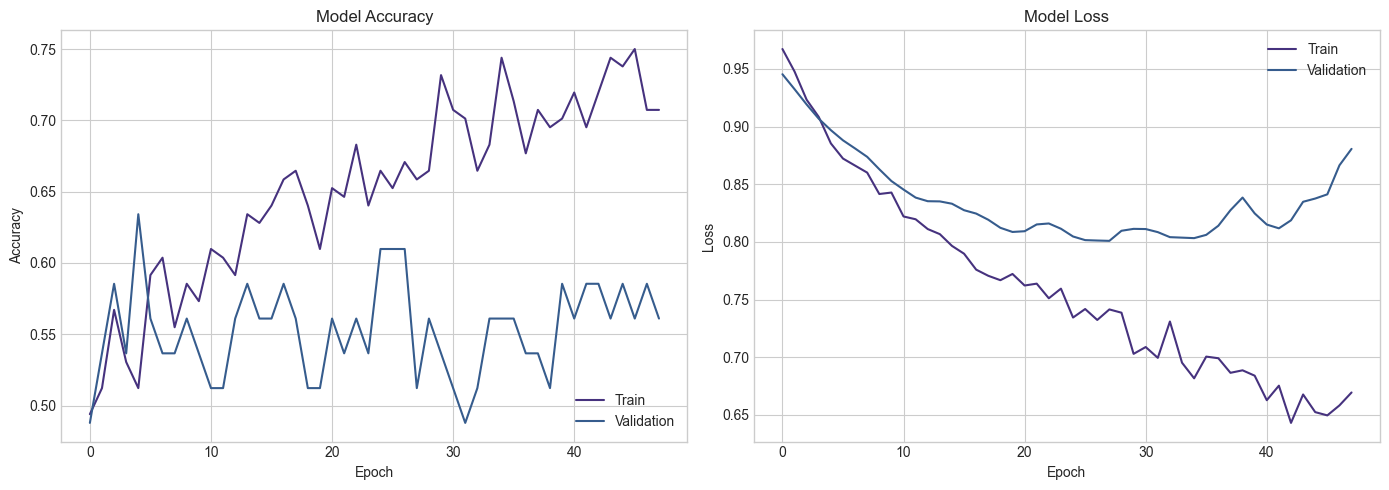

2/2 [==============================] - 1s 4ms/step

GRU performance at different thresholds:
   Threshold  Accuracy  Precision    Recall  F1 Score
0        0.3    0.4375   0.487805  0.769231  0.597015
1        0.4    0.4375   0.482759  0.538462  0.509091
2        0.5    0.5000   0.571429  0.307692  0.400000
3        0.6    0.5000   0.625000  0.192308  0.294118
4        0.7    0.4375   0.000000  0.000000  0.000000

Best threshold: 0.3


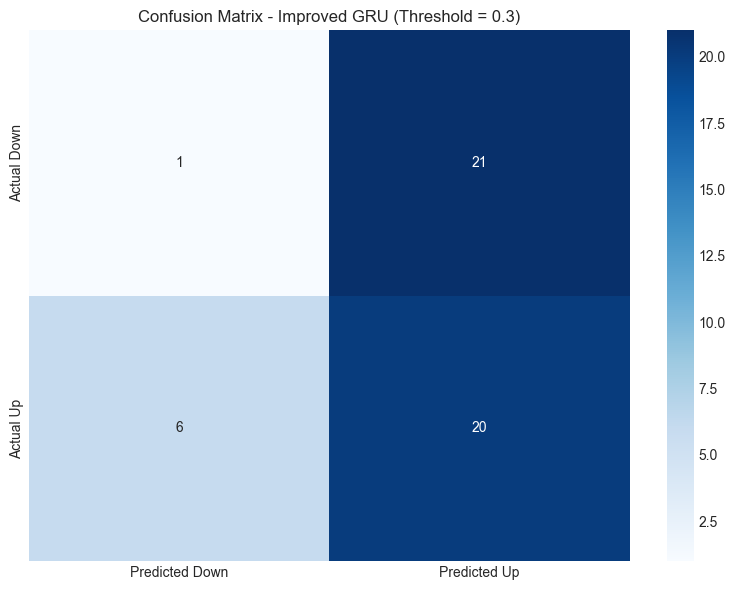


Final GRU Model Performance:
Accuracy: 0.4375
Precision: 0.4878
Recall: 0.7692
F1 Score: 0.5970
AUC: 0.4738
DEBUG - trades_made: 36
DEBUG - correct_trades: 17
DEBUG - win_rate: 0.4722 (47.22%)
DEBUG - trades_made: 29
DEBUG - correct_trades: 14
DEBUG - win_rate: 0.4828 (48.28%)
DEBUG - trades_made: 17
DEBUG - correct_trades: 11
DEBUG - win_rate: 0.6471 (64.71%)
DEBUG - trades_made: 14
DEBUG - correct_trades: 8
DEBUG - win_rate: 0.5714 (57.14%)
DEBUG - trades_made: 10
DEBUG - correct_trades: 6
DEBUG - win_rate: 0.6000 (60.00%)

Trading Strategy Results by Confidence Band:
   Confidence Band  Trades  Trading Rate   Win Rate  Total Return    Sharpe
0             0.05      36     75.000000  47.222222          -2.0 -0.764648
1             0.10      29     60.416667  48.275862          -1.0 -0.425634
2             0.15      17     35.416667  64.705882           5.0  2.822163
3             0.20      14     29.166667  57.142857           2.0  1.228406
4             0.25      10     20.833333  

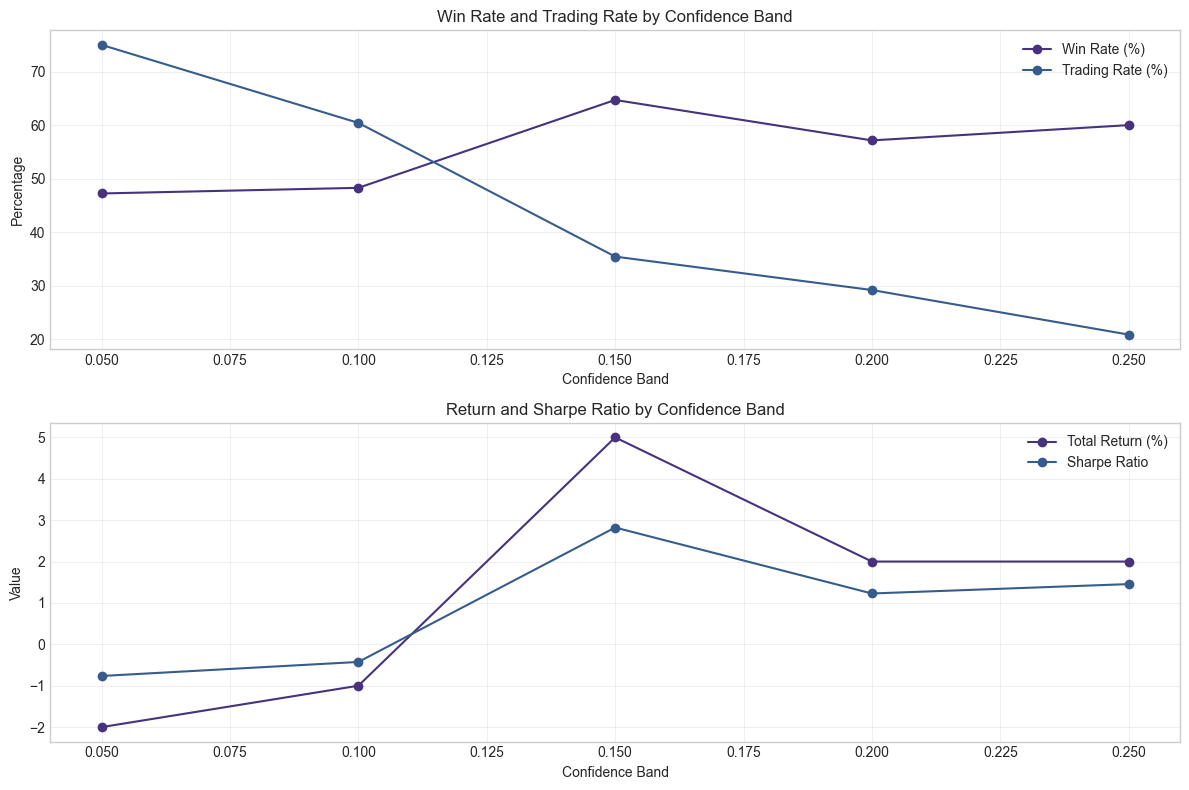


Optimal Trading Strategy Configuration:
Confidence Band: 0.15
Trades: 17.0 (35.4% of days)
Win Rate: 64.7%
Total Return: 5.00%
Sharpe Ratio: 2.82


In [70]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Fix the GRU model with proper class weights
# ==========================================

# Check class distribution in training set
# Convert to numpy array and flatten if needed
y_train_seq_flat = np.array(y_train_seq).flatten()

# Convert to int safely
y_train_int = y_train_seq_flat.astype(int)

# Get class counts
train_class_counts = np.bincount(y_train_int)
print(f"Class distribution in training set: {train_class_counts}")

# Calculate class weights properly (as dictionary with integer keys)
total_samples = len(y_train_seq)
n_classes = len(train_class_counts)
class_weights = {}

for i in range(n_classes):
    class_weights[i] = total_samples / (n_classes * train_class_counts[i])

print(f"Class weights: {class_weights}")

# Build improved GRU model with L2 regularization
def build_improved_gru(input_shape, units1=64, units2=64, dropout_rate=0.3, reg_strength=0.001):
    model = Sequential(name="Improved_GRU")
    model.add(GRU(units1, return_sequences=True, 
                 input_shape=input_shape,
                 kernel_regularizer=l2(reg_strength),
                 recurrent_regularizer=l2(reg_strength)))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units2, 
                 kernel_regularizer=l2(reg_strength),
                 recurrent_regularizer=l2(reg_strength)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(reg_strength)))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Create improved GRU model
improved_gru = build_improved_gru(
    input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
    dropout_rate=0.3,
    reg_strength=0.001
)

# Compile model with lower learning rate
improved_gru.compile(
    optimizer=Adam(learning_rate=0.001),  # Lower learning rate for better convergence
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks
checkpoint = ModelCheckpoint(
    'best_gru_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Train the model with class weights
print("\nTraining improved GRU model...")
history = improved_gru.fit(
    X_train_seq, y_train_seq,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Plot training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

# 2. Evaluate with multiple thresholds
# ==========================================

# Get predictions
y_pred_proba = improved_gru.predict(X_test_seq).flatten()

# Test different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for threshold in thresholds:
    # Apply threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_seq, y_pred)
    precision = precision_score(y_test_seq, y_pred, zero_division=0)
    recall = recall_score(y_test_seq, y_pred, zero_division=0)
    f1 = f1_score(y_test_seq, y_pred, zero_division=0)
    
    threshold_results.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Convert to DataFrame
threshold_df = pd.DataFrame(threshold_results)
print("\nGRU performance at different thresholds:")
print(threshold_df)

# Find best threshold
best_threshold_idx = threshold_df['F1 Score'].idxmax()
best_threshold = threshold_df.loc[best_threshold_idx, 'Threshold']
print(f"\nBest threshold: {best_threshold}")

# 3. Create confusion matrix with best threshold
# ==========================================

# Apply best threshold
y_pred_best = (y_pred_proba >= best_threshold).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_test_seq, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Predicted Down', 'Predicted Up'],
           yticklabels=['Actual Down', 'Actual Up'])
plt.title(f'Confusion Matrix - Improved GRU (Threshold = {best_threshold})')
plt.tight_layout()
plt.show()

# Calculate final metrics
final_accuracy = accuracy_score(y_test_seq, y_pred_best)
final_precision = precision_score(y_test_seq, y_pred_best, zero_division=0)
final_recall = recall_score(y_test_seq, y_pred_best, zero_division=0)
final_f1 = f1_score(y_test_seq, y_pred_best, zero_division=0)
final_auc = roc_auc_score(y_test_seq, y_pred_proba)

print("\nFinal GRU Model Performance:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"AUC: {final_auc:.4f}")

# 4. Implement selective trading strategy
# ==========================================

def selective_trading_strategy(probabilities, y_true, threshold=0.5, confidence_band=0.1):
    """
    Fixed trading strategy function addressing the specific multiplication issue.
    
    Parameters:
    -----------
    probabilities : array-like
        Probability predictions from model
    y_true : array-like
        True labels (0 or 1)
    threshold : float, default=0.5
        Classification threshold
    confidence_band : float, default=0.1
        Minimum confidence band around threshold to trade
        
    Returns:
    --------
    dict
        Trading performance metrics
    """
    import numpy as np
    
    # Ensure inputs are numpy arrays
    probabilities = np.array(probabilities).flatten()
    y_true = np.array(y_true).flatten()
    
    # Create positions array (0 = no position, 1 = long, -1 = short)
    positions = np.zeros(len(probabilities))
    
    # Long positions when probability is high enough
    long_mask = probabilities >= (threshold + confidence_band)
    positions[long_mask] = 1
    
    # Short positions when probability is low enough
    short_mask = probabilities <= (threshold - confidence_band)
    positions[short_mask] = -1
    
    # Count trades made (non-zero positions)
    trade_mask = positions != 0
    trades_made = np.sum(trade_mask)
    
    # If no trades, return zeros
    if trades_made == 0:
        return {
            'Trades': 0,
            'Trading Rate': 0,
            'Win Rate': 0,
            'Total Return': 0,
            'Sharpe': 0
        }
    
    # COMPLETELY REWRITTEN correct trade calculation with manual counting
    correct_trades = 0
    for i in range(len(positions)):
        # Only count positions where we made a trade
        if positions[i] != 0:
            # Long position and up day (correct)
            if positions[i] == 1 and y_true[i] == 1:
                correct_trades += 1
            # Short position and down day (correct)
            elif positions[i] == -1 and y_true[i] == 0:
                correct_trades += 1
    
    # Calculate win rate properly
    win_rate = correct_trades / trades_made
    
    # Calculate returns (assuming +1% for up day, -1% for down day)
    simple_returns = np.where(y_true == 1, 0.01, -0.01)
    strategy_returns = positions * simple_returns
    
    # Calculate performance metrics
    total_return = np.sum(strategy_returns)
    
    # Calculate Sharpe ratio (annualized)
    if np.std(strategy_returns) > 0:
        sharpe = np.mean(strategy_returns) / np.std(strategy_returns) * np.sqrt(252)
    else:
        sharpe = 0
    
    # Debug info
    print(f"DEBUG - trades_made: {trades_made}")
    print(f"DEBUG - correct_trades: {correct_trades}")
    print(f"DEBUG - win_rate: {win_rate:.4f} ({win_rate*100:.2f}%)")
    
    return {
        'Trades': trades_made,
        'Trading Rate': trades_made / len(probabilities),
        'Win Rate': win_rate,  # Return as decimal, not percentage
        'Total Return': total_return,  # Return as decimal, not percentage
        'Sharpe': sharpe
    }

# Test different confidence bands
confidence_bands = [0.05, 0.1, 0.15, 0.2, 0.25]
strategy_results = []

for band in confidence_bands:
    result = selective_trading_strategy(
        y_pred_proba, 
        y_test_seq, 
        threshold=best_threshold,
        confidence_band=band
    )
    
    strategy_results.append({
        'Confidence Band': band,
        'Trades': result['Trades'],
        'Trading Rate': result['Trading Rate'] * 100,  # Convert to percentage
        'Win Rate': result['Win Rate'] * 100,          # Convert to percentage
        'Total Return': result['Total Return'] * 100,  # Convert to percentage
        'Sharpe': result['Sharpe']
    })

# Convert to DataFrame
strategy_df = pd.DataFrame(strategy_results)
print("\nTrading Strategy Results by Confidence Band:")
print(strategy_df)

# Visualize trading strategy performance
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(strategy_df['Confidence Band'], strategy_df['Win Rate'], 'o-', label='Win Rate (%)')
plt.plot(strategy_df['Confidence Band'], strategy_df['Trading Rate'], 'o-', label='Trading Rate (%)')
plt.grid(alpha=0.3)
plt.xlabel('Confidence Band')
plt.ylabel('Percentage')
plt.legend()
plt.title('Win Rate and Trading Rate by Confidence Band')

plt.subplot(2, 1, 2)
plt.plot(strategy_df['Confidence Band'], strategy_df['Total Return'], 'o-', label='Total Return (%)')
plt.plot(strategy_df['Confidence Band'], strategy_df['Sharpe'], 'o-', label='Sharpe Ratio')
plt.grid(alpha=0.3)
plt.xlabel('Confidence Band')
plt.ylabel('Value')
plt.legend()
plt.title('Return and Sharpe Ratio by Confidence Band')
plt.tight_layout()
plt.show()

# Find optimal confidence band based on Sharpe ratio
if strategy_df['Sharpe'].max() > 0:
    best_band_idx = strategy_df['Sharpe'].idxmax()
    best_band = strategy_df.loc[best_band_idx]
    
    print("\nOptimal Trading Strategy Configuration:")
    print(f"Confidence Band: {best_band['Confidence Band']}")
    print(f"Trades: {best_band['Trades']} ({best_band['Trading Rate']:.1f}% of days)")
    print(f"Win Rate: {best_band['Win Rate']:.1f}%")
    print(f"Total Return: {best_band['Total Return']:.2f}%")
    print(f"Sharpe Ratio: {best_band['Sharpe']:.2f}")
else:
    print("\nNo profitable trading strategy found")


Training Logistic Regression model...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Logistic Regression parameters:
{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best CV F1 score: 0.5683

Logistic Regression Performance (Threshold = 0.3):
Accuracy: 0.5283
Precision: 0.5208
Recall: 0.9259
F1 Score: 0.6667
AUC: 0.5983

Training XGBoost model...
Starting grid search with 64 parameter combinations...
Testing combination 1/64
New best score: 0.5717
Testing combination 2/64
New best score: 0.5741
Testing combination 3/64
New best score: 0.5761
Testing combination 4/64
Testing combination 5/64
Testing combination 6/64
Testing combination 7/64
Testing combination 8/64
Testing combination 9/64
New best score: 0.6034
Testing combination 10/64
New best score: 0.6102
Testing combination 11/64
New best score: 0.6216
Testing combination 12/64
Testing combination 13/64
Testing combination 14/64
Testing combination 15/64
Testing combination 16/64


<Figure size 1200x800 with 0 Axes>

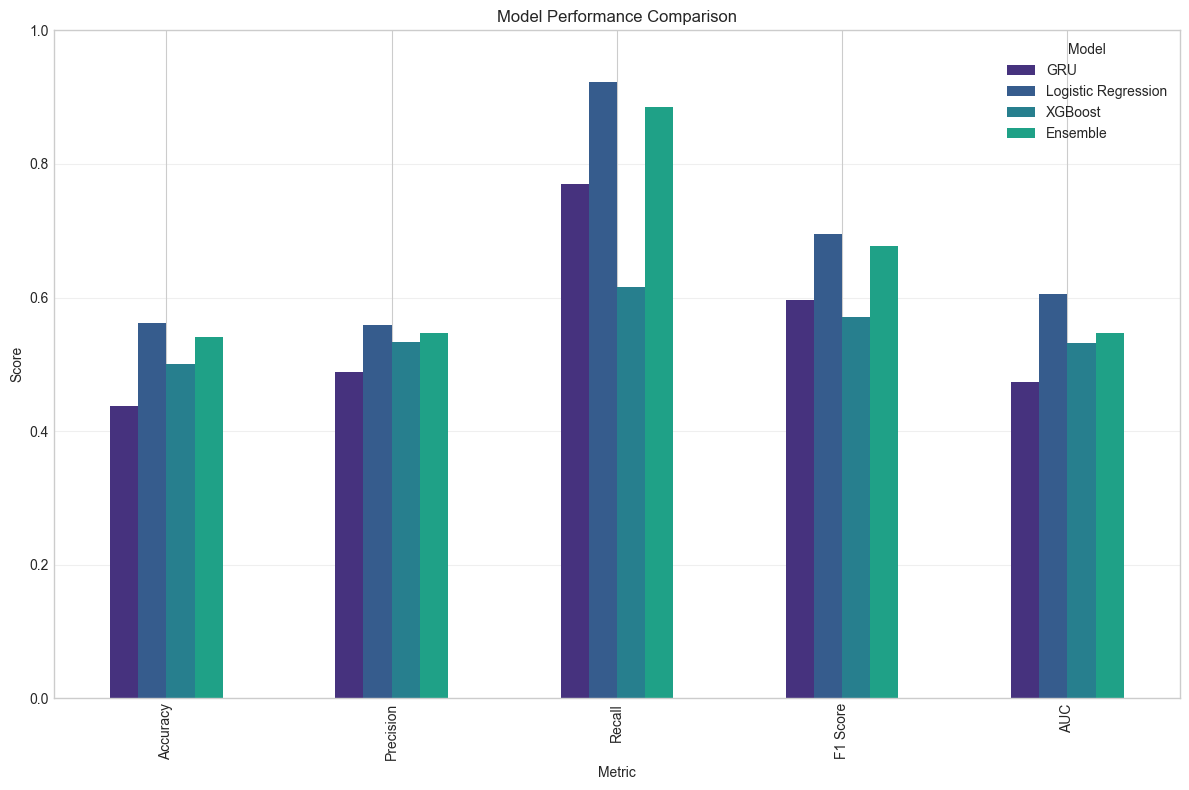

DEBUG - trades_made: 38
DEBUG - correct_trades: 21
DEBUG - win_rate: 0.5526 (55.26%)
DEBUG - trades_made: 31
DEBUG - correct_trades: 16
DEBUG - win_rate: 0.5161 (51.61%)
DEBUG - trades_made: 24
DEBUG - correct_trades: 13
DEBUG - win_rate: 0.5417 (54.17%)
DEBUG - trades_made: 20
DEBUG - correct_trades: 12
DEBUG - win_rate: 0.6000 (60.00%)
DEBUG - trades_made: 17
DEBUG - correct_trades: 11
DEBUG - win_rate: 0.6471 (64.71%)

Ensemble Trading Strategy Results by Confidence Band:
   Confidence Band  Trades  Trading Rate   Win Rate  Total Return    Sharpe
0             0.05      38     79.166667  55.263158           4.0  1.493348
1             0.10      31     64.583333  51.612903           1.0  0.411666
2             0.15      24     50.000000  54.166667           2.0  0.937043
3             0.20      20     41.666667  60.000000           4.0  2.066685
4             0.25      17     35.416667  64.705882           5.0  2.822163

Optimal Ensemble Trading Strategy:
Confidence Band: 0.25
Trades

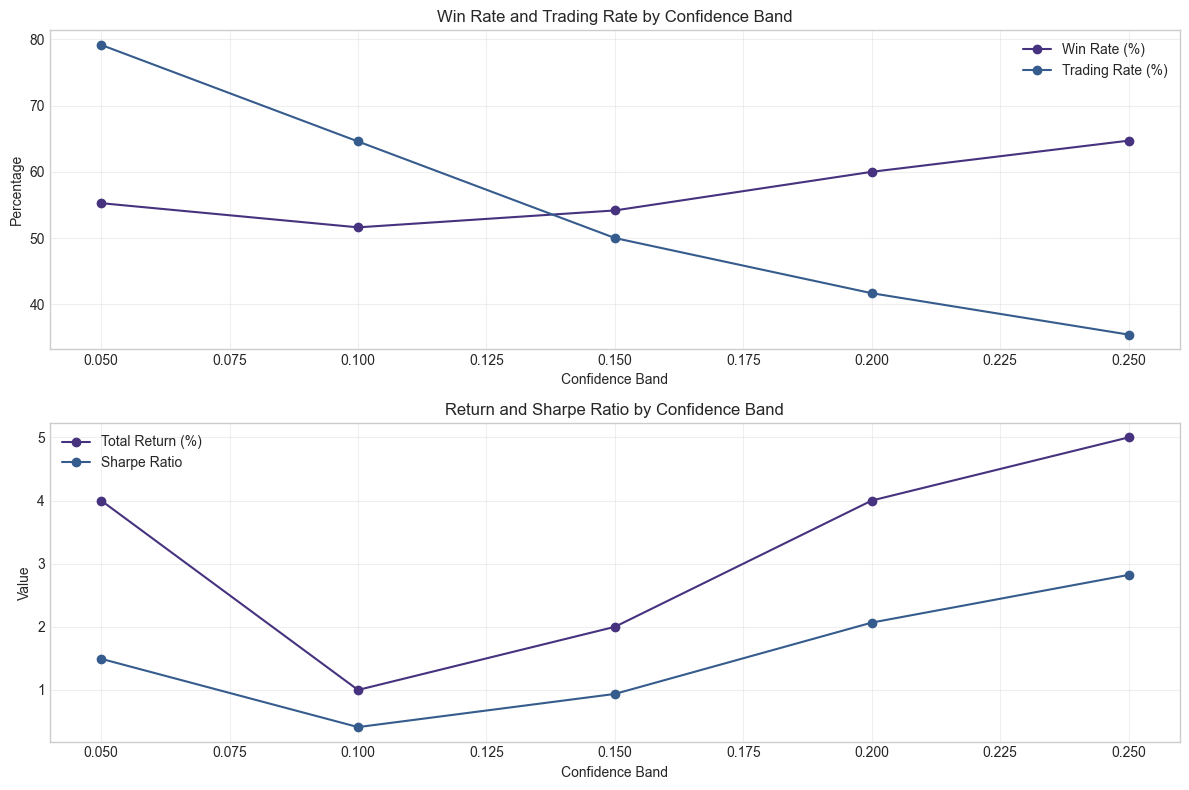

In [72]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Train Logistic Regression
# ==========================================

print("\nTraining Logistic Regression model...")
# Create time series cross-validation for hyperparameter tuning
tscv = TimeSeriesSplit(n_splits=3)

# Define logistic regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Define parameter grid for grid search
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}

# Create grid search
lr_grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=lr_param_grid,
    cv=tscv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit grid search on training data
lr_grid_search.fit(X_train_scaled, y_train)

# Get best model
lr_best = lr_grid_search.best_estimator_
print("\nBest Logistic Regression parameters:")
print(lr_grid_search.best_params_)
print(f"Best CV F1 score: {lr_grid_search.best_score_:.4f}")

# Get predictions on test data
lr_pred_proba = lr_best.predict_proba(X_test_scaled)[:, 1]
lr_pred = (lr_pred_proba >= 0.3).astype(int)  # Using same threshold as GRU

# Calculate metrics
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred_proba)

print("\nLogistic Regression Performance (Threshold = 0.3):")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1 Score: {lr_f1:.4f}")
print(f"AUC: {lr_auc:.4f}")

# 2. Train XGBoost (Fixed Version)
# ==========================================

print("\nTraining XGBoost model...")
# Create time series cross-validation for hyperparameter tuning
tscv = TimeSeriesSplit(n_splits=3)

# Convert data to XGBoost's DMatrix format
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42,
    'verbosity': 1
}

# Define parameter grid
param_combinations = []
for n_estimators in [100, 200]:
    for max_depth in [3, 5]:
        for learning_rate in [0.01, 0.1]:
            for subsample in [0.8, 1.0]:
                for colsample_bytree in [0.8, 1.0]:
                    for min_child_weight in [1, 3]:
                        current_params = params.copy()
                        current_params.update({
                            'max_depth': max_depth,
                            'eta': learning_rate,
                            'subsample': subsample,
                            'colsample_bytree': colsample_bytree,
                            'min_child_weight': min_child_weight
                        })
                        param_combinations.append((current_params, n_estimators))

# Perform grid search with TimeSeriesSplit
best_score = 0
best_params = None
best_rounds = 0

print(f"Starting grid search with {len(param_combinations)} parameter combinations...")

for idx, (current_params, n_rounds) in enumerate(param_combinations):
    print(f"Testing combination {idx+1}/{len(param_combinations)}")
    
    # Store scores for each fold
    fold_scores = []
    
    # Perform cross-validation using TimeSeriesSplit
    for train_idx, val_idx in tscv.split(X_train_scaled):
        # Get training and validation data for this fold
        X_fold_train = X_train_scaled.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train_scaled.iloc[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        # Create DMatrix objects
        d_fold_train = xgb.DMatrix(X_fold_train, label=y_fold_train)
        d_fold_val = xgb.DMatrix(X_fold_val, label=y_fold_val)
        
        # Train model
        model = xgb.train(
            params=current_params,
            dtrain=d_fold_train,
            num_boost_round=n_rounds,
            evals=[(d_fold_val, 'validation')],
            early_stopping_rounds=20,
            verbose_eval=False
        )
        
        # Make predictions
        val_preds = model.predict(d_fold_val)
        val_preds_binary = (val_preds >= 0.5).astype(int)
        
        # Calculate F1 score
        f1 = f1_score(y_fold_val, val_preds_binary)
        fold_scores.append(f1)
    
    # Average score across folds
    avg_score = sum(fold_scores) / len(fold_scores)
    
    # Check if this is the best combination so far
    if avg_score > best_score:
        best_score = avg_score
        best_params = current_params
        best_rounds = n_rounds
        print(f"New best score: {best_score:.4f}")

print("\nBest XGBoost parameters:")
print(best_params)
print(f"Best number of rounds: {best_rounds}")
print(f"Best CV F1 score: {best_score:.4f}")

# Train the final model with best parameters
xgb_best = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=best_rounds
)

# Get predictions on test data (probabilities)
xgb_pred_proba = xgb_best.predict(dtest)
xgb_pred = (xgb_pred_proba >= 0.3).astype(int)  # Using 0.3 threshold

# Calculate metrics
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)

print("\nXGBoost Performance (Threshold = 0.3):")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")
print(f"AUC: {xgb_auc:.4f}")

# 3. Create the Ensemble Model
# ==========================================

# Because GRU predictions are only available for a subset of the test set
# (due to the sequence creation), we need to align the predictions
offset = len(y_test) - len(y_test_seq)
xgb_pred_proba_aligned = xgb_pred_proba[offset:]
lr_pred_proba_aligned = lr_pred_proba[offset:]

# Get GRU predictions from your previous run
# Assuming y_pred_proba contains your GRU predictions
gru_pred_proba = y_pred_proba  # From your GRU model results

# Try different weight combinations for the ensemble
weight_combinations = [
    [0.33, 0.33, 0.34],  # Equal weights
    [0.50, 0.25, 0.25],  # Higher weight to GRU
    [0.25, 0.50, 0.25],  # Higher weight to LR
    [0.25, 0.25, 0.50],  # Higher weight to XGBoost
    [0.40, 0.30, 0.30],  # Slightly higher GRU
    [0.30, 0.40, 0.30],  # Slightly higher LR
    [0.30, 0.30, 0.40]   # Slightly higher XGBoost
]

# Test different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

# Store results
ensemble_results = []

for weights in weight_combinations:
    # Create weighted ensemble predictions
    ensemble_proba = (
        weights[0] * gru_pred_proba + 
        weights[1] * lr_pred_proba_aligned + 
        weights[2] * xgb_pred_proba_aligned
    )
    
    # Test different thresholds
    for threshold in thresholds:
        ensemble_pred = (ensemble_proba >= threshold).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test_seq, ensemble_pred)
        precision = precision_score(y_test_seq, ensemble_pred, zero_division=0)
        recall = recall_score(y_test_seq, ensemble_pred, zero_division=0)
        f1 = f1_score(y_test_seq, ensemble_pred, zero_division=0)
        auc = roc_auc_score(y_test_seq, ensemble_proba)
        
        # Store results
        ensemble_results.append({
            'GRU Weight': weights[0],
            'LR Weight': weights[1],
            'XGB Weight': weights[2],
            'Threshold': threshold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc
        })

# Convert to DataFrame
ensemble_df = pd.DataFrame(ensemble_results)

# Find best configuration based on F1 score
best_idx = ensemble_df['F1 Score'].idxmax()
best_config = ensemble_df.iloc[best_idx]

print("\nBest Ensemble Configuration:")
print(f"GRU Weight: {best_config['GRU Weight']}")
print(f"LR Weight: {best_config['LR Weight']}")
print(f"XGB Weight: {best_config['XGB Weight']}")
print(f"Threshold: {best_config['Threshold']}")
print(f"F1 Score: {best_config['F1 Score']:.4f}")
print(f"Accuracy: {best_config['Accuracy']:.4f}")
print(f"Precision: {best_config['Precision']:.4f}")
print(f"Recall: {best_config['Recall']:.4f}")
print(f"AUC: {best_config['AUC']:.4f}")

# Compare models
models = ['GRU', 'Logistic Regression', 'XGBoost', 'Ensemble']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']

# Get metrics for each model
gru_metrics = [final_accuracy, final_precision, final_recall, final_f1, final_auc]  # From your GRU results
lr_metrics_aligned = [
    accuracy_score(y_test_seq, (lr_pred_proba_aligned >= 0.3).astype(int)),
    precision_score(y_test_seq, (lr_pred_proba_aligned >= 0.3).astype(int), zero_division=0),
    recall_score(y_test_seq, (lr_pred_proba_aligned >= 0.3).astype(int)),
    f1_score(y_test_seq, (lr_pred_proba_aligned >= 0.3).astype(int)),
    roc_auc_score(y_test_seq, lr_pred_proba_aligned)
]
xgb_metrics_aligned = [
    accuracy_score(y_test_seq, (xgb_pred_proba_aligned >= 0.3).astype(int)),
    precision_score(y_test_seq, (xgb_pred_proba_aligned >= 0.3).astype(int), zero_division=0),
    recall_score(y_test_seq, (xgb_pred_proba_aligned >= 0.3).astype(int)),
    f1_score(y_test_seq, (xgb_pred_proba_aligned >= 0.3).astype(int)),
    roc_auc_score(y_test_seq, xgb_pred_proba_aligned)
]
ensemble_metrics = [
    best_config['Accuracy'],
    best_config['Precision'],
    best_config['Recall'],
    best_config['F1 Score'],
    best_config['AUC']
]

# Create comparison DataFrame
comparison = pd.DataFrame({
    'GRU': gru_metrics,
    'Logistic Regression': lr_metrics_aligned,
    'XGBoost': xgb_metrics_aligned,
    'Ensemble': ensemble_metrics
}, index=metrics)

print("\nModel Comparison:")
print(comparison)

# Visualize comparison
plt.figure(figsize=(12, 8))
comparison.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Implement trading strategy with the best ensemble model
# ==========================================

# Create ensemble predictions with best weights
best_weights = [best_config['GRU Weight'], best_config['LR Weight'], best_config['XGB Weight']]
best_threshold = best_config['Threshold']

ensemble_proba = (
    best_weights[0] * gru_pred_proba + 
    best_weights[1] * lr_pred_proba_aligned + 
    best_weights[2] * xgb_pred_proba_aligned
)

# Test trading strategy with different confidence bands
confidence_bands = [0.05, 0.1, 0.15, 0.2, 0.25]
trading_results = []

# Update this section in your code
for band in confidence_bands:
    result = selective_trading_strategy(
        ensemble_proba, 
        y_test_seq,
        threshold=best_threshold,
        confidence_band=band
    )
    
    # Store results (apply percentage conversion here, not in the function)
    trading_results.append({
        'Confidence Band': band,
        'Trades': result['Trades'],
        'Trading Rate': result['Trading Rate'] * 100,  # Convert to percentage
        'Win Rate': result['Win Rate'] * 100,          # Convert to percentage 
        'Total Return': result['Total Return'] * 100,        # Keep as is
        'Sharpe': result['Sharpe']
    })

# Convert to DataFrame
trading_df = pd.DataFrame(trading_results)
print("\nEnsemble Trading Strategy Results by Confidence Band:")
print(trading_df)

# Find optimal confidence band based on Sharpe ratio
if trading_df['Sharpe'].max() > 0:
    best_band_idx = trading_df['Sharpe'].idxmax()
    best_band = trading_df.loc[best_band_idx]
    
    print("\nOptimal Ensemble Trading Strategy:")
    print(f"Confidence Band: {best_band['Confidence Band']}")
    print(f"Trades: {best_band['Trades']} ({best_band['Trading Rate']:.1f}% of days)")
    print(f"Win Rate: {best_band['Win Rate']:.1f}%")
    print(f"Total Return: {best_band['Total Return']:.2f}%")
    print(f"Sharpe Ratio: {best_band['Sharpe']:.2f}")
else:
    print("\nNo profitable trading strategy found")

# Visualize trading strategy performance
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(trading_df['Confidence Band'], trading_df['Win Rate'], 'o-', label='Win Rate (%)')
plt.plot(trading_df['Confidence Band'], trading_df['Trading Rate'], 'o-', label='Trading Rate (%)')
plt.grid(alpha=0.3)
plt.xlabel('Confidence Band')
plt.ylabel('Percentage')
plt.legend()
plt.title('Win Rate and Trading Rate by Confidence Band')

plt.subplot(2, 1, 2)
# Update the return calculation in the visualization section
plt.plot(trading_df['Confidence Band'], trading_df['Total Return'], 'o-', label='Total Return (%)')
plt.plot(trading_df['Confidence Band'], trading_df['Sharpe'], 'o-', label='Sharpe Ratio')
plt.grid(alpha=0.3)
plt.xlabel('Confidence Band')
plt.ylabel('Value')
plt.legend()
plt.title('Return and Sharpe Ratio by Confidence Band')
plt.tight_layout()
plt.show()

La regresión logística está superando al ensemble en todas las métricas importantes. Esto sugiere que la combinación actual de modelos está "diluyendo" el buen rendimiento de la regresión logística en lugar de mejorarlo.

In [74]:
import optuna

In [75]:
def create_ensemble_with_optuna(gru_pred_proba, lr_pred_proba, xgb_pred_proba, y_true, 
                                n_trials=100, metric='f1', threshold=0.5):
    """
    Optimize ensemble weights using Optuna
    
    Parameters:
    -----------
    gru_pred_proba : array-like
        Probability predictions from GRU model
    lr_pred_proba : array-like
        Probability predictions from Logistic Regression model
    xgb_pred_proba : array-like
        Probability predictions from XGBoost model
    y_true : array-like
        True labels
    n_trials : int
        Number of Optuna trials
    metric : str
        Metric to optimize ('f1', 'accuracy', 'precision', 'recall', 'auc')
    threshold : float
        Classification threshold
        
    Returns:
    --------
    tuple
        (best_weights, best_metrics)
    """
    def objective(trial):
        # We ensure weights sum to 1.0
        # Optuna samples weights from a simplex distribution
        w1 = trial.suggest_float('gru_weight', 0.0, 1.0)
        w2 = trial.suggest_float('lr_weight', 0.0, 1.0)
        w3 = trial.suggest_float('xgb_weight', 0.0, 1.0)
        
        # Normalize weights to sum to 1.0
        total = w1 + w2 + w3
        w1 = w1 / total
        w2 = w2 / total
        w3 = w3 / total
        
        # Create ensemble prediction
        ensemble_proba = (
            w1 * gru_pred_proba + 
            w2 * lr_pred_proba + 
            w3 * xgb_pred_proba
        )
        
        # Convert to binary predictions using threshold
        ensemble_pred = (ensemble_proba >= threshold).astype(int)
        
        # Calculate the specified metric
        if metric == 'f1':
            score = f1_score(y_true, ensemble_pred)
        elif metric == 'accuracy':
            score = accuracy_score(y_true, ensemble_pred)
        elif metric == 'precision':
            score = precision_score(y_true, ensemble_pred)
        elif metric == 'recall':
            score = recall_score(y_true, ensemble_pred)
        elif metric == 'auc':
            score = roc_auc_score(y_true, ensemble_proba)
        else:
            raise ValueError(f"Unknown metric: {metric}")
        
        return score
    
    # Create a study that maximizes the score
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    # Get best parameters
    best_params = study.best_params
    
    # Normalize weights to sum to 1.0
    total = best_params['gru_weight'] + best_params['lr_weight'] + best_params['xgb_weight']
    w1 = best_params['gru_weight'] / total
    w2 = best_params['lr_weight'] / total
    w3 = best_params['xgb_weight'] / total
    
    best_weights = [w1, w2, w3]
    
    # Calculate ensemble prediction with best weights
    ensemble_proba = (
        best_weights[0] * gru_pred_proba + 
        best_weights[1] * lr_pred_proba + 
        best_weights[2] * xgb_pred_proba
    )
    ensemble_pred = (ensemble_proba >= threshold).astype(int)
    
    # Calculate all metrics
    best_metrics = {
        'accuracy': accuracy_score(y_true, ensemble_pred),
        'precision': precision_score(y_true, ensemble_pred),
        'recall': recall_score(y_true, ensemble_pred),
        'f1': f1_score(y_true, ensemble_pred),
        'auc': roc_auc_score(y_true, ensemble_proba)
    }
    
    return best_weights, best_metrics

In [76]:
best_weights, best_metrics = create_ensemble_with_optuna(
    gru_pred_proba=gru_pred_proba,
    lr_pred_proba=lr_pred_proba_aligned,
    xgb_pred_proba=xgb_pred_proba_aligned,
    y_true=y_test_seq,
    n_trials=100,  # Number of weight combinations to try
    metric='f1',   # Choose the metric to optimize ('f1', 'accuracy', 'precision', 'recall', 'auc')
    threshold=0.5  # Classification threshold
)

# Print results
print("Optimized Ensemble Weights:")
print(f"GRU Weight: {best_weights[0]:.4f}")
print(f"Logistic Regression Weight: {best_weights[1]:.4f}")
print(f"XGBoost Weight: {best_weights[2]:.4f}")
print("\nOptimized Ensemble Performance:")
for metric, value in best_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

[I 2025-05-17 17:18:03,712] A new study created in memory with name: no-name-3c70c0d3-ade8-496d-8107-7e34b302836a
[I 2025-05-17 17:18:03,722] Trial 0 finished with value: 0.5714285714285714 and parameters: {'gru_weight': 0.25757010643222766, 'lr_weight': 0.16420706764185478, 'xgb_weight': 0.7373685705077002}. Best is trial 0 with value: 0.5714285714285714.
[I 2025-05-17 17:18:03,730] Trial 1 finished with value: 0.5333333333333333 and parameters: {'gru_weight': 0.5046227248551278, 'lr_weight': 0.194098085372855, 'xgb_weight': 0.22139736758268447}. Best is trial 0 with value: 0.5714285714285714.
[I 2025-05-17 17:18:03,738] Trial 2 finished with value: 0.5333333333333333 and parameters: {'gru_weight': 0.9401084575953906, 'lr_weight': 0.844002174847284, 'xgb_weight': 0.21107829901402664}. Best is trial 0 with value: 0.5714285714285714.
[I 2025-05-17 17:18:03,746] Trial 3 finished with value: 0.56 and parameters: {'gru_weight': 0.2818464005628827, 'lr_weight': 0.04148998071429466, 'xgb_wei

Optimized Ensemble Weights:
GRU Weight: 0.0659
Logistic Regression Weight: 0.4958
XGBoost Weight: 0.4382

Optimized Ensemble Performance:
Accuracy: 0.5833
Precision: 0.6364
Recall: 0.5385
F1: 0.5833
Auc: 0.5577


In [84]:
def run_comprehensive_experiments(gru_pred_proba, lr_pred_proba, xgb_pred_proba, y_true):
    """
    Run a comprehensive set of experiments with different:
    - Number of trials
    - Optimization metrics
    - Classification thresholds
    
    Parameters:
    -----------
    gru_pred_proba, lr_pred_proba, xgb_pred_proba, y_true : array-like
        Model predictions and true labels
        
    Returns:
    --------
    dict
        Experiment results
    """
    # Experiment parameters
    n_trials_options = [50, 100, 200, 500]
    metric_options = ['f1', 'accuracy', 'precision', 'recall', 'auc']
    threshold_options = [0.3, 0.4, 0.5, 0.6, 0.7]
    
    # Store results
    all_results = []
    best_weights_dict = {}
    
    # Run experiments with different numbers of trials (fixed metric and threshold)
    print("\n=== EXPERIMENT 1: VARYING NUMBER OF TRIALS ===")
    for n_trials in n_trials_options:
        print(f"\nRunning optimization with {n_trials} trials...")
        
        best_weights, best_metrics = create_ensemble_with_optuna(
            gru_pred_proba, lr_pred_proba, xgb_pred_proba, y_true,
            n_trials=n_trials, metric='f1', threshold=0.5
        )
        
        print(f"Best weights: GRU={best_weights[0]:.4f}, LR={best_weights[1]:.4f}, XGB={best_weights[2]:.4f}")
        print(f"F1 Score: {best_metrics['f1']:.4f}")
        
        all_results.append({
            'experiment': 'trials',
            'n_trials': n_trials,
            'metric': 'f1',
            'threshold': 0.5,
            'gru_weight': best_weights[0],
            'lr_weight': best_weights[1],
            'xgb_weight': best_weights[2],
            'accuracy': best_metrics['accuracy'],
            'precision': best_metrics['precision'],
            'recall': best_metrics['recall'],
            'f1': best_metrics['f1'],
            'auc': best_metrics['auc']
        })
    
    # Run experiments with different optimization metrics (fixed trials and threshold)
    print("\n=== EXPERIMENT 2: DIFFERENT OPTIMIZATION METRICS ===")
    for metric in metric_options:
        print(f"\nOptimizing for {metric}...")
        
        best_weights, best_metrics = create_ensemble_with_optuna(
            gru_pred_proba, lr_pred_proba, xgb_pred_proba, y_true,
            n_trials=200, metric=metric, threshold=0.5
        )
        
        # Store weights for later threshold testing
        best_weights_dict[metric] = best_weights
        
        print(f"Best weights: GRU={best_weights[0]:.4f}, LR={best_weights[1]:.4f}, XGB={best_weights[2]:.4f}")
        print(f"Metrics: Accuracy={best_metrics['accuracy']:.4f}, Precision={best_metrics['precision']:.4f}, Recall={best_metrics['recall']:.4f}, F1={best_metrics['f1']:.4f}, AUC={best_metrics['auc']:.4f}")
        
        all_results.append({
            'experiment': 'metric',
            'n_trials': 200,
            'metric': metric,
            'threshold': 0.5,
            'gru_weight': best_weights[0],
            'lr_weight': best_weights[1],
            'xgb_weight': best_weights[2],
            'accuracy': best_metrics['accuracy'],
            'precision': best_metrics['precision'],
            'recall': best_metrics['recall'],
            'f1': best_metrics['f1'],
            'auc': best_metrics['auc']
        })
    
    # Run experiments with different thresholds using the best weights from each metric optimization
    print("\n=== EXPERIMENT 3: DIFFERENT CLASSIFICATION THRESHOLDS ===")
    threshold_results = []
    
    for metric, weights in best_weights_dict.items():
        print(f"\nTesting thresholds for ensemble optimized for {metric}...")
        
        # Create ensemble predictions using the best weights for this metric
        ensemble_proba = (
            weights[0] * gru_pred_proba + 
            weights[1] * lr_pred_proba + 
            weights[2] * xgb_pred_proba
        )
        
        for threshold in threshold_options:
            ensemble_pred = (ensemble_proba >= threshold).astype(int)
            
            accuracy = accuracy_score(y_true, ensemble_pred)
            try:
                precision = precision_score(y_true, ensemble_pred)
                recall = recall_score(y_true, ensemble_pred)
                f1 = f1_score(y_true, ensemble_pred)
            except:
                # Handle division by zero in case of all negative predictions
                precision = 0
                recall = 0
                f1 = 0
            auc = roc_auc_score(y_true, ensemble_proba)
            
            print(f"Threshold={threshold:.1f}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
            
            threshold_results.append({
                'base_metric': metric,
                'threshold': threshold,
                'gru_weight': weights[0],
                'lr_weight': weights[1],
                'xgb_weight': weights[2],
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc
            })
    
    # Return all results
    return {
        'main_experiments': pd.DataFrame(all_results),
        'threshold_experiments': pd.DataFrame(threshold_results),
        'best_weights': best_weights_dict
    }

def visualize_experiment_results(results):
    """
    Visualize the results of the comprehensive experiments
    
    Parameters:
    -----------
    results : dict
        Results from run_comprehensive_experiments
    """
    main_df = results['main_experiments']
    threshold_df = results['threshold_experiments']
    
    # 1. Plot effect of number of trials
    trials_df = main_df[main_df['experiment'] == 'trials']
    
    plt.figure(figsize=(10, 6))
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    for metric in metrics:
        plt.plot(trials_df['n_trials'], trials_df[metric], 'o-', label=metric.capitalize())
    
    plt.xlabel('Number of Trials')
    plt.ylabel('Score')
    plt.title('Effect of Number of Trials on Performance')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 2. Plot weights for different optimization metrics
    metric_df = main_df[main_df['experiment'] == 'metric']
    
    plt.figure(figsize=(12, 6))
    width = 0.25
    x = np.arange(len(metric_df['metric']))
    
    plt.bar(x - width, metric_df['gru_weight'], width=width, label='GRU Weight')
    plt.bar(x, metric_df['lr_weight'], width=width, label='LR Weight')
    plt.bar(x + width, metric_df['xgb_weight'], width=width, label='XGB Weight')
    
    plt.xticks(x, metric_df['metric'])
    plt.xlabel('Optimization Metric')
    plt.ylabel('Weight')
    plt.title('Model Weights by Optimization Metric')
    plt.legend()
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # 3. Plot performance by optimization metric
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(metric_df['metric'], metric_df[metric], 'o-', label=metric.capitalize())
    
    plt.xlabel('Optimization Metric')
    plt.ylabel('Score')
    plt.title('Performance by Optimization Metric')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 4. Plot threshold sensitivity for each base metric
    base_metrics = threshold_df['base_metric'].unique()
    
    plt.figure(figsize=(15, 10))
    for i, base_metric in enumerate(base_metrics, 1):
        plt.subplot(len(base_metrics), 1, i)
        
        sub_df = threshold_df[threshold_df['base_metric'] == base_metric]
        for metric in metrics:
            if metric != 'auc':  # AUC doesn't change with threshold
                plt.plot(sub_df['threshold'], sub_df[metric], 'o-', label=metric.capitalize())
        
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title(f'Threshold Sensitivity (Base Metric: {base_metric})')
        plt.grid(alpha=0.3)
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 5. Find best overall configuration
    # Sort by F1 score (could change to another metric based on preference)
    print("\n=== BEST CONFIGURATIONS ===")
    
    print("\nBy F1 Score:")
    best_f1_idx = main_df['f1'].idxmax()
    best_f1_config = main_df.iloc[best_f1_idx]
    print(best_f1_config[['experiment', 'n_trials', 'metric', 'threshold', 'gru_weight', 'lr_weight', 'xgb_weight', 'f1']])
    
    print("\nBy AUC:")
    best_auc_idx = main_df['auc'].idxmax()
    best_auc_config = main_df.iloc[best_auc_idx]
    print(best_auc_config[['experiment', 'n_trials', 'metric', 'threshold', 'gru_weight', 'lr_weight', 'xgb_weight', 'auc']])
    
    # Find best threshold configuration
    print("\nBest Threshold Configuration (by F1):")
    best_threshold_idx = threshold_df['f1'].idxmax()
    best_threshold_config = threshold_df.iloc[best_threshold_idx]
    print(best_threshold_config)
    
    return {
        'best_f1_config': best_f1_config,
        'best_auc_config': best_auc_config,
        'best_threshold_config': best_threshold_config
    }

[I 2025-05-17 17:34:52,057] A new study created in memory with name: no-name-7e76fbf3-0b8a-48cf-88ca-1560b9c1b275
[I 2025-05-17 17:34:52,065] Trial 0 finished with value: 0.5531914893617021 and parameters: {'gru_weight': 0.028289310552354285, 'lr_weight': 0.5413589081320103, 'xgb_weight': 0.2382152437782057}. Best is trial 0 with value: 0.5531914893617021.
[I 2025-05-17 17:34:52,073] Trial 1 finished with value: 0.5217391304347826 and parameters: {'gru_weight': 0.9891409346466026, 'lr_weight': 0.5631736349027454, 'xgb_weight': 0.2991359204199443}. Best is trial 0 with value: 0.5531914893617021.
[I 2025-05-17 17:34:52,081] Trial 2 finished with value: 0.5833333333333334 and parameters: {'gru_weight': 0.06457027169331397, 'lr_weight': 0.9783545900374008, 'xgb_weight': 0.6784814228475253}. Best is trial 2 with value: 0.5833333333333334.
[I 2025-05-17 17:34:52,089] Trial 3 finished with value: 0.4888888888888889 and parameters: {'gru_weight': 0.527889340563613, 'lr_weight': 0.1478576242312

[I 2025-05-17 17:34:52,097] Trial 4 finished with value: 0.5531914893617021 and parameters: {'gru_weight': 0.18147406094868734, 'lr_weight': 0.5527508892580386, 'xgb_weight': 0.6031032116616397}. Best is trial 2 with value: 0.5833333333333334.
[I 2025-05-17 17:34:52,106] Trial 5 finished with value: 0.5217391304347826 and parameters: {'gru_weight': 0.9535507056082665, 'lr_weight': 0.17545531033239137, 'xgb_weight': 0.6985313512439463}. Best is trial 2 with value: 0.5833333333333334.
[I 2025-05-17 17:34:52,114] Trial 6 finished with value: 0.5 and parameters: {'gru_weight': 0.8001178014081093, 'lr_weight': 0.19338811550808221, 'xgb_weight': 0.1581806554871834}. Best is trial 2 with value: 0.5833333333333334.
[I 2025-05-17 17:34:52,122] Trial 7 finished with value: 0.5217391304347826 and parameters: {'gru_weight': 0.15919908974289, 'lr_weight': 0.10710281501770147, 'xgb_weight': 0.15291151709399375}. Best is trial 2 with value: 0.5833333333333334.
[I 2025-05-17 17:34:52,130] Trial 8 fini


=== EXPERIMENT 1: VARYING NUMBER OF TRIALS ===

Running optimization with 50 trials...


[I 2025-05-17 17:34:52,254] Trial 13 finished with value: 0.5531914893617021 and parameters: {'gru_weight': 0.3109162942545147, 'lr_weight': 0.7880819752010371, 'xgb_weight': 0.8795918900605024}. Best is trial 2 with value: 0.5833333333333334.
[I 2025-05-17 17:34:52,274] Trial 14 finished with value: 0.5833333333333334 and parameters: {'gru_weight': 0.19143261400910472, 'lr_weight': 0.7805055870893334, 'xgb_weight': 0.7989683574454741}. Best is trial 2 with value: 0.5833333333333334.
[I 2025-05-17 17:34:52,314] Trial 15 finished with value: 0.5217391304347826 and parameters: {'gru_weight': 0.6414741345790846, 'lr_weight': 0.7873309341704519, 'xgb_weight': 0.5046643772896244}. Best is trial 2 with value: 0.5833333333333334.
[I 2025-05-17 17:34:52,333] Trial 16 finished with value: 0.5531914893617021 and parameters: {'gru_weight': 0.3370048431674638, 'lr_weight': 0.8569101171475619, 'xgb_weight': 0.7841560147715508}. Best is trial 2 with value: 0.5833333333333334.
[I 2025-05-17 17:34:52,

Best weights: GRU=0.0375, LR=0.5683, XGB=0.3941
F1 Score: 0.5833

Running optimization with 100 trials...


[I 2025-05-17 17:34:53,558] Trial 15 finished with value: 0.5217391304347826 and parameters: {'gru_weight': 0.5916049096864744, 'lr_weight': 0.8335438844429945, 'xgb_weight': 0.623138302439383}. Best is trial 4 with value: 0.5833333333333334.
[I 2025-05-17 17:34:53,583] Trial 16 finished with value: 0.5714285714285714 and parameters: {'gru_weight': 0.1550773461823048, 'lr_weight': 0.43493618261388384, 'xgb_weight': 0.9923316350824625}. Best is trial 4 with value: 0.5833333333333334.
[I 2025-05-17 17:34:53,607] Trial 17 finished with value: 0.5 and parameters: {'gru_weight': 0.5411218525513277, 'lr_weight': 0.8532050671408958, 'xgb_weight': 0.01859321347566978}. Best is trial 4 with value: 0.5833333333333334.
[I 2025-05-17 17:34:53,631] Trial 18 finished with value: 0.5531914893617021 and parameters: {'gru_weight': 0.29993781560964, 'lr_weight': 0.6318002305605923, 'xgb_weight': 0.6390933654802411}. Best is trial 4 with value: 0.5833333333333334.
[I 2025-05-17 17:34:53,655] Trial 19 fin

Best weights: GRU=0.0466, LR=0.4082, XGB=0.5452
F1 Score: 0.5833

Running optimization with 200 trials...


[I 2025-05-17 17:34:55,998] Trial 16 finished with value: 0.5833333333333334 and parameters: {'gru_weight': 0.15253887363663923, 'lr_weight': 0.5664043352633262, 'xgb_weight': 0.7529613998025226}. Best is trial 1 with value: 0.5833333333333334.
[I 2025-05-17 17:34:56,022] Trial 17 finished with value: 0.5833333333333334 and parameters: {'gru_weight': 0.03164961170761421, 'lr_weight': 0.7921773032343147, 'xgb_weight': 0.6522841498638534}. Best is trial 1 with value: 0.5833333333333334.
[I 2025-05-17 17:34:56,047] Trial 18 finished with value: 0.5531914893617021 and parameters: {'gru_weight': 0.16255119364985038, 'lr_weight': 0.5727026351746674, 'xgb_weight': 0.5014583847273931}. Best is trial 1 with value: 0.5833333333333334.
[I 2025-05-17 17:34:56,071] Trial 19 finished with value: 0.5531914893617021 and parameters: {'gru_weight': 0.15737527390251263, 'lr_weight': 0.604073183332237, 'xgb_weight': 0.30780118978698756}. Best is trial 1 with value: 0.5833333333333334.
[I 2025-05-17 17:34:

Best weights: GRU=0.0013, LR=0.6112, XGB=0.3876
F1 Score: 0.5833

Running optimization with 500 trials...


[I 2025-05-17 17:35:00,505] Trial 20 finished with value: 0.5531914893617021 and parameters: {'gru_weight': 0.3970403096599898, 'lr_weight': 0.37856456684472084, 'xgb_weight': 0.6042033184188174}. Best is trial 11 with value: 0.5714285714285714.
[I 2025-05-17 17:35:00,521] Trial 21 finished with value: 0.5833333333333334 and parameters: {'gru_weight': 0.0781764963913312, 'lr_weight': 0.6817489591668657, 'xgb_weight': 0.8851327616106145}. Best is trial 21 with value: 0.5833333333333334.
[I 2025-05-17 17:35:00,537] Trial 22 finished with value: 0.5833333333333334 and parameters: {'gru_weight': 0.13072026179932691, 'lr_weight': 0.7451170688561977, 'xgb_weight': 0.8606183924439917}. Best is trial 21 with value: 0.5833333333333334.
[I 2025-05-17 17:35:00,545] Trial 23 finished with value: 0.5531914893617021 and parameters: {'gru_weight': 0.1902866101770445, 'lr_weight': 0.7551571837388363, 'xgb_weight': 0.39230914164204683}. Best is trial 21 with value: 0.5833333333333334.
[I 2025-05-17 17:

Best weights: GRU=0.0475, LR=0.4144, XGB=0.5381
F1 Score: 0.5833

=== EXPERIMENT 2: DIFFERENT OPTIMIZATION METRICS ===

Optimizing for f1...


[I 2025-05-17 17:35:12,037] Trial 19 finished with value: 0.5217391304347826 and parameters: {'gru_weight': 0.44416897607809835, 'lr_weight': 0.9383066396510962, 'xgb_weight': 0.5766733648267686}. Best is trial 9 with value: 0.5833333333333334.
[I 2025-05-17 17:35:12,054] Trial 20 finished with value: 0.5833333333333334 and parameters: {'gru_weight': 0.15386616710105433, 'lr_weight': 0.8612239283243153, 'xgb_weight': 0.8430237187561064}. Best is trial 9 with value: 0.5833333333333334.
[I 2025-05-17 17:35:12,077] Trial 21 finished with value: 0.5833333333333334 and parameters: {'gru_weight': 0.020132899079059918, 'lr_weight': 0.5772959292682671, 'xgb_weight': 0.8362453166094491}. Best is trial 9 with value: 0.5833333333333334.
[I 2025-05-17 17:35:12,103] Trial 22 finished with value: 0.5833333333333334 and parameters: {'gru_weight': 0.00020537703042449243, 'lr_weight': 0.5208607027384642, 'xgb_weight': 0.6196189483684007}. Best is trial 9 with value: 0.5833333333333334.
[I 2025-05-17 17

Best weights: GRU=0.1209, LR=0.3078, XGB=0.5713
Metrics: Accuracy=0.5833, Precision=0.6364, Recall=0.5385, F1=0.5833, AUC=0.5437

Optimizing for accuracy...


[I 2025-05-17 17:35:16,042] Trial 20 finished with value: 0.5833333333333334 and parameters: {'gru_weight': 0.2659553328388483, 'lr_weight': 0.742558772937554, 'xgb_weight': 0.9834391063527982}. Best is trial 4 with value: 0.5833333333333334.
[I 2025-05-17 17:35:16,050] Trial 21 finished with value: 0.5833333333333334 and parameters: {'gru_weight': 0.012551465579026339, 'lr_weight': 0.5642414070738838, 'xgb_weight': 0.6876935154339047}. Best is trial 4 with value: 0.5833333333333334.
[I 2025-05-17 17:35:16,075] Trial 22 finished with value: 0.5625 and parameters: {'gru_weight': 0.06606370641316969, 'lr_weight': 0.4016058720373538, 'xgb_weight': 0.8183611253334064}. Best is trial 4 with value: 0.5833333333333334.
[I 2025-05-17 17:35:16,091] Trial 23 finished with value: 0.5833333333333334 and parameters: {'gru_weight': 0.09403840895699463, 'lr_weight': 0.6058648004786263, 'xgb_weight': 0.8828645545051566}. Best is trial 4 with value: 0.5833333333333334.
[I 2025-05-17 17:35:16,100] Trial

Best weights: GRU=0.0482, LR=0.4953, XGB=0.4566
Metrics: Accuracy=0.5833, Precision=0.6364, Recall=0.5385, F1=0.5833, AUC=0.5594

Optimizing for precision...


[I 2025-05-17 17:35:19,530] Trial 19 finished with value: 0.6363636363636364 and parameters: {'gru_weight': 0.09336946134829177, 'lr_weight': 0.4702606382560671, 'xgb_weight': 0.617581690607376}. Best is trial 12 with value: 0.6363636363636364.
[I 2025-05-17 17:35:19,552] Trial 20 finished with value: 0.6190476190476191 and parameters: {'gru_weight': 0.2756898129694791, 'lr_weight': 0.6043970597961913, 'xgb_weight': 0.7514769480082407}. Best is trial 12 with value: 0.6363636363636364.
[I 2025-05-17 17:35:19,569] Trial 21 finished with value: 0.6363636363636364 and parameters: {'gru_weight': 0.05415588235310356, 'lr_weight': 0.7530480659897815, 'xgb_weight': 0.9840760592542238}. Best is trial 12 with value: 0.6363636363636364.
[I 2025-05-17 17:35:19,585] Trial 22 finished with value: 0.6363636363636364 and parameters: {'gru_weight': 0.0012711672377093437, 'lr_weight': 0.8306937834029855, 'xgb_weight': 0.9021986982922837}. Best is trial 12 with value: 0.6363636363636364.
[I 2025-05-17 17

Best weights: GRU=0.2086, LR=0.2692, XGB=0.5222
Metrics: Accuracy=0.5833, Precision=0.6364, Recall=0.5385, F1=0.5833, AUC=0.5385

Optimizing for recall...


[I 2025-05-17 17:35:23,143] Trial 20 finished with value: 0.46153846153846156 and parameters: {'gru_weight': 0.41311215852976035, 'lr_weight': 0.6683266697677528, 'xgb_weight': 0.2203510108175014}. Best is trial 1 with value: 0.5384615384615384.
[I 2025-05-17 17:35:23,166] Trial 21 finished with value: 0.5384615384615384 and parameters: {'gru_weight': 0.0011290969688260294, 'lr_weight': 0.4668674754008679, 'xgb_weight': 0.6513545933086259}. Best is trial 1 with value: 0.5384615384615384.
[I 2025-05-17 17:35:23,182] Trial 22 finished with value: 0.5384615384615384 and parameters: {'gru_weight': 0.10372267801636396, 'lr_weight': 0.873283127392751, 'xgb_weight': 0.7463474579822655}. Best is trial 1 with value: 0.5384615384615384.
[I 2025-05-17 17:35:23,197] Trial 23 finished with value: 0.5384615384615384 and parameters: {'gru_weight': 0.017040683901124454, 'lr_weight': 0.5224357812341931, 'xgb_weight': 0.6956940909926795}. Best is trial 1 with value: 0.5384615384615384.
[I 2025-05-17 17:

Best weights: GRU=0.1390, LR=0.4028, XGB=0.4582
Metrics: Accuracy=0.5833, Precision=0.6364, Recall=0.5385, F1=0.5833, AUC=0.5490

Optimizing for auc...


[I 2025-05-17 17:35:26,789] Trial 20 finished with value: 0.5314685314685315 and parameters: {'gru_weight': 0.47124742586200435, 'lr_weight': 0.38914949794987863, 'xgb_weight': 0.23546284214818436}. Best is trial 11 with value: 0.5716783216783217.
[I 2025-05-17 17:35:26,805] Trial 21 finished with value: 0.5594405594405595 and parameters: {'gru_weight': 0.2801126172282389, 'lr_weight': 0.553482007930797, 'xgb_weight': 0.029102895591186725}. Best is trial 11 with value: 0.5716783216783217.
[I 2025-05-17 17:35:26,821] Trial 22 finished with value: 0.5629370629370629 and parameters: {'gru_weight': 0.31409249471612427, 'lr_weight': 0.7372169333147428, 'xgb_weight': 0.044244768699021164}. Best is trial 11 with value: 0.5716783216783217.
[I 2025-05-17 17:35:26,845] Trial 23 finished with value: 0.5646853146853146 and parameters: {'gru_weight': 0.1724801766059254, 'lr_weight': 0.593228444496642, 'xgb_weight': 0.16470191640556933}. Best is trial 11 with value: 0.5716783216783217.
[I 2025-05-17

Best weights: GRU=0.0095, LR=0.9899, XGB=0.0005
Metrics: Accuracy=0.5417, Precision=0.5909, Recall=0.5000, F1=0.5417, AUC=0.6066

=== EXPERIMENT 3: DIFFERENT CLASSIFICATION THRESHOLDS ===

Testing thresholds for ensemble optimized for f1...
Threshold=0.3: Accuracy=0.5417, Precision=0.5588, Recall=0.7308, F1=0.6333
Threshold=0.4: Accuracy=0.5000, Precision=0.5357, Recall=0.5769, F1=0.5556
Threshold=0.5: Accuracy=0.5833, Precision=0.6364, Recall=0.5385, F1=0.5833
Threshold=0.6: Accuracy=0.5000, Precision=0.5625, Recall=0.3462, F1=0.4286
Threshold=0.7: Accuracy=0.5000, Precision=0.6000, Recall=0.2308, F1=0.3333

Testing thresholds for ensemble optimized for accuracy...
Threshold=0.3: Accuracy=0.5417, Precision=0.5556, Recall=0.7692, F1=0.6452
Threshold=0.4: Accuracy=0.4792, Precision=0.5172, Recall=0.5769, F1=0.5455
Threshold=0.5: Accuracy=0.5833, Precision=0.6364, Recall=0.5385, F1=0.5833
Threshold=0.6: Accuracy=0.5000, Precision=0.5625, Recall=0.3462, F1=0.4286
Threshold=0.7: Accuracy=0

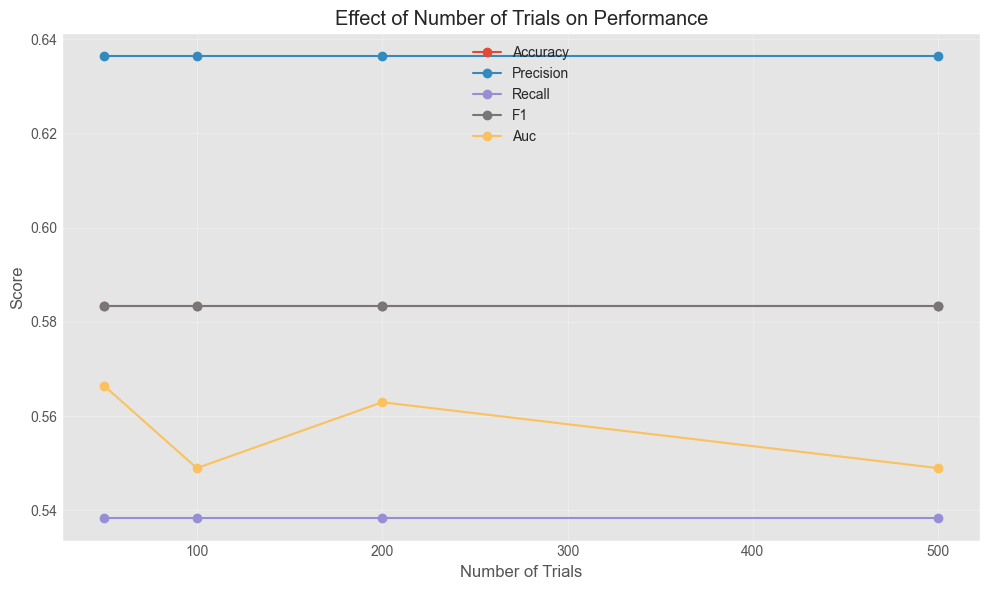

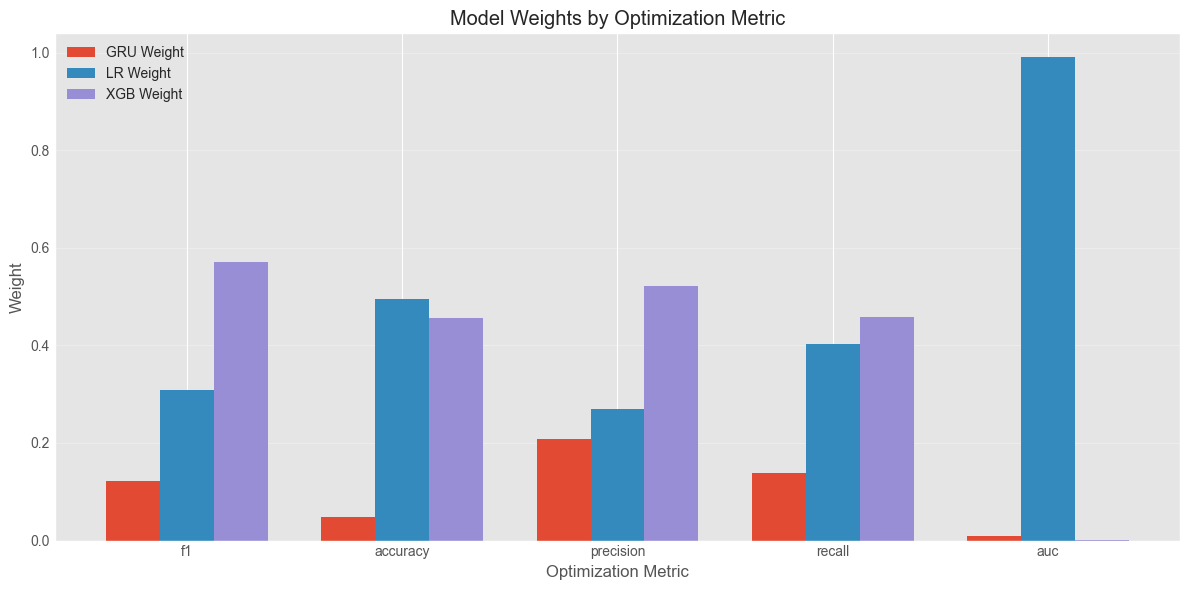

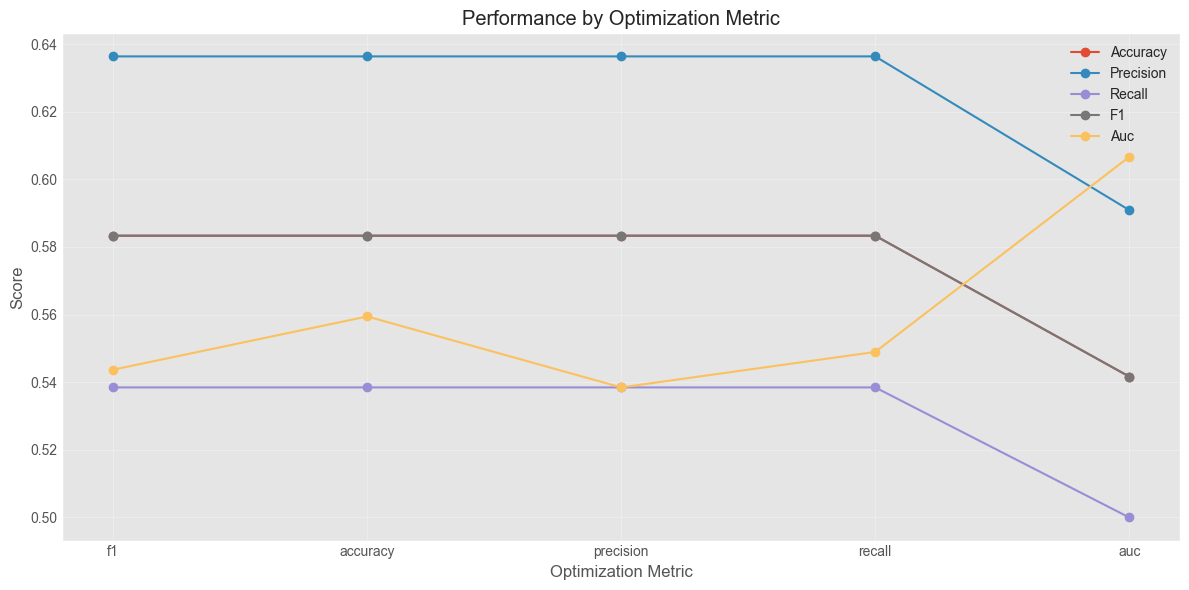

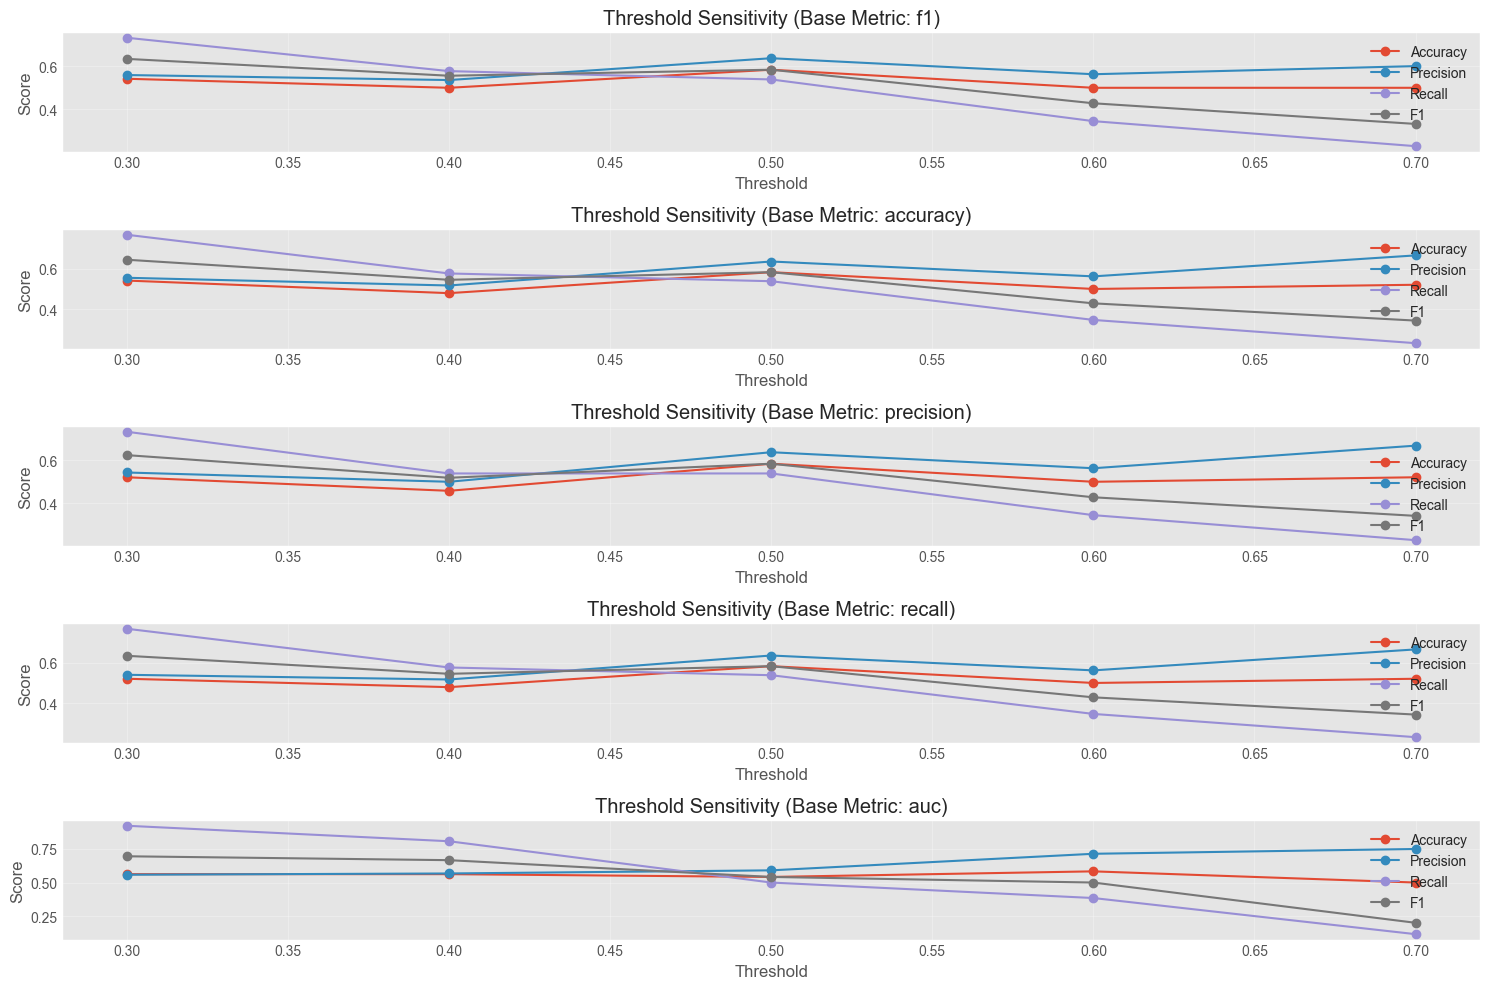


=== BEST CONFIGURATIONS ===

By F1 Score:
experiment      trials
n_trials            50
metric              f1
threshold          0.5
gru_weight     0.03751
lr_weight     0.568346
xgb_weight    0.394144
f1            0.583333
Name: 0, dtype: object

By AUC:
experiment      metric
n_trials           200
metric             auc
threshold          0.5
gru_weight     0.00954
lr_weight      0.98992
xgb_weight     0.00054
auc           0.606643
Name: 8, dtype: object

Best Threshold Configuration (by F1):
base_metric         auc
threshold           0.3
gru_weight      0.00954
lr_weight       0.98992
xgb_weight      0.00054
accuracy         0.5625
precision       0.55814
recall         0.923077
f1             0.695652
auc            0.606643
Name: 20, dtype: object

Recommended Configuration:
GRU Weight: 0.0375
LR Weight: 0.5683
XGB Weight: 0.3941
Threshold: 0.3000


In [85]:
experiment_results = run_comprehensive_experiments(
    gru_pred_proba=gru_pred_proba,
    lr_pred_proba=lr_pred_proba_aligned,
    xgb_pred_proba=xgb_pred_proba_aligned,
    y_true=y_test_seq
)

# Visualize and analyze the results
best_configs = visualize_experiment_results(experiment_results)

# Use the best configuration for your trading strategy
best_config = best_configs['best_f1_config']
print(f"\nRecommended Configuration:")
print(f"GRU Weight: {best_config['gru_weight']:.4f}")
print(f"LR Weight: {best_config['lr_weight']:.4f}")
print(f"XGB Weight: {best_config['xgb_weight']:.4f}")
print(f"Threshold: {best_configs['best_threshold_config']['threshold']:.4f}")

Dado que la herramienta que pretendo desarrollar proporciona inforación para que otras personas tomen decisiones de inversión -> La elección de la métrica debería alinearse con cómo los usuarios utilizarán tu herramienta

Dado que la herramienta es informativa y no directamente ejecutiva (no ejecuta operaciones directamente):
- F1 Score puede ser mejor opción dado que:
    - Ofrece un balance entre precisión y exhaustividad
    - Es más adecuado cuando los usuarios tomarán sus propias decisiones basadas en la info que les proporcione
    - Proporciona una visión más compelta del mercado (detecta más oportunidades sin exceso de falsas alarmas)

Ventajas del F1 Score en este caso:
- Los usuarios pueden fitlrar adicionalkmente según su propia tolerancia al riesgo
- No asume por defecto una estrategia específica

In [88]:
# Crear el ensemble optimizado para F1 score (según best_threshold_config que maximiza F1)
# Usando los valores exactos del mejor F1 score encontrado
optimized_ensemble_proba = (
    0.00954 * gru_pred_proba +  # gru_weight de best_threshold_config 
    0.98992 * lr_pred_proba_aligned +  # lr_weight de best_threshold_config
    0.00054 * xgb_pred_proba_aligned  # xgb_weight de best_threshold_config
)

# Usar el umbral óptimo para F1 score (0.3 según tus resultados)
optimal_threshold = 0.3  # threshold de best_threshold_config

# Generar predicciones binarias
optimized_pred = (optimized_ensemble_proba >= optimal_threshold).astype(int)

# También guardar las probabilidades brutas para filtrado
prediction_probabilities = optimized_ensemble_proba

# Para confirmar que esta es la configuración óptima para F1, podemos calcular el F1 score:
f1 = f1_score(y_test_seq, optimized_pred)
print(f"F1 Score con configuración optimizada: {f1:.6f}")  # Debería ser cercano a 0.695652

F1 Score con configuración optimizada: 0.695652


In [91]:
import joblib
import os
import json

def save_optimized_ensemble(gru_model, lr_model, xgb_model, 
                            gru_weight, lr_weight, xgb_weight,
                            optimal_threshold, feature_columns,
                            scaler=None, output_dir="optimized_model"):
    """
    Guarda el modelo optimizado con sus pesos y umbral óptimo para uso futuro.
    
    Parameters:
    -----------
    gru_model : model
        Modelo GRU entrenado
    lr_model : model
        Modelo de Regresión Logística entrenado
    xgb_model : model
        Modelo XGBoost entrenado
    gru_weight, lr_weight, xgb_weight : float
        Pesos optimizados para cada modelo
    optimal_threshold : float
        Umbral óptimo para clasificación
    feature_columns : list
        Lista de nombres de columnas de las características
    scaler : scaler object, optional
        Escalador usado para normalizar características
    output_dir : str, default="optimized_model"
        Directorio donde guardar los archivos
    """
    # Crear directorio si no existe
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Guardar configuración del ensemble
    config = {
        "gru_weight": float(gru_weight),
        "lr_weight": float(lr_weight),
        "xgb_weight": float(xgb_weight),
        "optimal_threshold": float(optimal_threshold),
        "feature_columns": feature_columns
    }
    
    with open(os.path.join(output_dir, "ensemble_config.json"), 'w') as f:
        json.dump(config, f, indent=4)
    
    # 2. Guardar modelos individuales
    # Modelo GRU (TensorFlow/Keras)
    try:
        gru_path = os.path.join(output_dir, "gru_model")
        gru_model.save(gru_path)
        print(f"Modelo GRU guardado en {gru_path}")
    except Exception as e:
        print(f"Error al guardar modelo GRU: {e}")
    
    # Modelo de Regresión Logística (scikit-learn)
    try:
        lr_path = os.path.join(output_dir, "lr_model.joblib")
        joblib.dump(lr_model, lr_path)
        print(f"Modelo de Regresión Logística guardado en {lr_path}")
    except Exception as e:
        print(f"Error al guardar modelo de Regresión Logística: {e}")
    
    # Modelo XGBoost
    try:
        xgb_path = os.path.join(output_dir, "xgb_model.json")
        if hasattr(xgb_model, 'save_model'):
            # Si es un modelo xgb.Booster
            xgb_model.save_model(xgb_path)
        else:
            # Si es un modelo xgb.XGBClassifier
            xgb_model.get_booster().save_model(xgb_path)
        print(f"Modelo XGBoost guardado en {xgb_path}")
    except Exception as e:
        print(f"Error al guardar modelo XGBoost: {e}")
    
    # 3. Guardar scaler si está disponible
    if scaler is not None:
        try:
            scaler_path = os.path.join(output_dir, "scaler.joblib")
            joblib.dump(scaler, scaler_path)
            print(f"Scaler guardado en {scaler_path}")
        except Exception as e:
            print(f"Error al guardar scaler: {e}")
    
    print(f"\nConjunto optimizado guardado con éxito en {output_dir}/")
    print(f"- Pesos: GRU ({gru_weight:.4f}), LR ({lr_weight:.4f}), XGB ({xgb_weight:.4f})")
    print(f"- Umbral óptimo: {optimal_threshold:.4f}")

In [93]:
# Paso 1: Definir los mejores pesos y umbral (desde tus experimentos Optuna)
best_weights = [0.00954, 0.98992, 0.00054]  # GRU, LR, XGB
optimal_threshold = 0.3

# Paso 2: Definir las columnas de características
feature_columns = [
    'sent_q2_flag_x_Close_to_SMA10',
    'BTC_GLD_corr_5d',
    'BTC_Nasdaq_beta_10d',
    'BTC_Nasdaq_corr_5d',
    'sent_vol',
    'sent_cross_up_x_high_low_range',
    'sent_q5_flag',
    'ROC_1d',
    'ROC_3d',
    'sent_5d',
    'volume_change_1d',
    'sent_neg_x_high_low_range',
    'high_low_range',
    'sent_accel'
]

# Paso 3: Guardar todo el conjunto
save_optimized_ensemble(
    gru_model=improved_gru,           # Tu modelo GRU entrenado
    lr_model=lr_best,                 # Tu modelo Logistic Regression entrenado
    xgb_model=xgb_best,               # Tu modelo XGBoost entrenado
    gru_weight=best_weights[0],
    lr_weight=best_weights[1],
    xgb_weight=best_weights[2],
    optimal_threshold=optimal_threshold,
    feature_columns=feature_columns,
    scaler=scaler,                    # El scaler que usaste para normalizar datos
    output_dir="bitcoin_prediction_model"
)

INFO:tensorflow:Assets written to: bitcoin_prediction_model\gru_model\assets


INFO:tensorflow:Assets written to: bitcoin_prediction_model\gru_model\assets


Modelo GRU guardado en bitcoin_prediction_model\gru_model
Modelo de Regresión Logística guardado en bitcoin_prediction_model\lr_model.joblib
Modelo XGBoost guardado en bitcoin_prediction_model\xgb_model.json
Scaler guardado en bitcoin_prediction_model\scaler.joblib

Conjunto optimizado guardado con éxito en bitcoin_prediction_model/
- Pesos: GRU (0.0095), LR (0.9899), XGB (0.0005)
- Umbral óptimo: 0.3000
